This repository provides sample code to reproduce figures from Liu, Schilling, et al, Integrative molecular and clinical modeling of clinical outcomes to PD1 blockade in patients with metastatic melanoma, Nat Med 2019 (PMID: 31792460 DOI: 10.1038/s41591-019-0654-5) with associated source data (supplemental data and tables from the paper). Most updated versions at https://github.com/vanallenlab/schadendorf-pd1

In [2]:


import pandas as pd
import numpy as np
import glob as glob
import math as math
import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
#import seaborn.apionly as sns
import matplotlib.patches as mpatches

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.statistics import multivariate_logrank_test
from lifelines.plotting import add_at_risk_counts

import seaborn as sns
sns.set(color_codes = True)

from matplotlib import gridspec
from matplotlib import colors
from matplotlib import artist
from matplotlib import rc_context

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import percentileofscore

%matplotlib inline

In [3]:
custom_rcParams = {
    'figure.figsize': (8, 3),
    'font.family': 'Arial',
    'font.size': 10,
    'font.weight': 'regular',
    'axes.labelsize': 14,
    'axes.formatter.useoffset': False,
    'axes.formatter.limits': (-4, 4),
    'axes.titlesize': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'pdf.fonttype': 42
}

mpl.rcParams.update(custom_rcParams)
sns.set_context('paper', rc=custom_rcParams)

import brewer2mpl
brewer2mpl.print_maps()
COLOR_LIST = brewer2mpl.get_map('Set3', 'Qualitative', 12).mpl_colors


Sequential
Blues     :  {3, 4, 5, 6, 7, 8, 9}
BuGn      :  {3, 4, 5, 6, 7, 8, 9}
BuPu      :  {3, 4, 5, 6, 7, 8, 9}
GnBu      :  {3, 4, 5, 6, 7, 8, 9}
Greens    :  {3, 4, 5, 6, 7, 8, 9}
Greys     :  {3, 4, 5, 6, 7, 8, 9}
OrRd      :  {3, 4, 5, 6, 7, 8, 9}
Oranges   :  {3, 4, 5, 6, 7, 8, 9}
PuBu      :  {3, 4, 5, 6, 7, 8, 9}
PuBuGn    :  {3, 4, 5, 6, 7, 8, 9}
PuRd      :  {3, 4, 5, 6, 7, 8, 9}
Purples   :  {3, 4, 5, 6, 7, 8, 9}
RdPu      :  {3, 4, 5, 6, 7, 8, 9}
Reds      :  {3, 4, 5, 6, 7, 8, 9}
YlGn      :  {3, 4, 5, 6, 7, 8, 9}
YlGnBu    :  {3, 4, 5, 6, 7, 8, 9}
YlOrBr    :  {3, 4, 5, 6, 7, 8, 9}
YlOrRd    :  {3, 4, 5, 6, 7, 8, 9}
Diverging
BrBG      :  {3, 4, 5, 6, 7, 8, 9, 10, 11}
PRGn      :  {3, 4, 5, 6, 7, 8, 9, 10, 11}
PiYG      :  {3, 4, 5, 6, 7, 8, 9, 10, 11}
PuOr      :  {3, 4, 5, 6, 7, 8, 9, 10, 11}
RdBu      :  {3, 4, 5, 6, 7, 8, 9, 10, 11}
RdGy      :  {3, 4, 5, 6, 7, 8, 9, 10, 11}
RdYlBu    :  {3, 4, 5, 6, 7, 8, 9, 10, 11}
RdYlGn    :  {3, 4, 5, 6, 7, 8, 9, 10, 11}
Spect

In [4]:
GRAY = (0.95, 0.95, 0.95, 1)
LIGHT_BLUE = (0.65098041296005249, 0.80784314870834351, 0.89019608497619629, 1.0)
BLUE = (0.12572087695201239, 0.47323337360924367, 0.707327968232772, 1.0)
LIGHT_GREEN = (0.68899655751153521, 0.8681737867056154, 0.54376011946622071, 1.0)
GREEN = (0.21171857311445125, 0.63326415104024547, 0.1812226118410335, 1.0)
PINK = (0.98320646005518297, 0.5980161709820524, 0.59423301088459368, 1.0)
RED = (0.89059593116535862, 0.10449827132271793, 0.11108035462744099, 1.0)
LIGHT_ORANGE = (0.99175701702342312, 0.74648213716698619, 0.43401768935077328, 1.0)
ORANGE = (0.99990772780250103, 0.50099192647372981, 0.0051211073118098693, 1.0)
LIGHT_PURPLE = (0.78329874347238004, 0.68724338552531095, 0.8336793640080622, 1.0)
PURPLE = (0.42485198495434734, 0.2511495584950722, 0.60386007743723258, 1.0)
YELLOW = (0.99760092286502611, 0.99489427150464516, 0.5965244373854468, 1.0)
LIGHT_BROWN = (0.9, 0.6, 0.5, 1.0)
BROWN = (0.69411766529083252, 0.3490196168422699, 0.15686275064945221, 1.0)

YELLOW = (255/256.,255/256.,51/256.,1.0)
BLUE = (55/256.,126/256.,184/256.,1.0)
PURPLE = (152/256.,78/256.,163/256.,1.0)
RED = (228/256.,26/256.,28/256.,1.0)
GREEN = (77/256.,175/256.,74/256.,1.0)
BROWN = (166/256.,86/256.,40/256.,1.0)
ORANGE = (255/256.,127/256.,0,1.0)
GRAY = (0.95, 0.95, 0.95, 1.0)

MUT_SIG_COLORS = [GRAY, LIGHT_BLUE, PINK, LIGHT_PURPLE, LIGHT_BROWN, LIGHT_GREEN, LIGHT_ORANGE]
PRIMARY_SIG_COLORS = [GRAY, LIGHT_GREEN, YELLOW, LIGHT_PURPLE, LIGHT_BLUE, LIGHT_ORANGE, BLUE, RED]

# DEFINE mutation and CNA types
MULTIPLE_MUTS = 3
SILENT = 0
MISSENSE_MUTATION = 1
TRUNCATED_MUTATION = 2
INFRAME_INDEL = 8

AMP = 6
HIGH_AMP = 7
HOMOZYGOUS_DEL = 5
LOH = 4
HOMOZYGOUS_DEL_AND_AMP = 9

# DEFINE COLORS for visualization
ALT_COLORS = {SILENT: GRAY,
             MISSENSE_MUTATION: LIGHT_GREEN,
             TRUNCATED_MUTATION: GREEN,
             MULTIPLE_MUTS: BROWN,
             LOH: LIGHT_BLUE,
             HOMOZYGOUS_DEL: BLUE,
             AMP: PINK,
             HIGH_AMP: RED,
             HOMOZYGOUS_DEL_AND_AMP:PURPLE,
             INFRAME_INDEL: LIGHT_ORANGE,
              10: "lime",
              11: "green"
            }
RESPONDER_COL = "forestgreen"
NRESPONDER_COL = "goldenrod"
SD_COL = "cornflowerblue"
CR_COL = GREEN
PR_COL = LIGHT_GREEN
PD_COL = "goldenrod"
MR_COL = PURPLE
LN_COL = PURPLE

#UV_COL = PRIMARY_SIG_COLORS[1]
#ALKYLATING_COL = PRIMARY_SIG_COLORS[2]
#OTHERSIG_COL = PRIMARY_SIG_COLORS[3]



In [5]:
# more color settings
RCOLORS = {
    'wheat3':'#CDBA96',
    'gold':"#FFD700",
    'coral1':'#FF7256',
    'dodgerblue3':'#1874CD',
    'skyblue':"#87CEEB",
    'skyblue3':"#6CA6CD",
    'orchid4':"#8B4789",
    'plum1':"#FFBBFF",
    'indianred1':"#FF6A6A",
    'firebrick1':"#FF3030",
    'firebrick4':"#8B1A1A",
    'hotpink2':"#EE6AA7",
    'firebrick':"#B22222",
    'grey90':"#E5E5E5",
    'magenta4':"#8B008B",
    'aquamarine2':"#76EEC6",
    'gray50':"#7F7F7F",
    'gray20':"#333333",
    'darkorchid4':"#68228B",
    'dodgerblue2':"#1C86EE",
    'palevioletred3':"#CD6889",
    'skyblue4':"#4A708B",
    'cyan3':"#00CDCD",
    'salmon3':"#CD7054",
    'seagreen3':"#43CD80",  
    'skyblue2':"#7EC0EE", 
    'skyblue1':"#87CEFF", 
    'seagreen2':"#4EEE94",
    'royalblue3':"#3A5FCD",
    'brown3':"#CD3333",
    'seagreen3':"#43CD80",
    'palegreen3':"#7CCD7C",
    'darkslategray3':"#79CDCD",
    'darkcyan':"#008B8B",
    'darkblue':"#00008B",
    'palevioletred3':"#CD6889",
    'peachpuff':"#FFDAB9",
    'palegreen3':"#7CCD7C",
    'slateblue1':"#836FFF",
    'tomato':"#FF6347",
    'palevioletred':"#DB7093",
    'lemonchiffon4': "#8B8970",
    'indianred':"#CD5C5C",
    'lemonchiffon2':"#EEE9BF",
    'slateblue3':"#6959CD",
    'sandybrown':"#F4A460",
    'palegreen2':"#90EE90",
    'turquoise3':"#00C5CD",
    'thistle':"#D8BFD8",
    'antiquewhite2':"#EEDFCC",
    'cadetblue':"#5F9EA0",
    'salmon4':"#8B4C39",
    'cadetblue2':"#8EE5EE",
    'rosybrown':"#BC8F8F",
    'gray80':"#CCCCCC",
    'darkseagreen':"#8FBC8F"        
}

COLOR_MAP = {
    'Cosmic 1+5':'antiquewhite2',
    'UV': 'gold',
    'Alkylating': 'coral1',
    'Clonal Mut': 'indigo',
    'Subclonal Mut': 'plum',
    'Genome Doubled': 'darkcyan'
}
# generate colors
def Colormap(feature):
    if feature not in COLOR_MAP:
        raise ValueError(feature + ' not found in COLOR_MAP')
    if COLOR_MAP[feature] not in RCOLORS:
        return COLOR_MAP[feature] 
#        raise ValueError(COLOR_MAP[feature] + ' not found in hexadecimal color conversion')
    return RCOLORS[COLOR_MAP[feature]]

# set default params
custom_rcParams = {
    'figure.figsize': (8, 3),
    'font.family': 'Arial',
    'font.size': 14,
    'font.weight': 'regular',
    'axes.labelsize': 14,
    'axes.formatter.useoffset': False,
    'axes.formatter.limits': (-4, 4),
    'axes.titlesize': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'pdf.fonttype': 42
}

mpl.rcParams.update(custom_rcParams)
sns.set_context('paper', rc=custom_rcParams)
sns.set_style("white", {"grid.linestyle": u'--', "axes.grid": True, "grid.color":"0.9"})


In [6]:
#dummy data
irisDF = sns.load_dataset("iris")

irisDF

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


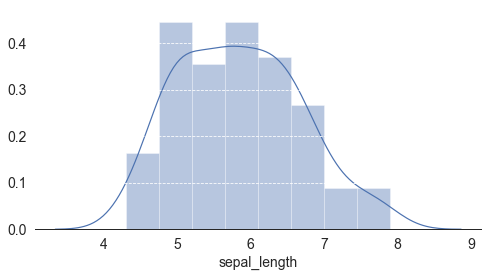

In [7]:
#barplot
def BarPlot(data, yaxisGrid = True, xaxisGrid = False):
    sns.set_style("white", {"grid.linestyle": u'--', "axes.grid": True, "grid.color":"0.9"})
    dp = sns.distplot(data)  
    dp.yaxis.grid(color="w")
    dp.xaxis.grid(xaxisGrid)
    dp.yaxis.grid(yaxisGrid)
    dp.set_axisbelow(False)
    sns.despine(left=True)
#plt.xlim(-4.5, 3.5)
#sns.set_style("")



fig = plt.figure(figsize = (8,4))
BarPlot(irisDF['sepal_length'])


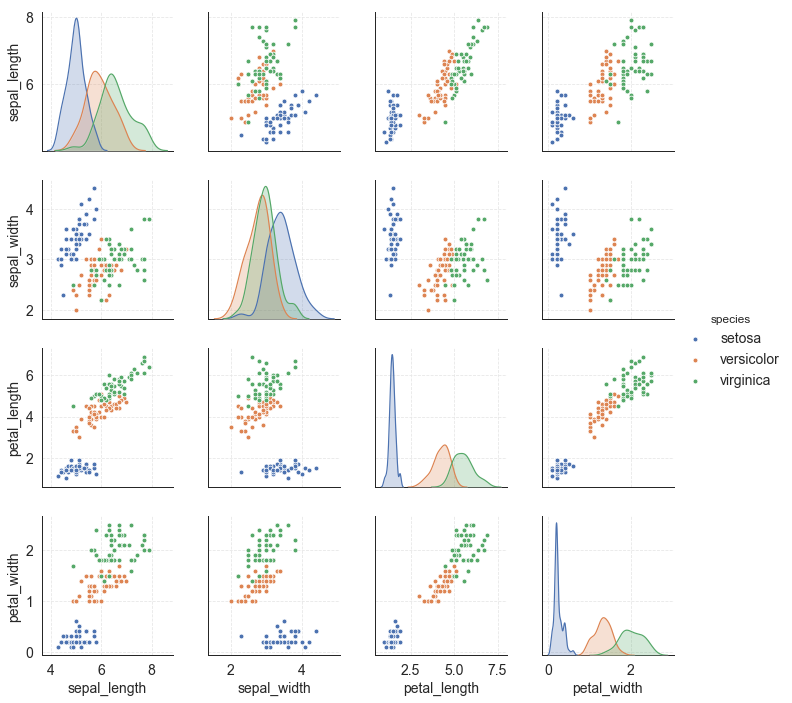

In [8]:
# Exploring pairwise relationships between columns
sns.pairplot(irisDF, hue="species")


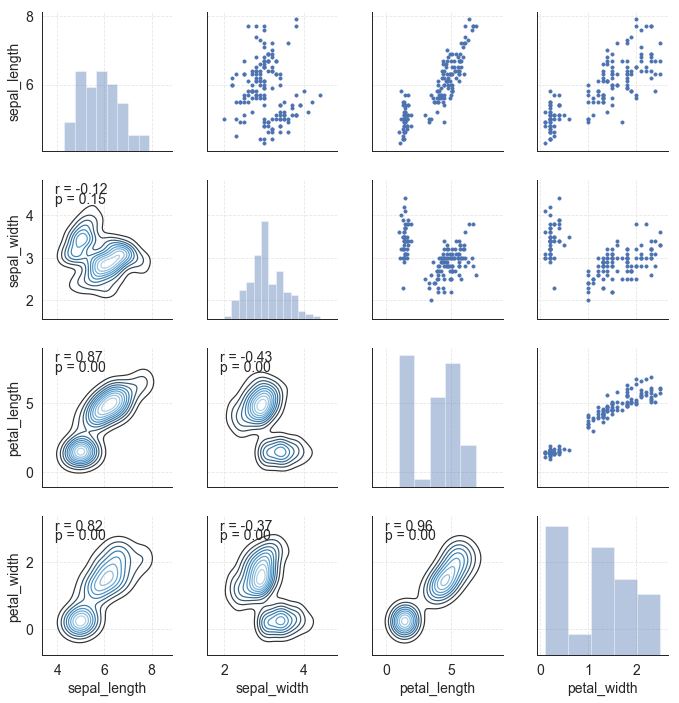

In [9]:
# More exploring pairwise relationships between columns! 
# Shamelessly stolen from https://stackoverflow.com/questions/30942577/seaborn-correlation-coefficient-on-pairgrid

def corrfunc(x, y, **kws):
    r, p = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate("p = {:.2f}".format(p),
                xy=(.1, .83), xycoords=ax.transAxes)

def PairsPlot(df):
    g = sns.PairGrid(df, palette=["red"])
    g.map_upper(plt.scatter, s=10)
    g.map_diag(sns.distplot, kde=False)
    g.map_lower(sns.kdeplot, cmap="Blues_d")
    g.map_lower(corrfunc)

PairsPlot(irisDF)

<Figure size 288x288 with 0 Axes>

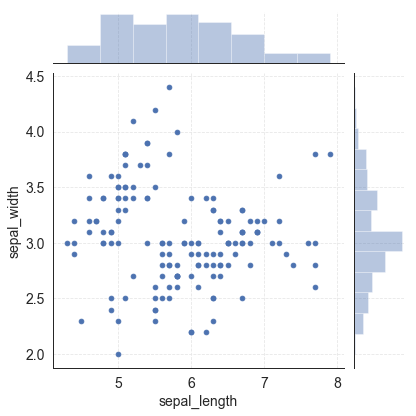

In [10]:
# exploring joint relationships between paired columns
fig = plt.figure(figsize = (4,4))

sns.jointplot(x='sepal_length', y='sepal_width', data =irisDF)



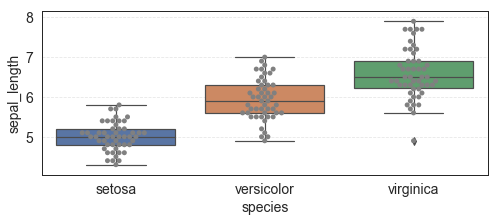

In [11]:
# generate boxplots separated by species with the data plotted
sns.boxplot(x="species", y="sepal_length", data=irisDF);
sns.swarmplot(x="species", y="sepal_length", data=irisDF, color="grey");


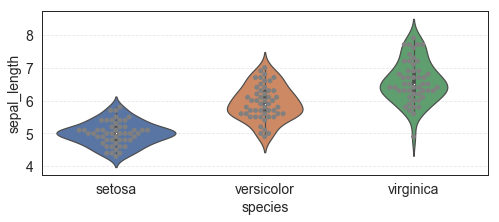

In [12]:
# another form of boxplot that shows the estimate of the density of data
sns.violinplot(x="species", y="sepal_length", data=irisDF);
sns.swarmplot(x="species", y="sepal_length", data=irisDF, color="grey");


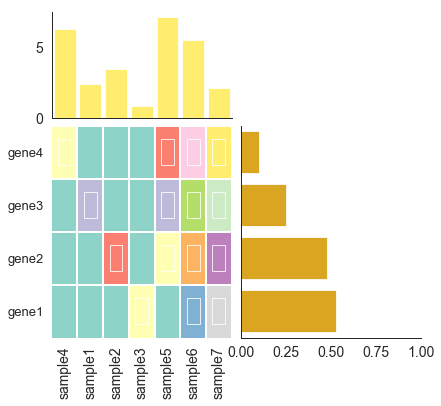

In [13]:
# Tileplot (also known as a comut plot!)
# GOAL: Generate a comut plot with the number of mutations per sample above
# and the frequency of gene mutations to the right of the central gene x sample
# figure

# This decomposes to 3 key tasks: 
#     1. CreateCoMutFig: generate a "comut" figure with rows as genes and columns as samples
#     2. CreateBarPlot: generate a barplot figure we will use for our mutational load figure
#     3. CreateHorizBarPlot: generate a horizontal barplot we will use for our gene frequency
# Then, we combine these three tasks in 3 subplots within an underlying grid to generate our figure.

# generate the underlying grid
fig = plt.figure(figsize = (10,6))

nrows = 2
ncols = 3
gs = gridspec.GridSpec(nrows,ncols, height_ratios = [1, 2], width_ratios = [1,1,1], 
                       wspace=0.05, hspace = 0.05)

# CreateCoMutFig: Assumes that a subplot has already been generated, generates
# initial set of row, column labels and values from the given dataframe.  Assumes
# rows are genes and columns are samples, and the index are gene names

def CreateCoMutFig(currentPlot, df, colorList = COLOR_LIST, cmap = None, italic=False):
    numGenes = len(df)
    numSamples = len(df.columns)

    # remove initial frame
    for side in ['top', 'bottom', 'right', 'left']: 
        currentPlot.spines[side].set_visible(False)
    
    # set colors
    if cmap is None:
        cmap = mpl.colors.ListedColormap(colorList)
        vmax = len(colorList) - 1
    else:
        vmax = 1
    
    # display data
    cax = currentPlot.imshow(df, interpolation = 'none', aspect = 'auto',
                    cmap = cmap, vmin = 0, vmax = vmax)
    
    # Remove tick marks
    plt.tick_params(axis = 'both', which = 'both', 
                top = False, bottom = False, right = False, left = False)
    
    # Resize tick marks
    plt.xticks(range(0, numSamples, 1), rotation = 90)
    plt.yticks(range(0, numGenes,1), fontsize = 13)
    
    # Replace y ticks with gene names
    if italic:
        currentPlot.set_yticklabels(df.index, style = 'italic')
    else:
        currentPlot.set_yticklabels(df.index)

    currentPlot.set_xticklabels(df.columns)
 
    
    # Create white lines across the grid
    for y in range(0, numGenes, 1):  
        plt.plot(range(-1, numSamples+2), [y+0.5] * (len(range(-1, numSamples))+2), "-", 
                 lw=2, color="white", alpha=1)
    for x in range(0,numSamples+1,1):
        plt.plot([x + 0.5] * len(range(-1,numGenes+1)), range(-1,numGenes+1), "-",
                 lw=2, color="white", alpha=1)    
        
    # limit the x and y-axis to just the range
    plt.xlim(-0.5, numSamples-0.5)
    plt.ylim(-0.5, numGenes-0.5)
    
    # remove grid lines
    currentPlot.grid(False)
    return (cax)

# AddMarkersCoMutFig - creates markers at given locations; e.g. to mark germline mutations
def AddMarkersCoMutFig(currentPlot, df, colorList = COLOR_LIST):
    # get dimensions of the plot
    numSamples = len(df.columns)
    numRows = len(df)

    for i in range(0,numRows):
        for j in range(0,numSamples):
            alt = int(df.iloc[i,j])
#            print i, j, ":", alt
            rect = plt.Rectangle((j-0.25, i-0.25), 0.5, 0.5, fc = colorList[alt])
            if alt != 0:
                currentPlot.add_patch(rect)
    
    #try a rectangle
#    rect = plt.Rectangle((0.75, 0.75), 0.5, 0.5, fc='r')
#    currentPlot.add_patch(rect)
    

# CreateBarPlot: Given a subplot and an array, generates bar graph without x labels
def CreateBarPlot(currentPlot, arr, xaxisGrid = False, yaxisGrid = True, colorList = COLOR_LIST):
    currentPlot.bar(np.arange(len(arr)), arr, align='center', width = 0.85, color=colorList[0])
    plt.setp(currentPlot.get_xticklabels(), visible=False) # make the labels invisible
    currentPlot.xaxis.grid(xaxisGrid)
    currentPlot.yaxis.grid(color="w")
    currentPlot.yaxis.grid(yaxisGrid)
    currentPlot.set_axisbelow(False)
    currentPlot.spines['right'].set_visible(False)
    currentPlot.spines['top'].set_visible(False)
#    sns.despine(left=True)

#    currentPlot.x
    # limit the axis to just the range
    plt.xlim(-0.5, len(arr)-0.5)

# CreateHorizBarPlot: Given a subplot and an array, generates horizontal bar graph without y labels
def CreateHorizBarPlot(currentPlot, arr, xaxisGrid = True, yaxisGrid = False, colorList = COLOR_LIST):
    currentPlot.barh(np.arange(len(arr)), arr, align='center', color=colorList[0])
    plt.setp(currentPlot.get_yticklabels(), visible=False) # make the labels invisible

    currentPlot.xaxis.grid(color="w")
    currentPlot.yaxis.grid(yaxisGrid)
    currentPlot.xaxis.grid(xaxisGrid)
    
    currentPlot.set_axisbelow(False)
    currentPlot.spines['right'].set_visible(False)
    currentPlot.spines['top'].set_visible(False)

    # limit the axis to just the range
    plt.ylim(-0.5, len(arr)-0.5)
    plt.xlim(0,1)
    
# data for our test figure
testDF = pd.DataFrame({'sample4': [0,0,0,1],
                       'sample1': [0,0,2,0],
                       'sample2': [0,3,0,0],
                       'sample3': [1,0,0,0],
                       'sample5': [0,1,2,3],
                       'sample6': [4,5,6,7],
                       'sample7': [8,9,10,11]},
                      index=['gene1','gene2','gene3','gene4'],
                      columns=['sample4','sample1','sample2','sample3','sample5','sample6','sample7'])

markerDF = pd.DataFrame({'sample4': [0,0,0,1],
                       'sample1': [0,0,2,0],
                       'sample2': [0,3,0,0],
                       'sample3': [1,0,0,0],
                       'sample5': [0,1,2,3],
                       'sample6': [4,5,6,7],
                       'sample7': [8,9,10,11]},
                      index=['gene1','gene2','gene3','gene4'],
                      columns=['sample4','sample1','sample2','sample3','sample5','sample6','sample7'])



coMutPlot = plt.subplot(gs[1,0])

img = CreateCoMutFig(coMutPlot, testDF, COLOR_LIST)

# try placing additional markers into the comut figure
AddMarkersCoMutFig(coMutPlot, markerDF, COLOR_LIST)


# Ok, now create a bar chart given a number for each of the samples, eg a 
# mut/mb barchart per sample and place it on top of the comut plot
testMutLoadDF = pd.DataFrame({'nonsynMut': [6.3, 2.4, 3.5, 0.8, 7.2, 5.5, 2.1]},
                            index = ['sample1','sample2','sample3','sample4', 'sample5', 'sample6', 'sample7'])

test3 = plt.subplot(gs[0,0], sharex = coMutPlot)
CreateBarPlot(test3, testMutLoadDF['nonsynMut'], yaxisGrid = False, colorList = [COLOR_LIST[11]])

geneFreqDF = pd.DataFrame({'freq': [0.53, 0.48, 0.25, 0.1]},
                         index = ['gene1','gene2','gene3','gene4'])

test4 = plt.subplot(gs[1,1], sharey = coMutPlot)
CreateHorizBarPlot(test4, geneFreqDF['freq'], xaxisGrid = False, colorList = ['goldenrod'])


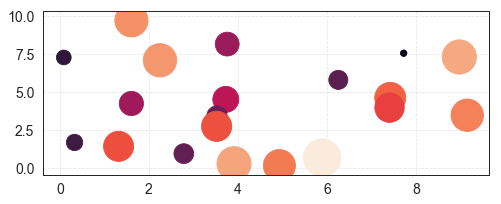

In [14]:
# repel labels
# Graphical functions, including repelling of data labels
# credit http://stackoverflow.com/questions/14938541/how-to-improve-the-label-placement-for-matplotlib-scatter-chart-code-algorithm
# can be useful to rearrange labels around data points.

import networkx as nx
np.random.seed(2016)

N = 20
scatter_data = np.random.rand(N, 3)*10


def repel_labels(ax, x, y, labels, k=0.01, fontsize = None):
    G = nx.DiGraph()
    data_nodes = []
    init_pos = {}
    for xi, yi, label in zip(x, y, labels):
        data_str = 'data_{0}'.format(label)
        G.add_node(data_str)
        G.add_node(label)
        G.add_edge(label, data_str)
        data_nodes.append(data_str)
        init_pos[data_str] = (xi, yi)
        init_pos[label] = (xi, yi)

    pos = nx.spring_layout(G, pos=init_pos, fixed=data_nodes, k=k)

    # undo spring_layout's rescaling
    pos_after = np.vstack([pos[d] for d in data_nodes])
    pos_before = np.vstack([init_pos[d] for d in data_nodes])
    scale, shift_x = np.polyfit(pos_after[:,0], pos_before[:,0], 1)
    scale, shift_y = np.polyfit(pos_after[:,1], pos_before[:,1], 1)
    shift = np.array([shift_x, shift_y])
    for key, val in pos.items():
        pos[key] = (val*scale) + shift

    for label, data_str in G.edges():
        if fontsize is None:
            ax.annotate(label,
                        xy=pos[data_str], xycoords='data',
                        xytext=pos[label], textcoords='data',
                        arrowprops=dict(arrowstyle="->",
                                        shrinkA=0, shrinkB=0,
                                        connectionstyle="arc3", 
                                        color='red'))
        else:
            ax.annotate(label,
                        xy=pos[data_str], xycoords='data',
                        xytext=pos[label], textcoords='data',
                        arrowprops=dict(arrowstyle="->",
                                        shrinkA=0, shrinkB=0,
                                        connectionstyle="arc3", 
                                        color='red'), fontsize=fontsize)
    # expand limits
    all_pos = np.vstack(pos.values())
    x_span, y_span = np.ptp(all_pos, axis=0)
    mins = np.min(all_pos-x_span*0.15, 0)
    maxs = np.max(all_pos+y_span*0.15, 0)
    ax.set_xlim([mins[0], maxs[0]])
    ax.set_ylim([mins[1], maxs[1]])

fig, ax = plt.subplots()
ax.scatter(scatter_data[:, 0], scatter_data[:, 1],
           c=scatter_data[:, 2], s=scatter_data[:, 2] * 150)
labels = ['ano_{}'.format(i) for i in range(N)]
#repel_labels(ax, scatter_data[:, 0], scatter_data[:, 1], labels, k=0.02, fontsize=12)

plt.show()


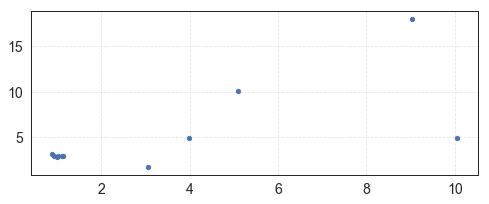

In [15]:
# Adding Jitter as graphical help
# credit http://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot

def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, verts=verts, hold=hold, **kwargs)

x = [1, 1, 1, 1, 1, 1, 3, 4, 5, 9, 10]
y = [3, 3, 3, 3, 3, 3, 2, 5, 10, 18, 5]

jitter(x,y)

/Users/davidliu/anaconda2/envs/combi-d/lib/python2.7/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


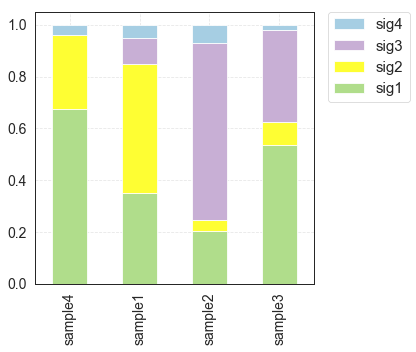

In [16]:
# GRAPHING AND HELPER FUNCTIONS
"""
PlotStackedBarPlot - given a plot, df of values (columns are samples, rows are signature coefficients/values), 
colorList and legend size generates the stacked bar graph with a legend of the given size.
"""
def PlotStackedBarPlot(barPlot, df_nonnorm, sigOrder = None, xlabel = False, colorList = PRIMARY_SIG_COLORS, 
                       normalize = False, legendSize = 50):
    numSamples = len(df_nonnorm.columns)
    numClasses = len(df_nonnorm)

#    plt.figure(figsize=(30,10))

    if normalize: 
        # normalize data
        df = df_nonnorm/df_nonnorm.apply(sum, axis = 0)
    else:
        df = df_nonnorm

    # set order
    if sigOrder is None: # set signature order to default order
        sigOrder = df_nonnorm.index    
    df = df.loc[sigOrder]
    
    # generate the bottoms of each of the stacked values
    bottom = [np.array([0] * numSamples)]
    for i in range(0, numClasses):
        bottom.append(bottom[i] + np.array(df.iloc[i,:]))
    
    ind = np.arange(numSamples)
    width = 0.5
    bargraphs = []
    
    for i in range(0, numClasses):
        bargraphs.append(plt.bar(ind, df.iloc[i,:], width, bottom = bottom[i], color = colorList[i+1]))

    # label x axis
    if xlabel:
        plt.setp(barPlot.get_xticklabels(), visible=True)
        plt.xticks(ind, df.columns, rotation = 'vertical')
#        barPlot.get_xaxis().set_ticks(ind + width/2., df.columns, rotation = 'vertical')
    else:
        plt.setp(barPlot.get_xticklabels(), visible=False)

    # Limit x axis
    plt.xlim(-0.5, numSamples-0.5)
        
#        barPlot.get_xaxis().set_ticks(ind + width/2., [])
    
    # label y axis
    barPlot.get_yaxis().set_label("Mutations")
    
    
    # Legend
    if legendSize is not None:
        barPlot.legend([x[0] for x in bargraphs[::-1]], sigOrder[::-1], prop = {'size':legendSize}, 
                        bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# example
testDF = pd.DataFrame({'sample4': [87,37,0,5],
                       'sample1': [35,50,10,5],
                       'sample2': [15,3,50,5],
                       'sample3': [30,5,20,1]},
                      index=['sig1','sig2','sig3','sig4'],
                      columns=['sample4','sample1','sample2','sample3'])
                       
fig = plt.figure(figsize = (5,5))
barPlot = plt.subplot()
#gs = gridspec.GridSpec(1,1, hspace = 0.5)#, height_ratios = [15, 100], width_ratios = [5,1],       
                       
PlotStackedBarPlot(barPlot, testDF, xlabel=True, normalize=True, legendSize=15)

In [17]:
# Plot neglogpval on y axis, difference in medians on the x axis
def PlotPValDiffs(df, ax = None, colorGenes = None, labelGenes = None):
    if ax == None:
        ax = plt.subplot()
      
    graphDF = df.copy()
    graphDF['neg log pval'] = [-math.log(x, 10) for x in df['pval']]
    responder = []
    signedMedDiff = []
    for x in df['median diffs']:
        if x > 0:
            responder += [1]
        else:
            responder += [-1]
        signedMedDiff += [abs(x)]
    graphDF['neg log pval'] = graphDF['neg log pval'] * responder
    graphDF['median diffs'] = signedMedDiff
    ax.scatter(graphDF['median diffs'], graphDF['neg log pval'])
    if colorGenes is not None:
        for color in colorGenes:
            ax.scatter(graphDF.loc[colorGenes[color], 'median diffs'], 
                       graphDF.loc[colorGenes[color], 'neg log pval'], 
                       color=color)

    ax.set_ylabel('p-value')
    ax.set_xlabel('difference in medians')
    
    sigY = -math.log(0.05,10)

    ax.set_yticks([-3,-2, -sigY, -1,0,1, sigY, 2,3])
    ax.set_yticklabels(['.001','.01', '.05', '.1','1','.1','.05','.01','.001'])
    
    # create red dotted line for significance
    sigY = -math.log(0.05,10)
    ax.plot([0,10],[sigY, sigY], color='red', linestyle=":")
    ax.plot([0,10],[-sigY, -sigY], color='red', linestyle=":")
    
    # label Points
    if labelGenes is not None:
        x = graphDF.loc[labelGenes,'median diffs']
        y = graphDF.loc[labelGenes,'neg log pval']
        for i in range(0,len(labelGenes)):
            x_offset = 3
            y_offset = 0.1
            ax.text(x[i] + x_offset,y[i] + y_offset, labelGenes[i])
            ax.plot([x[i], x[i] + x_offset],[y[i], y[i] + y_offset], color='black' )
    return ax

In [18]:
# SURVIVAL ANALYSIS PLOTTING FUNCTIONS: copied from github/lifelines and edited for customization
def is_latex_enabled(): 
    '''
    Returns True if LaTeX is enabled in matplotlib's rcParams,
    False otherwise
    '''
    import matplotlib as mpl

    return mpl.rcParams['text.usetex']


def remove_spines(ax, sides):
    '''
    Remove spines of axis.
    Parameters:
      ax: axes to operate on
      sides: list of sides: top, left, bottom, right
    Examples:
    removespines(ax, ['top'])
    removespines(ax, ['top', 'bottom', 'right', 'left'])
    '''
    for side in sides:
        ax.spines[side].set_visible(False)
    return ax


def move_spines(ax, sides, dists):
    '''
    Move the entire spine relative to the figure.
    Parameters:
      ax: axes to operate on
      sides: list of sides to move. Sides: top, left, bottom, right
      dists: list of float distances to move. Should match sides in length.
    Example:
    move_spines(ax, sides=['left', 'bottom'], dists=[-0.02, 0.1])
    '''
    for side, dist in zip(sides, dists):
        ax.spines[side].set_position(('axes', dist))
    return ax


def remove_ticks(ax, x=False, y=False):
    '''
    Remove ticks from axis.
    Parameters:
      ax: axes to work on
      x: if True, remove xticks. Default False.
      y: if True, remove yticks. Default False.
    Examples:
    removeticks(ax, x=True)
    removeticks(ax, x=True, y=True)
    '''
    if x:
        ax.xaxis.set_ticks_position('none')
    if y:
        ax.yaxis.set_ticks_position('none')
    return ax

def add_at_risk_counts_CUSTOM(*fitters, **kwargs): 
    '''
    Add counts showing how many individuals were at risk at each time point in
    survival/hazard plots.
    Arguments:
      One or several fitters, for example KaplanMeierFitter,
      NelsonAalenFitter, etc...
    Keyword arguments (all optional):
      ax: The axes to add the labels to. Default is the current axes.
      fig: The figure of the axes. Default is the current figure.
      labels: The labels to use for the fitters. Default is whatever was
              specified in the fitters' fit-function. Giving 'None' will
              hide fitter labels.
    Returns:
      ax: The axes which was used.
    Examples:
        # First train some fitters and plot them
        fig = plt.figure()
        ax = plt.subplot(111)
        f1 = KaplanMeierFitter()
        f1.fit(data)
        f1.plot(ax=ax)
        f2 = KaplanMeierFitter()
        f2.fit(data)
        f2.plot(ax=ax)
        # There are equivalent
        add_at_risk_counts(f1, f2)
        add_at_risk_counts(f1, f2, ax=ax, fig=fig)
        # This overrides the labels
        add_at_risk_counts(f1, f2, labels=['fitter one', 'fitter two'])
        # This hides the labels
        add_at_risk_counts(f1, f2, labels=None)
    '''
    from matplotlib import pyplot as plt

    # Axes and Figure can't be None
    ax = kwargs.get('ax', None)
    if ax is None:
        ax = plt.gca()

    fig = kwargs.get('fig', None)
    if fig is None:
        fig = plt.gcf()

    fontsize = kwargs.get('fontsize', None)
    if fontsize is None:
        fontsize = 15
        
    if 'labels' not in kwargs:
        labels = [f._label for f in fitters]
    else:
        # Allow None, in which case no labels should be used
        labels = kwargs['labels']
        if labels is None:
            labels = [None] * len(fitters)
    # Create another axes where we can put size ticks
    ax2 = plt.twiny(ax=ax)
    # Move the ticks below existing axes
    # Appropriate length scaled for 6 inches. Adjust for figure size.
    ax2_ypos = -0.20 * 6.0 / fig.get_figheight()
    move_spines(ax2, ['bottom'], [ax2_ypos])
    # Hide all fluff
    remove_spines(ax2, ['top', 'right', 'bottom', 'left'])
    # Set ticks and labels on bottom
    ax2.xaxis.tick_bottom()
    # Match tick numbers and locations
    ax2.set_xticks(ax.get_xticks())
    ax2.set_xlim(ax.get_xlim())
    
    # Remove ticks, need to do this AFTER moving the ticks
    remove_ticks(ax2, x=True, y=True)
    # Add population size at times
    ticklabels = []
    for tick in ax2.get_xticks():
        lbl = ""
        for f, l in zip(fitters, labels):
            # First tick is prepended with the label
            if tick == ax2.get_xticks()[0] and l is not None:
                if is_latex_enabled():
                    s = "\n{}\\quad".format(l) + "{}"
                else:
                    s = "\n{}   ".format(l) + "{}"
            else:
                s = "\n{}"
            lbl += s.format(f.durations[f.durations >= tick].shape[0])
#        lbl = lbl.strip().replace(" ","")
#        print lbl, tick
        ticklabels.append(lbl.strip())
    # Align labels to the right so numbers can be compared easily
    print ticklabels
    ax2.set_xticklabels(ticklabels, ha='right', fontsize=15)

    # Add a descriptive headline.
    ax2.xaxis.set_label_coords(0, ax2_ypos)
    ax2.set_xlabel('At risk', fontsize=15)

    plt.tight_layout()
    return ax2

Group 1: median = -0.262159406237 mean =  -0.0774427886583
Group 2: median = 0.40919535539 mean =  0.370584612609
Mann Whitney rank test p-value is 0.0374477912834 T-test p-value =  0.0693050759961


(0.037447791283410171, 0.069305075996062518, -1.9698511934782623)

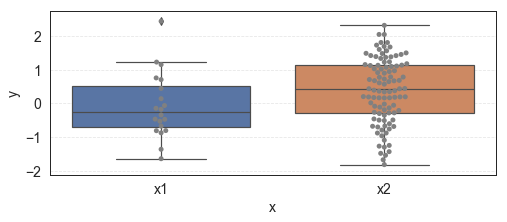

In [19]:
# statistical helpers
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.stats import kruskal
style = "mac"
def TestMedian(v1, v2, VERBOSE = False):
    test1 = [float(x) for x in v1 if not np.isnan(x)]
    test2 = [float(x) for x in v2 if not np.isnan(x)]
    if len(v1) != len(test1) or len(v2) != len(test2): # nulls found
        if VERBOSE:
            print "WARNING: NULL values found in comparison groups and ignored"
        
    if style == "pc":
        (stat, pvalue) = mannwhitneyu(test1,test2, alternative = "two-sided")
    else: #  style = "mac"
        pvalue = mannwhitneyu(test1, test2)[1] * 2 # multiply by 2 to get two-sided p-value
    (meanstat, meanpvalue) = ttest_ind(test1, test2, equal_var = False)
    if VERBOSE:
        print "Group 1: median =", str(np.median(test1)), "mean = ", str(np.mean(test1))
        print "Group 2: median =", str(np.median(test2)), "mean = ", str(np.mean(test2))
        print "Mann Whitney rank test p-value is", pvalue, "T-test p-value = ", meanpvalue
    diffMedian = np.median(test1) - np.median(test2)
    

    if diffMedian == 0:
        normDiffMedian = 0
    else:
        if np.median(test1 + test2) == 0:
            normalization = ((np.median(test1) + np.median(test2))/2.0)
        else:
            normalization = np.median(test1 +test2)
            
        normDiffMedian = diffMedian/normalization
        
    return pvalue, meanpvalue, normDiffMedian



testDF = pd.DataFrame(columns = ['y', 'x'])
x1 = np.random.normal(0,1,20)
x2 = np.random.normal(0.5,1, 100)
testDF['y'] = list(x1) + list(x2)
testDF['x'] = ['x1'] * 20 + ['x2'] * 100

sns.boxplot(y = "y", x = "x", data = testDF)
sns.swarmplot(y = "y", x = "x", data = testDF, color="gray")

#testDF
TestMedian(x1, x2, True)

## Read in Data

In [20]:
# clinical data
suppTables = "data/Supplemental_Tables.xlsx"
suppData = "data/Supplementary_Data.xlsx"

clinicalSheet = "Supplemental Table 1"

clinicalDF = pd.read_excel(suppTables, sheet_name = clinicalSheet, header=2).iloc[0:144]
clinicalDF[0:5]


,total_muts,nonsyn_muts,clonal_muts,subclonal_muts,heterogeneity,total_neoantigens,CNA_prop,"gender (Male=1, Female=0)",biopsy site,monthsBiopsyPreTx,...,postCTLA4,postMAPKTx,postCombinedCTLA_PD1,numPriorTherapies,biopsy site_categ,biopsyContext (1=Pre-Ipi; 2=On-Ipi; 3=Pre-PD1; 4=On-PD1),daysBiopsyToPD1,daysBiopsyAfterIpiStart,purity,ploidy
Patient1,34.0,22.0,12.0,10.0,0.454545,49.0,0.321417,0.0,skin,2.8,...,0.0,0.0,0,1.0,skin,3.0,-84.0,unk,0.92,1.73
Patient10,96.0,71.0,48.0,22.0,0.314286,230.0,0.391384,0.0,skin,0.4,...,1.0,1.0,0,2.0,skin,3.0,-12.0,107,0.83,1.84
Patient100,200.0,126.0,98.0,24.0,0.196721,301.0,0.029447,0.0,skin,3.1,...,0.0,0.0,0,1.0,skin,3.0,-94.0,33,0.11,2.17
Patient102,370.0,246.0,215.0,26.0,0.107884,825.0,0.169389,1.0,brain,2.1,...,0.0,0.0,0,0.0,brain,3.0,-64.0,na,0.70,3.24
Patient104,130.0,96.0,65.0,28.0,0.301075,329.0,0.206518,0.0,lymph node,1.9,...,0.0,0.0,0,0.0,lymph node,3.0,-57.0,na,0.86,4.58


In [21]:
# mutational signature data
mutsigSheet = "Mutational Sig Activity"

mutsigDF = pd.read_excel(suppData, sheet_name = mutsigSheet, header=2, index_col=0)
print mutsigDF[0:5]

mutsigDF.columns = ['UV', 'Alkylating', 'Cosmic 1+5']

                     UV    Alkylating  Cosmic 1+5 (Aging+ Signature)
Patient                                                             
Patient145   370.425028  4.268520e+00                      42.307208
Patient125    38.074134  1.037356e+01                      36.549862
Patient100   134.899883  1.269846e+01                      33.400423
Patient62   8941.997050  1.320000e-09                     354.071545
Patient204  2168.898181  9.107963e+01                     292.022232


In [22]:
# read in mutations and CNA matrix by patient -- for convenience, this has been preprocessed
geneTumorMatrixFile = "data/geneTumorMatrix.txt" # gene tumor mutation matrix

geneTumorDF = pd.read_csv(geneTumorMatrixFile, sep="\t", index_col=0, low_memory=False)

# regenerate numeric gene tumor mutation and CNA matrices
def MutType(mut):
    translateDict = {"MIS":MISSENSE_MUTATION, 
                    "INFRAME_INDEL":INFRAME_INDEL, 
                    "TRUNC":TRUNCATED_MUTATION ,
                    "MULT":MULTIPLE_MUTS }
    if mut in translateDict:
        return translateDict[mut]
    else:
        try:
            out = int(float(mut))
            return out
        except: # not a numeric type
            return mut
    
def MutType_Series(mutSeries):
    return(mutSeries.apply(MutType))

geneTumorDF = geneTumorDF.apply(MutType_Series)

geneTumorDF[0:5]

,Patient1,Patient10,Patient100,Patient102,Patient104,Patient105,Patient106,Patient107,Patient108,Patient11,...,Patient83,Patient84,Patient86,Patient87,Patient88,Patient9,Patient94,Patient96,Patient98,Patient99
A1CF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2ML1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
A3GALT2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A4GALT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# merge in clinical and DNA data 
tumorDF = clinicalDF.merge(mutsigDF, left_index=True, right_index=True)
tumorDF[0:5]

,total_muts,nonsyn_muts,clonal_muts,subclonal_muts,heterogeneity,total_neoantigens,CNA_prop,"gender (Male=1, Female=0)",biopsy site,monthsBiopsyPreTx,...,numPriorTherapies,biopsy site_categ,biopsyContext (1=Pre-Ipi; 2=On-Ipi; 3=Pre-PD1; 4=On-PD1),daysBiopsyToPD1,daysBiopsyAfterIpiStart,purity,ploidy,UV,Alkylating,Cosmic 1+5
Patient1,34.0,22.0,12.0,10.0,0.454545,49.0,0.321417,0.0,skin,2.8,...,1.0,skin,3.0,-84.0,unk,0.92,1.73,0.509426,2.514556,28.973872
Patient10,96.0,71.0,48.0,22.0,0.314286,230.0,0.391384,0.0,skin,0.4,...,2.0,skin,3.0,-12.0,107,0.83,1.84,35.883346,6.810735,42.303101
Patient100,200.0,126.0,98.0,24.0,0.196721,301.0,0.029447,0.0,skin,3.1,...,1.0,skin,3.0,-94.0,33,0.11,2.17,134.899883,12.698465,33.400423
Patient102,370.0,246.0,215.0,26.0,0.107884,825.0,0.169389,1.0,brain,2.1,...,0.0,brain,3.0,-64.0,na,0.70,3.24,281.460930,24.053939,42.484586
Patient104,130.0,96.0,65.0,28.0,0.301075,329.0,0.206518,0.0,lymph node,1.9,...,0.0,lymph node,3.0,-57.0,na,0.86,4.58,15.669807,3.587685,87.736229


In [24]:
# read in CNA matrix by patient -- for convenience, this has been preprocessed

geneTumorCNAFile = "data/CNA_Matrix.xlsx" # gene tumor cna matrix

cnaDF = pd.read_excel(geneTumorCNAFile,sheet_name = "Sheet1", header=4)

def CNAType(cna):
    translateDict = {"HDEL":HOMOZYGOUS_DEL, 
                     "AMP":AMP,
                     "HIGH_AMP":HIGH_AMP,
                     "LOH":LOH,
                     "HDEL_AMP":HOMOZYGOUS_DEL_AND_AMP
                     }
    if cna in translateDict:
        return translateDict[cna]
    else:
        try:
            out = int(float(cna))
            return out
        except: # not a numeric type
            return cna
    
def CNAType_Series(cnaSeries):
    return(cnaSeries.apply(CNAType))

cnaDF = cnaDF.apply(CNAType_Series)[tumorDF.index] # limit to the 144 tumors in our cohort

cnaDF[0:5]

,Patient1,Patient10,Patient100,Patient102,Patient104,Patient105,Patient106,Patient107,Patient108,Patient11,...,Patient83,Patient84,Patient86,Patient87,Patient88,Patient9,Patient94,Patient96,Patient98,Patient99
5S_rRNA,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,4,4,0,0,4
7SK,0,4,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,4,0,0,0
A1BG,0,0,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,4,0,0,4
A1BG-AS1,0,0,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,4,0,0,4
A1CF,4,4,0,4,4,4,4,4,0,4,...,0,0,0,0,4,0,4,4,4,0


In [25]:
# read in RNA data
allRNAFile = "data/RNA_TPM_matrix.txt.zip"
allRNADF = pd.read_csv(allRNAFile, compression='zip', sep="\t", low_memory=False,index_col=0)

allRNADF

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
Patient100,19.614242,0.826789,0.035182,504.956774,0.844380,0.228686,0.351825,8.215113,0.844380,48.340750,...,23.818550,10.695479,3.817301,3.008103,12.964750,0.527737,14.143363,204.832492,58.438126,12.947159
Patient102,20.075427,0.555721,0.208395,811.098196,0.301016,0.000000,0.000000,2.315505,0.671496,91.184581,...,18.639814,6.506569,2.639676,3.565877,13.568858,0.069465,27.786058,240.881970,36.006101,16.277999
Patient105,13.009169,0.000000,0.000000,108.481865,0.649106,0.054092,0.108184,0.567968,0.135230,20.365705,...,44.869462,7.708135,0.622060,2.028457,4.624881,0.054092,25.098771,20.014106,11.467542,33.428967
Patient106,18.363130,0.902715,0.000000,93.811126,0.095023,0.118778,0.000000,0.427602,0.118778,33.329200,...,11.664032,11.022629,1.900453,3.159504,8.528284,0.023756,19.432135,42.593910,30.169696,17.888017
Patient107,0.000000,0.000000,0.000000,540.552469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,67.725304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,377.534480,19.590340,0.000000
Patient108,0.606043,0.000000,0.000000,696.342904,0.000000,0.000000,0.000000,0.000000,0.000000,18.181277,...,54.013543,0.000000,0.000000,0.454532,13.029915,0.000000,7.575532,64.695044,45.225926,5.984670
Patient10,10.049930,0.720561,0.000000,120.257841,0.151697,0.132735,0.113773,1.365274,0.075849,69.041123,...,47.575989,25.409257,0.910182,4.171669,10.391248,0.018962,20.573913,71.676859,17.862328,14.487069
Patient112,17.782720,1.191326,0.116227,421.613176,0.464908,8.135885,0.000000,4.939644,0.000000,58.694598,...,14.063458,7.816261,2.876616,4.184169,14.121572,0.000000,10.460423,102.047241,32.398256,15.167614
Patient116,16.188170,2.197810,0.094529,175.068555,0.330853,9.263887,0.141794,2.646825,0.141794,51.518554,...,16.093640,12.147035,2.150545,5.435444,17.889700,0.094529,35.968459,45.941316,76.261640,39.962328
Patient117,16.491696,2.039296,0.044333,541.144853,0.531990,0.044333,0.000000,7.846855,0.953149,58.607586,...,14.275070,3.901261,5.009574,4.898743,13.233256,0.088665,26.466512,85.140596,41.716897,24.028223


In [26]:
# read in ssGSEA geneset scores.
# PLEASE NOTE: we are using updated data; the published supplemental data ssGSEA geneset score matrix inadvertantly
# swapped one incorrect patient in (Patient74, excluded due to being lost to followup before evaluation) excluding
# another patient (Patient154). This does not affect any of our results or figures.
suppData = "data/updated_ssGSEA_SuppData.txt"

#ssGSEASheet = "ssGSEA geneset scores"

#ssGSEADF = pd.read_excel(suppData, sheet_name = ssGSEASheet, header=5, index_col=0).iloc[0:144]
ssGSEADF = pd.read_csv(suppData, sep="\t", low_memory=False, index_col=0)

ssGSEADF

,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_HYPOXIA,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_MITOTIC_SPINDLE,HALLMARK_WNT_BETA_CATENIN_SIGNALING,HALLMARK_TGF_BETA_SIGNALING,HALLMARK_IL6_JAK_STAT3_SIGNALING,HALLMARK_DNA_REPAIR,HALLMARK_G2M_CHECKPOINT,HALLMARK_APOPTOSIS,...,HALLMARK_BILE_ACID_METABOLISM,HALLMARK_PEROXISOME,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_SPERMATOGENESIS,HALLMARK_KRAS_SIGNALING,HALLMARK_KRAS_SIGNALING_UP,HALLMARK_KRAS_SIGNALING_DN,HALLMARK_PANCREAS_BETA_CELLS,MHC-II,MHC-I
Patient,,,,,,,,,,,,,,,,,,,,,
Patient100,5422.435436,5001.924014,5721.707420,7111.046499,3060.292989,6665.759662,5968.491840,5799.624896,6573.391247,6659.434239,...,913.443386,4154.466561,6301.695257,-1183.819749,7105.085642,3195.193487,-3909.892155,-2631.782820,8461.527666,10129.761060
Patient102,4202.203354,4862.214887,5648.355798,6908.895114,2731.219604,6437.957173,3458.484236,6506.855348,6284.102576,5836.103042,...,1655.110278,4617.992888,2991.277980,-193.966307,6988.663711,2359.337054,-4629.326657,-2574.392044,4007.311639,8547.668246
Patient105,1825.359153,3110.710561,4727.126230,6676.203045,2756.320798,5744.613141,852.223641,6302.885659,6752.716469,4895.787767,...,1254.684635,4183.290015,1153.913428,801.431446,3836.022559,-325.105652,-4161.128211,-708.609764,258.028319,8490.758593
Patient106,3565.586187,4398.270065,6052.714836,7099.903004,2561.766824,5592.356905,3231.155643,6793.051743,7034.419273,5861.126846,...,1698.986120,5060.511178,3713.884121,238.430216,6089.630966,1880.215850,-4209.415116,-756.167493,7088.019106,9856.637858
Patient107,2703.734554,3902.681208,5036.519997,5682.658377,3393.076646,5186.988728,3407.460021,4946.812481,5297.331396,5038.246375,...,2358.916963,3279.716056,3050.486265,1748.808586,2668.152207,1925.084404,-743.067804,2136.398930,709.016789,7550.991794
Patient108,2399.397879,3820.530848,4226.797378,5419.924568,1734.685595,4608.285091,2117.753229,5335.670297,5530.426778,4688.439492,...,1443.537938,3577.357560,2302.733689,656.060019,3330.338382,571.860884,-2758.477497,454.267336,2075.389113,8172.259968
Patient10,3206.814666,4346.967655,5812.833174,7297.609827,2355.233268,6171.979656,3330.684170,6894.337896,7447.672321,5443.478641,...,433.784348,4454.789773,3368.016971,326.928175,5853.784648,1500.226366,-4353.558282,-980.695903,5649.411609,9120.478875
Patient112,4792.900728,4907.470348,6336.974391,7072.783846,3691.381672,6377.626155,3292.983984,6659.899223,6735.540363,6015.282101,...,1443.871338,4280.805171,3964.253529,-899.008206,4652.367911,1967.503445,-2684.864466,-2694.440635,7352.588830,10155.816490
Patient116,2867.897700,4554.821691,5975.883741,7328.564219,3152.946797,6328.675419,2159.421278,6250.771317,6942.895258,5453.141758,...,1309.756222,4296.637116,1730.765597,297.701420,4340.897629,1302.752284,-3038.145345,-1923.784233,4106.038078,8636.896803


In [27]:
# read in cibersort immune infiltrate file
suppData = "data/Supplementary_Data.xlsx"

immuneSheet = "Immune Cell Sig Activity"

csDF = pd.read_excel(suppData, sheet_name = immuneSheet, header=3, index_col=0).iloc[0:144]

csDF.columns = [x.replace(' (Total Immune Infiltrate)','') for x in csDF.columns] # remove extraneous text
csDF

,SC B.CELL,SC MACROPHAGE,SC T.CD4,SC T.CD8,SC T.CELL,SC IMMUNE,SC T.CD4.EXHAUSTED,SC T.CD4.TREG,SC T.CD8.CYTOTOXIC,SC T.CD8.EXHAUSTED,...,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils,Absolute score
Patient,,,,,,,,,,,,,,,,,,,,,
Patient145,-0.047717,0.452672,-0.036829,0.542359,0.021497,0.336053,0.236749,0.251195,0.610566,0.407237,...,0.004026,0.023197,0.855206,0.387417,0.007204,0.237892,0.000000,0.000000,0.000000,2.130848
Patient125,1.538990,0.899425,1.536833,2.685226,2.930798,2.802738,1.202406,1.088679,2.980200,1.284827,...,0.129065,0.223092,0.396972,0.000000,0.000000,0.251061,0.000000,0.000000,0.000000,4.846815
Patient100,0.664650,1.407652,1.133326,1.893131,2.278451,2.382147,0.937618,0.926039,2.713152,0.986713,...,0.149859,0.372256,1.105530,0.062266,0.000000,0.439169,0.000000,0.000000,0.000000,6.891536
Patient62,-0.173207,0.391146,-0.073797,-0.126863,-0.028295,0.220372,-0.000282,0.454664,-0.109767,-0.050628,...,0.525642,0.138593,1.157017,0.000000,0.000000,0.000000,0.117840,0.000000,0.000000,2.688479
Patient204,-0.268652,-0.068431,-0.058755,-0.243574,-0.070162,-0.158961,-0.128931,0.053184,0.251359,-0.129692,...,0.204394,0.184689,0.328678,0.012985,0.000000,0.149803,0.000000,0.000000,0.000000,2.097300
Patient75,0.620950,0.531409,0.596339,0.974441,1.134448,1.059769,0.367810,0.402655,1.674089,0.483320,...,0.094653,0.412362,0.715788,0.027523,0.000000,0.509235,0.000000,0.000000,0.000000,3.291105
Patient15,0.084953,0.119669,0.307560,0.853093,0.637043,0.512096,0.242795,0.321756,0.916045,0.374563,...,0.055349,0.089795,0.430288,0.043898,0.000000,0.575755,0.000000,0.000000,0.000000,2.589683
Patient148,0.044982,0.231789,-0.410507,-0.283509,-0.333960,-0.023049,-0.117148,-0.222806,-0.349451,-0.187291,...,0.154282,0.007376,0.338339,0.007078,0.000000,0.163787,0.000000,0.008298,0.000000,0.841693
Patient132,1.620686,0.677818,1.049599,0.876442,1.100495,1.339691,0.402958,0.526345,0.675138,0.444852,...,0.296689,0.172327,0.698843,0.000000,0.000000,0.171968,0.000000,0.000000,0.000000,4.519801


In [28]:
# generate subset of RNAseq features
nanostringFile = 'data/nanostring_genes.txt'
nanostringGenes = list(pd.read_csv(nanostringFile,sep="\t",low_memory=False, header=None)[0])
mangusoGeneFile = 'data/manguso_genes.txt'
mangusoGenes = list(pd.read_csv(mangusoGeneFile,sep="\t",low_memory=False, header=None)[0])

genes = ['PRF1', 'GZMA', 'CD8A', 'IFNG', 'HLA-A', 'HLA-B', 'HLA-C', 'B2M', 'CD274', 'PDCD1LG2',
         'PDCD1', 'CDKN2A', 'CDKN2B', 'FOXP3', 'TGFB1', 'ARG1', 'IDO1', 'IL12A', 
         'NOS2', 'JAK1', 'JAK2', 'STAT1', 'STAT2', 'STAT3', 'CXCL9', 'CXCL10', 'CXCR3', 'VEGFA', 'CSF3',
         'IL1A', 'IL1B', 'IL6', 'IL17A', 'CXCL1', 'IL2', 'LDHA']
TRegs = ['CD4', 'FOXP3', 'CTLA4', 'ICOS', 'TNFRSF18']
exhausted = ['TCF7']
activated = ['IL2RA', 'GZMK']
ifna = ['IFNA1', 'IFNA2', 'IFNA4', 'IFNA4', 'IFNA5', 'IFNA6', 'IFNA7', 'IFNA8', 'IFNA10', 'IFNA13', 'IFNA14',
      'IFNA16', 'IFNA17', 'IFNA21', 'IRF9', 'MX1', 'OAS3', 'SYK', 'PTK2B', 'USP18', 'PTPN11', 'TYK2',
       'IRF1', 'SOCS1', 'SOCS3', 'SIN3A']
ifn_inhibit = ['IL1A', 'IL1B', 'CSNK2A1', 'CSNK2A2']
ifng = ['IFNGR1', 'IFNAR1', 'IL15', 'IFNAR2', 'IFNGR2']
mhc2 = ['HLA-DMA', 'HLA-DMB', 'HLA-DOA', 'HLA-DOB', 'HLA-DPA1', 'HLA-DPB1', 
        'HLA-DQA1', 'HLA-DQA2', 'HLA-DQB1', 'HLA-DQB2', 'HLA-DRA', 'HLA-DRB1', 
        'HLA-DRB5']
chkpt = ['LAG3', 'HAVCR2', 'TNFRSF18', 'TNFRSF4', 'CTLA4', 'RGMB']
nk = ['TIGIT', 'KLRD1', 'NCAM1']
gamma_delta = ['TRDC']
cytokines = ['TNF', 'IFNB1']
glycolysis = ['PKM', 'GAPDH','CD44','ERO1B','GALE','GNE','NSDHL']
nad = ['NAMPT','NADK']
ppp = ['SHPK']
hypoxia = ['HIF1A']
faOxidation = ['IL4', 'STAT6', 'PPARGC1B', 'CPT1A']
aa = ['SLC1A5', 'NOS2', 'ARG1', 'IDO1']
apc = ['TAP1', 'TAP2', 'IFNAR1', 'NLRC5']
mapk = ['DUSP6', 'NF1', 'SPRED1', 'SPOP','RASA2']
nfkb = ['RELA', 'IKBKB', 'RNF31', 'OTULIN','SHARPIN', 'CFLAR']
mtorc1 = ['RRAGA','RRAGC','LAMTOR1']
pbaf = ['ARID2','PBRM1','BRD7']
wntDownstream = ['EFNB3','APC2','TCF7','MYC', 'TCF12', 'VEGFA']
melanoma = ['MITF', 'AXL']
EMT = ['CDH1', 'VIM', 'FN1', 'CDH2']
nerveGrowthFactor = ['NGFR']
melanoma_antigen = ['MAGEA1', 'MAGEA2B', 'MAGEA3', 'MAGEA4', 'MAGEA5', 'MAGEA6', 'MAGEA7P',
                   'MAGEA8', 'MAGEA9', 'MAGEA10', 'MAGEA11', 'MAGEA12']
otherGenes = ['TRIM22', 'TRIM38', 'IL32','SPATS2L','EPHA3','HERC3','ADAM19','SERPINB9',
         'IFI44L','F3','BEND6','AIG1','MSRB2','TNFRSF9','ANTXR1', 'TP53', 'PTPN14', 'PTPN7', 'SERPINA5', 'AXIN1']
erv = ['ERV3-1', 'DDX58', 'DHX58','IFIH1']
ldha = ['MYC', 'FOXM1', 'KLF4', 'ERBB2', 'HSF1', 'FGFR1', 'SIRT2']
angiogenesis = ['RASIP1', 'ARHGAP29', 'RHOA', 'ROCK1', 'CDC42', 'RAC1']

genes = list(set(genes + TRegs + exhausted + ifn_inhibit + ifna + ifng + mhc2 
            + chkpt + nk + gamma_delta + activated + cytokines + glycolysis
            + ppp + hypoxia + faOxidation + aa + apc + erv + ldha + nad + mapk + nfkb + mtorc1 + pbaf
                + wntDownstream + melanoma + EMT + angiogenesis + nerveGrowthFactor+ mangusoGenes
                + melanoma_antigen + nanostringGenes))

genes = [x for x in genes if x in allRNADF.columns]

rnaDF = allRNADF[genes]

print len(genes)

862


## Process Data

In [29]:
# generate response groups

responderCrit = tumorDF['BR'].isin(['CR','PR'])
progressorCrit = tumorDF['BR'].isin(['PD'])

responders = tumorDF[responderCrit].index
progressors = tumorDF[progressorCrit].index
nonresponders = tumorDF[~responderCrit].index
nonprogressors = tumorDF[~progressorCrit].index
print len(responders),"responders"
print len(progressors),"progressors"

tumorDF.loc[responders,"PD vs Responder"] = 'Responder'
tumorDF.loc[progressors,"PD vs Responder"] = 'Progressor'

tumorDF.loc[responders,"Responder"] = 1
tumorDF.loc[progressors,"Responder"] = 0

tumorDF["PD vs nonPD"] = 'nonPD'
tumorDF.loc[progressors,"PD vs nonPD"] = 'PD'

comparisonGroups = [
    'PD vs Responder',
    'PD vs nonPD',
]

tumorDF['Responder'].value_counts()



55 responders
65 progressors


0.0    65
1.0    55
Name: Responder, dtype: int64

In [30]:
# generate response groups stratified by prior ipilimumab treatment status
# Generate a category for allRNADF to compare nonresponders (ipi-experienced) vs nonresponders (ipi-naive)
ipiTreated = pd.to_numeric(tumorDF['daysBiopsyAfterIpiStart'], errors = 'coerce')
postIpi = list(ipiTreated.loc[ipiTreated>0].index)
preIpi = list(ipiTreated.loc[ipiTreated<=0].index)
noIpi = list(tumorDF.loc[tumorDF['daysBiopsyAfterIpiStart']=='na'].index)

print "Total pre-ipi patients:", len(preIpi)
print "Total post-ipi patients:", len(postIpi)
print "Total ipi-naive patients:", len(noIpi)

PDpostIpi = list(set(postIpi).intersection(set(progressors)))
PDnoIpi = list(set(noIpi).intersection(set(progressors)))
RpostIpi = list(set(postIpi).intersection(set(responders)))
RnoIpi = list(set(noIpi).intersection(set(responders)))
nPDpostIpi = [x for x in postIpi if x not in progressors] 
nPDnoIpi = [x for x in noIpi if x not in progressors] 

print "Total", len(progressors), "PD patients"
print len(PDpostIpi), 'post ipi PD patients'
print len(PDnoIpi), 'ipi naive PD patients'

print len(postIpi), "Total ipi-exp patient biopsies"
print len(PDpostIpi), "PD ipi-exp patients"
print len(nPDpostIpi), 'nPD ipi-exp patients'

print len(noIpi), "Total ipi-naive patients"
print len(PDnoIpi), "PD ipi-naive patients"
print len(nPDnoIpi), 'nPD ipi-naive patients'

print "Total", len(responders), "responder patients"
print len(RpostIpi), 'post ipi R patients'
print len(RnoIpi), 'ipi naive R patients'


Total pre-ipi patients: 14
Total post-ipi patients: 45
Total ipi-naive patients: 84
Total 65 PD patients
20 post ipi PD patients
37 ipi naive PD patients
45 Total ipi-exp patient biopsies
20 PD ipi-exp patients
25 nPD ipi-exp patients
84 Total ipi-naive patients
37 PD ipi-naive patients
47 nPD ipi-naive patients
Total 55 responder patients
16 post ipi R patients
34 ipi naive R patients


In [31]:
# generate additional columns
tumorDF['log nonsyn mutload'] = [math.log(x,10) for x in tumorDF['nonsyn_muts']]
tumorDF['log clonal mutload'] = [math.log(x,10) for x in tumorDF['clonal_muts']]
tumorDF['log subclonal mutload'] = [math.log(x,10) for x in tumorDF['subclonal_muts']]
tumorDF['log neoantigens'] = [math.log(x,10) for x in tumorDF['total_neoantigens']]

# add additional category
tumorDF.loc[tumorDF.index, 'Primary_Type_Categ'] = "Skin or Occult"
mucosalCrit = tumorDF['Primary_Type'] == "mucosal"
acralCrit = tumorDF['Primary_Type'] == "acral"
tumorDF.loc[mucosalCrit | acralCrit, 'Primary_Type_Categ'] = "Mucosal or Acral"

# add dominant mutational signature
uvDom = (tumorDF['UV'] > tumorDF['Alkylating']) & (tumorDF['UV'] > tumorDF['Cosmic 1+5'])
alkDom = (tumorDF['Alkylating'] > tumorDF['UV']) & (tumorDF['Alkylating'] > tumorDF['Cosmic 1+5'])
otherDom = (tumorDF['Cosmic 1+5'] > tumorDF['Alkylating']) & (tumorDF['Cosmic 1+5'] > tumorDF['UV'])

print sum(uvDom), "tumors with dominant UV signature"
print sum(alkDom), "tumors with dominant alkylating signature"
print sum(otherDom), "tumors with dominant other (aging + others) signature"

# add to tumorDF
tumorDF.loc[uvDom,"Dominant MutSig"] = 'UV'
tumorDF.loc[alkDom,"Dominant MutSig"] = 'Alkylating'
tumorDF.loc[otherDom,'Dominant MutSig'] = 'Other'

100 tumors with dominant UV signature
4 tumors with dominant alkylating signature
40 tumors with dominant other (aging + others) signature


In [32]:
# generate amplified tumors for HLA MHC-I genes and TAP2

ampTumors= {}

ampGenes = ['HLA-A', 'HLA-B', 'HLA-C', 'TAP2']

for gene in ampGenes:
    tmp = cnaDF.loc[gene].isin([AMP, HIGH_AMP])
    ampTumors[gene] = list(tmp[tmp].index)

# add additional amp genes
ampTumors['MHC-I HLA'] = set(ampTumors['HLA-A']).intersection(\
                     set(ampTumors['HLA-B']).intersection(\
                     set(ampTumors['HLA-C'])))
ampTumors['MHC-I HLA']

# add additional features to tumorDF
tumorDF['MHC-I amp'] = 0
tumorDF.loc[ampTumors['MHC-I HLA'],'MHC-I amp'] = 1

tumorDF['TAP2 amp'] = 0
tumorDF.loc[ampTumors['TAP2'],'TAP2 amp'] = 1


In [33]:
print set(rnaDF.index) - set(ssGSEADF.index)
print set(ssGSEADF.index) - set(rnaDF.index)

set([])
set([])


In [34]:
# generate "full" matrix with tumors with DNA and RNA features available
fullDF = tumorDF.join(rnaDF, how='inner').join(csDF, how='inner').join(ssGSEADF, how='inner')
fullDF

,total_muts,nonsyn_muts,clonal_muts,subclonal_muts,heterogeneity,total_neoantigens,CNA_prop,"gender (Male=1, Female=0)",biopsy site,monthsBiopsyPreTx,...,HALLMARK_BILE_ACID_METABOLISM,HALLMARK_PEROXISOME,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_SPERMATOGENESIS,HALLMARK_KRAS_SIGNALING,HALLMARK_KRAS_SIGNALING_UP,HALLMARK_KRAS_SIGNALING_DN,HALLMARK_PANCREAS_BETA_CELLS,MHC-II,MHC-I
Patient1,34.0,22.0,12.0,10.0,0.454545,49.0,0.321417,0.0,skin,2.800000,...,767.293525,4551.836628,2389.754802,41.038211,4024.098414,242.554335,-3781.544079,-185.910315,6293.852766,9142.030678
Patient10,96.0,71.0,48.0,22.0,0.314286,230.0,0.391384,0.0,skin,0.400000,...,433.784348,4454.789773,3368.016971,326.928175,5853.784648,1500.226366,-4353.558282,-980.695903,5649.411609,9120.478875
Patient100,200.0,126.0,98.0,24.0,0.196721,301.0,0.029447,0.0,skin,3.100000,...,913.443386,4154.466561,6301.695257,-1183.819749,7105.085642,3195.193487,-3909.892155,-2631.782820,8461.527666,10129.761060
Patient102,370.0,246.0,215.0,26.0,0.107884,825.0,0.169389,1.0,brain,2.100000,...,1655.110278,4617.992888,2991.277980,-193.966307,6988.663711,2359.337054,-4629.326657,-2574.392044,4007.311639,8547.668246
Patient105,185.0,125.0,85.0,23.0,0.212963,334.0,0.394306,0.0,skin,0.700000,...,1254.684635,4183.290015,1153.913428,801.431446,3836.022559,-325.105652,-4161.128211,-708.609764,258.028319,8490.758593
Patient106,380.0,245.0,194.0,36.0,0.156522,726.0,0.224147,0.0,skin,2.500000,...,1698.986120,5060.511178,3713.884121,238.430216,6089.630966,1880.215850,-4209.415116,-756.167493,7088.019106,9856.637858
Patient107,247.0,158.0,133.0,20.0,0.130719,489.0,0.144822,1.0,adrenal gland,4.400000,...,2358.916963,3279.716056,3050.486265,1748.808586,2668.152207,1925.084404,-743.067804,2136.398930,709.016789,7550.991794
Patient108,69.0,45.0,31.0,14.0,0.311111,189.0,0.125993,1.0,lymph node,0.600000,...,1443.537938,3577.357560,2302.733689,656.060019,3330.338382,571.860884,-2758.477497,454.267336,2075.389113,8172.259968
Patient11,246.0,172.0,131.0,35.0,0.210843,560.0,0.238964,0.0,skin,0.300000,...,1276.720887,4258.161630,3340.899960,-378.082449,6045.366836,1690.109987,-4355.256850,-1402.424832,5775.793694,8968.494324
Patient112,348.0,241.0,188.0,47.0,0.200000,947.0,0.347156,0.0,skin,5.900000,...,1443.871338,4280.805171,3964.253529,-899.008206,4652.367911,1967.503445,-2684.864466,-2694.440635,7352.588830,10155.816490


## Figure 1

[(0.95, 0.95, 0.95, 1.0), '#FFD700', '#FF7256', '#EEDFCC']


(0.0, 1.0, 0.0, 1.0)

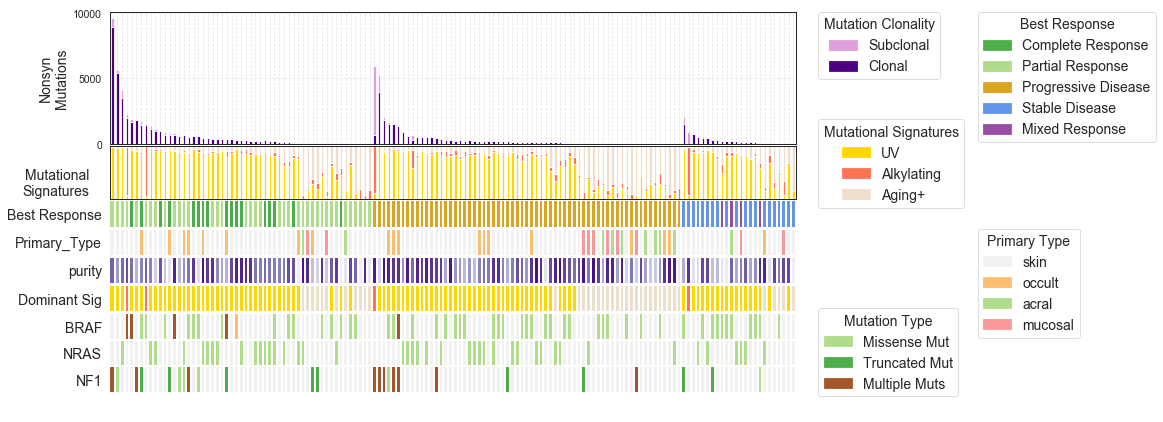

In [35]:
# Generate Figure 1: Comut plot + additional data
geneList = ['BRAF', 'NRAS', 'NF1']

order = tumorDF.sort_values(by=['Responder', 'nonsyn_muts'], ascending=False).index
groupDF = pd.DataFrame(columns = order)
groupDF.loc['Best Response'] = tumorDF.loc[order,'BR'].map({'CR':1,'PR':2,'SD':3,'PD':4,'MR':5,'unknown':0})

groupDF.loc['Primary_Type'] = tumorDF.loc[order,'Primary_Type'].map({'skin':0,'occult':1,'acral':2,'mucosal':3,'uveal':4})
groupDF.loc['Dominant MutSig'] = tumorDF.loc[order,'Dominant MutSig'].map({'UV':0,'Alkylating':1,'Other':2})

graphDF = geneTumorDF.loc[geneList, order]
mutload = tumorDF.loc[order,'nonsyn_muts']
geneSet = geneList


numGenes = len(geneSet)
    
#Now graph the comut plots
fig = plt.figure(figsize = (18,7))
sizeAdj = 0.7


nrows = 7
height_ratios = [5,2,1,1,1,1,1*len(geneSet)]
ncols = 3
    
gs = gridspec.GridSpec(nrows,ncols, height_ratios = height_ratios, width_ratios = [5,1,1], 
                           wspace=0.1 * sizeAdj, hspace = 0.05* sizeAdj)
    
coMutPlot = plt.subplot(gs[6,0])

numGenes = len(geneList)
cax = CreateCoMutFig(coMutPlot, graphDF.iloc[numGenes::-1], [ALT_COLORS[x] for x in range(0,10)])
plt.setp(coMutPlot.get_yticklabels(), size=20 * sizeAdj) 

#generate response plot
groupPlot = plt.subplot(gs[2,0], sharex = coMutPlot)
CreateCoMutFig(groupPlot, groupDF.loc[['Best Response']].astype(int), [GRAY, CR_COL, PR_COL, SD_COL, PD_COL, MR_COL])
plt.setp(groupPlot.get_xticklabels(), visible = False) # suppress x labels
plt.setp(groupPlot.get_yticklabels(), size=20 * sizeAdj) 

#generate primary tumor type
groupPlot = plt.subplot(gs[3,0], sharex = coMutPlot)
CreateCoMutFig(groupPlot, groupDF.loc[['Primary_Type']].astype(int), [GRAY, LIGHT_ORANGE, LIGHT_GREEN, PINK, BLUE, LIGHT_BLUE])
plt.setp(groupPlot.get_xticklabels(), visible = False) # suppress x labels
plt.setp(groupPlot.get_yticklabels(), size=20 * sizeAdj) 

#generate purity/ploidy row
purityPlot = plt.subplot(gs[4,0], sharex = coMutPlot)
graphDF = tumorDF.loc[order,['purity', 'ploidy']]
CreateCoMutFig(purityPlot, graphDF.loc[order,['purity']].transpose(), cmap=plt.get_cmap("Purples"))
plt.setp(purityPlot.get_xticklabels(), visible = False) # suppress x labels
plt.setp(purityPlot.get_yticklabels(), size=20 * sizeAdj) 

#generate primary mutational signature type
domMutSigPlot = plt.subplot(gs[5,0], sharex=coMutPlot)
CreateCoMutFig(domMutSigPlot, groupDF.loc[['Dominant MutSig']].astype(int), [Colormap('UV'), Colormap('Alkylating'), Colormap('Cosmic 1+5')])

plt.setp(domMutSigPlot.get_xticklabels(), visible = False) # suppress x labels
plt.setp(domMutSigPlot.get_yticklabels(), size=20 * sizeAdj) 
domMutSigPlot.set_yticklabels(['Dominant Sig'])

#generate the mutational load on top
mutLoadBarPlot = plt.subplot(gs[0,0], sharex = coMutPlot)
PlotStackedBarPlot(mutLoadBarPlot, tumorDF.loc[order, ['clonal_muts','subclonal_muts']].transpose(), 
                   colorList = [GRAY, Colormap('Clonal Mut'), Colormap('Subclonal Mut')],
                   normalize=False, legendSize = 0) 
mutLoadBarPlot.set_ylabel("Nonsyn\nMutations", fontsize=20 * sizeAdj)
plt.setp(mutLoadBarPlot.get_yticklabels(), size=15 * sizeAdj) 
plt.ticklabel_format(style='plain', axis='y')

# generate the mutation signatures
mutSigPlot = plt.subplot(gs[1,0], sharex = coMutPlot)
sigs = ['UV', 'Alkylating', 'Cosmic 1+5']
print [GRAY] + [Colormap(x) for x in sigs]
PlotStackedBarPlot(mutSigPlot, tumorDF.loc[order, sigs].transpose(),
                   colorList = [GRAY] + [Colormap(x) for x in sigs],
                   normalize=True, legendSize=0)
plt.ylim(0,1)
plt.setp(mutSigPlot.get_yticklabels(), visible = False) # suppress ytick labels
mutSigPlot.set_ylabel("Mutational\nSignatures", size=20 * sizeAdj, rotation=0, horizontalalignment='right')
mutSigPlot.yaxis.set_label_coords(-0.03,0)

# generate the legend
# create patches
SUBCLONAL_patch = mpatches.Patch(color=Colormap('Subclonal Mut'), label='Subclonal')
CLONAL_patch = mpatches.Patch(color=Colormap('Clonal Mut'), label='Clonal')

MISSENSE_patch = mpatches.Patch(color=ALT_COLORS[MISSENSE_MUTATION], label='Missense Mut')
TRUNCATED_patch = mpatches.Patch(color=ALT_COLORS[TRUNCATED_MUTATION], label='Truncated Mut')
MULT_MUT_patch = mpatches.Patch(color=ALT_COLORS[MULTIPLE_MUTS], label='Multiple Muts')

SKIN_patch = mpatches.Patch(color=GRAY, label='skin')
OCCULT_patch = mpatches.Patch(color=LIGHT_ORANGE, label='occult')
ACRAL_patch = mpatches.Patch(color=LIGHT_GREEN, label='acral')
MUCOSAL_patch = mpatches.Patch(color=PINK, label='mucosal')

PD_patch = mpatches.Patch(color=PD_COL, label="Progressive Disease")
SD_patch = mpatches.Patch(color=SD_COL, label="Stable Disease")
PR_patch = mpatches.Patch(color=PR_COL, label="Partial Response")
CR_patch = mpatches.Patch(color=CR_COL, label="Complete Response")
MR_patch = mpatches.Patch(color=MR_COL, label="Mixed Response")
unk_patch = mpatches.Patch(color=GRAY, label="Unknown Response")

UV_patch = mpatches.Patch(color=Colormap("UV"), label='UV')
ALKYLATING_patch = mpatches.Patch(color=Colormap("Alkylating"), label='Alkylating')
OTHER_patch = mpatches.Patch(color=Colormap("Cosmic 1+5"), label='Aging+')

#groupDF.loc['Primary_Type'] = tumorDF.loc[order,'Primary_Type'].map({'skin':0,'occult':1,'acral':2,'mucosal':3,'uveal':4})

#Mutload legend
curPlot = plt.subplot(gs[0,1])
legend = curPlot.legend(handles = [SUBCLONAL_patch, CLONAL_patch], title = "Mutation Clonality",
              prop = {'size':20 * sizeAdj}, bbox_to_anchor=(0,1), loc="upper left", borderaxespad=0.)
plt.setp(legend.get_title(),fontsize=20 * sizeAdj)
plt.axis("off")

#Mutation legend
curPlot = plt.subplot(gs[6, 1])
legend = curPlot.legend(handles = [MISSENSE_patch, TRUNCATED_patch, MULT_MUT_patch], title = "Mutation Type",
                prop = {'size':20 * sizeAdj}, bbox_to_anchor=(0,-0.05), loc="lower left", borderaxespad=0.)
plt.setp(legend.get_title(),fontsize=20 * sizeAdj)
plt.axis("off")

#Primary type legend
curPlot = plt.subplot(gs[3,2])
legend = curPlot.legend(handles = [SKIN_patch, OCCULT_patch, ACRAL_patch, MUCOSAL_patch], title="Primary Type",
              prop = {'size':20* sizeAdj}, bbox_to_anchor=(0,1), loc="upper left", borderaxespad=0.)
plt.setp(legend.get_title(),fontsize=20* sizeAdj)
plt.axis("off")
plt.setp(coMutPlot.get_xticklabels(), visible = False)

#Response legend
curPlot = plt.subplot(gs[0,2])
legend = curPlot.legend(handles = [CR_patch,PR_patch,PD_patch, SD_patch,   MR_patch], title="Best Response",
              prop = {'size':20* sizeAdj}, bbox_to_anchor=(0,1), loc="upper left", borderaxespad=0.)
plt.setp(legend.get_title(),fontsize=20* sizeAdj)
plt.axis("off")
plt.setp(coMutPlot.get_xticklabels(), visible = False)

#Mutational Signatures legend
curPlot = plt.subplot(gs[1, 1])
legend = curPlot.legend(handles = [UV_patch, ALKYLATING_patch, OTHER_patch], title = "Mutational Signatures",
                prop = {'size':20* sizeAdj}, bbox_to_anchor=(0,1.5), loc="upper left", borderaxespad=0.)
plt.setp(legend.get_title(),fontsize=20* sizeAdj)
plt.axis("off")

    

PD vs Responder
log nonsyn mutload
Responder vs. Progressor:
Group 1: median = 2.57403126773 mean =  2.48726021975
Group 2: median = 2.30535136945 mean =  2.27084087529
Mann Whitney rank test p-value is 0.0258838082241 T-test p-value =  0.0615537973014
Progressor vs SD/MR:
Group 1: median = 2.30535136945 mean =  2.27084087529
Group 2: median = 2.3152393631 mean =  2.28844038023
Mann Whitney rank test p-value is 0.735774600782 T-test p-value =  0.892277924903
Responder vs SD/MR:
Group 1: median = 2.57403126773 mean =  2.48726021975
Group 2: median = 2.3152393631 mean =  2.28844038023
Mann Whitney rank test p-value is 0.14270534086 T-test p-value =  0.160936020942


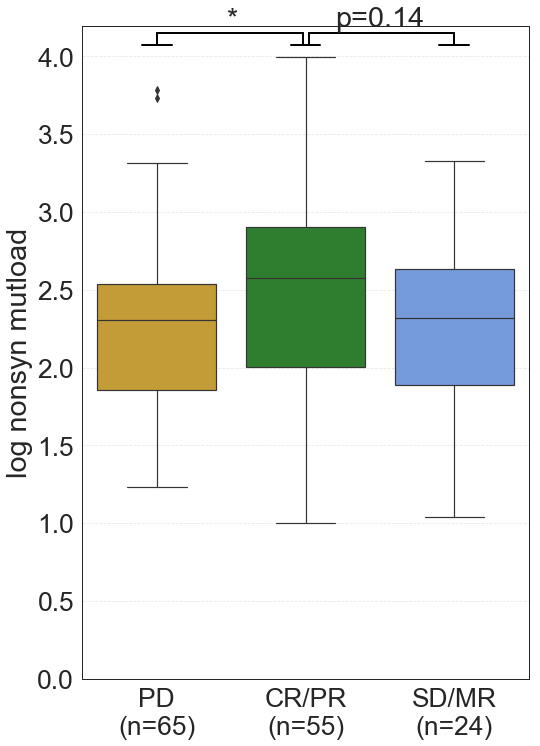

In [36]:
# Fig 1b -- Responders vs. Progressors vs. Mixed  
comparisonGroups = [
    'PD vs Responder',
    'PD vs nonPD',
]

group = "PD vs Responder"

cohort = ~tumorDF[group].isnull()
cohort = tumorDF.index
comparators = [
            'log nonsyn mutload',
                ]

ncols = len(comparators)
nrows = 1
gs = gs = gridspec.GridSpec(nrows,ncols, #height_ratios = [1, ], width_ratios = [1,1,1], 
                       wspace=0.4, hspace = 0.4)

fig = plt.figure(figsize=(8*ncols,12))
sns.set_context("paper",font_scale=3)
print group

i = 0
for comparator in comparators:
    ax = plt.subplot(gs[i])
    if tumorDF.loc[cohort, comparator].dtype == object: # not numeric
        graphDF = tumorDF[cohort][~(tumorDF.loc[cohort][comparator] == "unknown")][[group,comparator]]
        print "WARNING: not all values are numeric; ignoring and proceeding"
    else:
        graphDF = tumorDF.loc[cohort, [group,comparator]]
    graphDF[comparator] = [float(x) for x in graphDF[comparator]]

    # Generate response
    if group == "PD vs Responder":
        responder = graphDF[group]=="Responder"
        nonresponder = graphDF[group] == "Progressor"
        SDorMR = ~(responder | nonresponder)
        categories = ['PD\n(n='+str(sum(nonresponder))+')', 
                      'CR/PR\n(n='+str(sum(responder))+")",
                      'SD/MR\n(n='+str(sum(SDorMR))+")"
                     ]
        graphDF.loc[responder,'Response'] = categories[1]
        graphDF.loc[nonresponder,'Response'] = categories[0]
        graphDF.loc[graphDF['Response'].isnull(),'Response'] = categories[2]
    elif group == "PD vs nonPD":
        responder = graphDF[group]=="nonPD"
        nonresponder = graphDF[group] == "PD"
        graphDF.loc[responder,'Response'] = 'nonPD'
        graphDF.loc[nonresponder,'Response'] = 'PD'
        categories = ['PD', 'nonPD']

#    print graphDF
    sns.boxplot(x="Response", y=comparator, data=graphDF, order=[categories[0], categories[1], categories[2]], 
                palette=[NRESPONDER_COL,RESPONDER_COL, SD_COL])
    plt.ylim(0,max(graphDF[comparator])*1.05)
    plt.xlabel("")

    print comparator
    print "Responder vs. Progressor:"
    pval = TestMedian(graphDF.loc[responder,comparator], graphDF.loc[nonresponder,comparator], VERBOSE=True)[0]

    print "Progressor vs SD/MR:"
    TestMedian(graphDF.loc[nonresponder,comparator], graphDF.loc[SDorMR,comparator], VERBOSE=True)[0]

    print "Responder vs SD/MR:"
    pval2 = TestMedian(graphDF.loc[responder,comparator], graphDF.loc[SDorMR,comparator], VERBOSE=True)[0]

    # plot the significance comparison
    sig = "NS"
    if pval <= 0.15:
        sig = 'p=' + "{:.2f}".format(pval)
    if pval <= 0.05:
        sig = "*"
    if pval <= 0.01:
        sig = "**"
    if pval <= 0.001:
        sig = "***"
    
    sig2 = "NS"
    if pval2 <= 0.15:
        sig2 = 'p=' + "{:.2f}".format(pval2)
    if pval2 <= 0.05:
        sig2 = "*"
    if pval2 <= 0.01:
        sig2 = "**"
    if pval2 <= 0.001:
        sig2 = "***"
    
    
    yMax = graphDF[comparator].max()
    plt.plot([-0.1,0.1], [yMax * 1.02,yMax * 1.02], lw=2, color="black")
    plt.plot([0,0],[yMax * 1.02, yMax * 1.04], lw=2, color="black")
    plt.plot([0,0.98], [yMax * 1.04,yMax * 1.04], lw=2, color="black")
    plt.plot([0.98,0.98],[yMax * 1.02, yMax * 1.04], lw=2, color="black")
    plt.plot([0.9,1.1], [yMax * 1.02,yMax * 1.02], lw=2, color="black")
    plt.plot([1.02,1.02], [yMax * 1.02,yMax * 1.04], lw=2, color="black")
    plt.plot([1.02,2], [yMax * 1.04,yMax * 1.04], lw=2, color="black")
    plt.plot([2,2],[yMax * 1.02, yMax * 1.04], lw=2, color="black")
    plt.plot([1.9,2.1], [yMax * 1.02,yMax * 1.02], lw=2, color="black")

  
    plt.text(0.5,yMax * 1.05,sig, ha='center')
    plt.text(1.5,yMax * 1.05,sig2, ha='center')

    i+=1
    

Overall Kruskal-Wallis p = 2.41348092345e-05


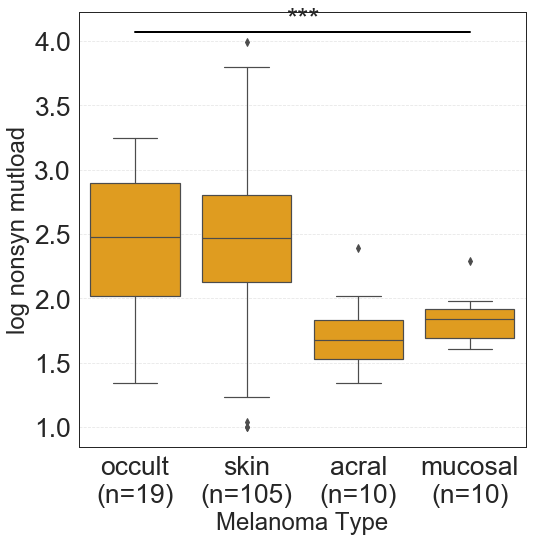

In [37]:
# Fig 1c - Examine characteristics of different primary types with continuous variables
groups = "BR"
cohort = tumorDF.index
comparators = [
            'log nonsyn mutload'
                ]

ncols = 1
nrows = len(comparators)
gs = gs = gridspec.GridSpec(nrows,ncols, #height_ratios = [1, ], width_ratios = [1,1,1], 
                       wspace=0.02, hspace = 0.4)

fig = plt.figure(figsize=(8,8*nrows))

i = 0

for comparator in comparators:
    graphDF = tumorDF[tumorDF[comparator].apply(np.isreal)] # remove nonnumeric values
    graphDF[comparator] = [float(x) for x in graphDF[comparator]]
    # set xlabel and categories
    for subtype in graphDF['Primary_Type'].unique():
        tumors = graphDF['Primary_Type']==subtype
        total = sum(tumors)
        label = subtype + "\n(n=" + str(total) + ")"
        graphDF.loc[tumors,'Melanoma Type'] = label

    ax = sns.boxplot(x = 'Melanoma Type', y = comparator, data=graphDF, color='orange')
    
    plt.xlabel("Melanoma Type", fontsize=24)
    plt.ylabel(comparator, fontsize=24)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    # statistically compare values
    values = [graphDF.loc[graphDF['Primary_Type']==x, comparator] for x in graphDF['Primary_Type'].unique()]
    stat, pval = kruskal(*values)
    print "Overall Kruskal-Wallis p =", pval

    # plot the significance comparison
    sig = "NS"
    if pval <= 0.05:
        sig = "*"
    if pval <= 0.01:
        sig = "**"
    if pval <= 0.001:
        sig = "***"
    
    yMax = graphDF[comparator].max()
    plt.plot([0,3],[yMax * 1.02,yMax * 1.02], lw=2, color="black")  
   
    plt.text(1.5,yMax * 1.03,sig, ha='center')

    i+=1



Primary_Type R vs. NR (skin + occult vs. acral + mucosal): p = 0.0651305637448 (Fisher)


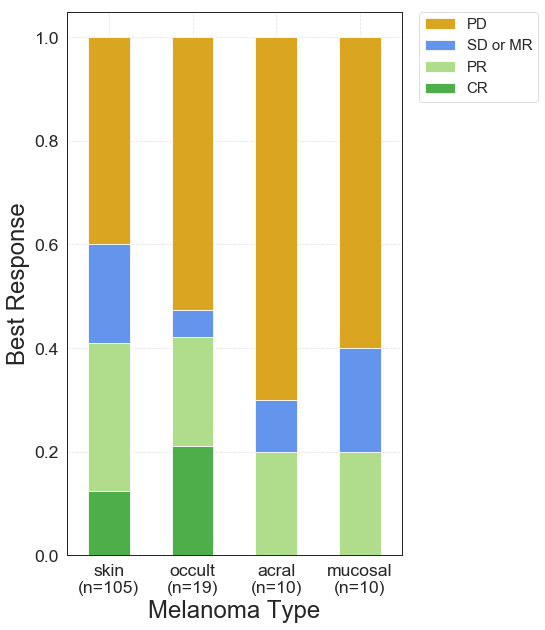

In [38]:
# Fig 1d - Primary type and Association with Response
groups = "BR"
cohort = tumorDF['BR'].isin(['PD', 'PR', 'CR', 'SD', 'MR'])

comparators = [
               'Primary_Type'
                ]

orderedCategories = {
                    'Primary_Type':['skin', 'occult', 'acral', 'mucosal']}

ncols = 1
nrows = len(comparators)
gs = gs = gridspec.GridSpec(nrows,ncols, #height_ratios = [1, ], width_ratios = [1,1,1], 
                       wspace=0.02, hspace = 0.4)

sns.set_context("paper",font_scale=2)

fig = plt.figure(figsize=(6,10*nrows))

i = 0

for comparator in comparators:
    values = tumorDF.loc[cohort,comparator].value_counts().index.sort_values()
    responses = []
    for value in values:
        crit = cohort & (tumorDF[comparator] == value)
        responses += [tumorDF.loc[crit, 'BR'].value_counts()]
    graphDF = pd.DataFrame(responses, index = values).transpose()
    graphDF.fillna(0, inplace=True)
    graphDF.loc['SD or MR'] = graphDF.loc['SD'] + graphDF.loc['MR']
    
    categories = ['CR', 'PR', 'SD or MR', 'PD']
    if comparator in orderedCategories:
        comparatorOrder = orderedCategories[comparator]
    else:
        comparatorOrder = graphDF.columns
    colorList = [GRAY, CR_COL, PR_COL, SD_COL, PD_COL]
    ax = plt.subplot(gs[i])
    PlotStackedBarPlot(ax, graphDF.loc[categories, comparatorOrder], xlabel=True, sigOrder = categories, normalize=True, 
                       colorList=colorList,legendSize=15)
    # set labels
    if comparator == 'Primary_Type':
        plt.xlabel('Melanoma Type', fontsize=24)
    else:
        plt.xlabel(comparator, fontsize=24)
    xticklabels = []
    for value in comparatorOrder:
        xticklabels += [value + "\n(n=" + str(int(graphDF.loc[categories,value].sum()))+")"]
    ax.set_xticklabels(xticklabels,rotation=0)
    
    plt.ylabel("Best Response", fontsize=24)
    
    # statistically compare values
    graphDF.loc['Responder'] = graphDF.loc['CR'] + graphDF.loc['PR']
    graphDF.loc['Nonresponder'] = graphDF.loc['PD']
    if comparator == 'Primary_Type':
        graphDF['skin + occult'] = graphDF['skin'] + graphDF['occult']
        graphDF['acral + mucosal'] = graphDF['acral'] + graphDF['mucosal']
    
    if comparator == 'Primary_Type':
        fishersMatrix = [[graphDF.loc['Responder', 'skin + occult'], graphDF.loc['Responder', 'acral + mucosal']], 
                        [graphDF.loc['Nonresponder', 'skin + occult'], graphDF.loc['Nonresponder', 'acral + mucosal']]]

        oddsratio, responder_combined_types_pval_fisher = stats.fisher_exact(fishersMatrix)

        responder_combined_types_pval = chi2_contingency(graphDF.loc[['Responder', 'Nonresponder'],
                                                                    ['skin + occult', 'acral + mucosal']])[1]
       
        print comparator, "R vs. NR (skin + occult vs. acral + mucosal): p =", responder_combined_types_pval_fisher, "(Fisher)"


    i+=1



occult
Group 1: median = 2.77545156296 mean =  2.65638668002
Group 2: median = 2.44480770099 mean =  2.37041097176
Mann Whitney rank test p-value is 0.350846051987 T-test p-value =  0.309992504032
mucosal
Group 1: median = 1.89422560351 mean =  1.89422560351
Group 2: median = 1.81632985665 mean =  1.78903113927
Mann Whitney rank test p-value is 0.404656761927 T-test p-value =  0.423341213731
acral
Group 1: median = 1.8600796517 mean =  1.8600796517
Group 2: median = 1.56820172407 mean =  1.59717608618
Mann Whitney rank test p-value is 0.187682772533 T-test p-value =  0.322327445411
skin
Group 1: median = 2.57403126773 mean =  2.51254902641
Group 2: median = 2.41733748723 mean =  2.42824113661
Mann Whitney rank test p-value is 0.268060511764 T-test p-value =  0.52801111614


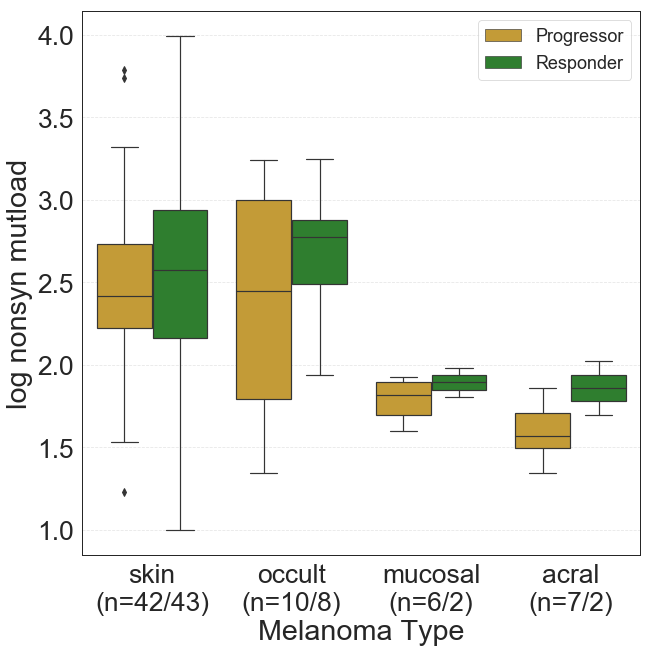

In [39]:
# Fig 1e - Examine difference between responders and nonresponders by melanoma subtype

comparators = [
            'log nonsyn mutload'
                ]

plt.figure(figsize=(10,10))
sns.set_context("paper",font_scale=3)

for comparator in comparators:
    graphDF = tumorDF[tumorDF[comparator].apply(np.isreal)] # remove samples with nonnumeric values
    graphDF.loc[graphDF.index, comparator] = [float(x) for x in graphDF.loc[graphDF.index, comparator]]

    # only include responder or progressor
    graphDF = graphDF.loc[list(responders) + list(progressors)]
    graphDF['Response'] = "Stable or Mixed Response"
    graphDF.loc[responders,'Response'] = "Responder"
    graphDF.loc[progressors,'Response'] = 'Progressor'
    
    # set xlabel and categories
    for subtype in graphDF['Primary_Type'].unique():
        tumors = graphDF['Primary_Type']==subtype
        total = sum(tumors)
        totalR = sum(graphDF.loc[tumors,'Response'] == 'Responder')
        totalPD = sum(graphDF.loc[tumors,'Response'] == 'Progressor')
        label = subtype + "\n(n=" + str(totalPD)+ "/"+ str(totalR) + ")"
        graphDF.loc[tumors,'Melanoma Type'] = label

    ax = sns.boxplot(x = 'Melanoma Type', y = comparator, hue = 'Response', data=graphDF, 
                    hue_order = ['Progressor', 'Responder'], 
                    palette=[NRESPONDER_COL, RESPONDER_COL])
    
    ax.legend(prop={'size':18})
    groups = {}

    groups['occult'] = graphDF['Primary_Type']=='occult'
    groups['skin'] = graphDF['Primary_Type']=='skin'
    groups['acral'] = graphDF['Primary_Type']=='acral'
    groups['mucosal'] = graphDF['Primary_Type']=='mucosal'

    responder = graphDF['Response']=="Responder"
    nonresponder = graphDF['Response']=="Progressor"
    for group in groups:
        print group
        subtype = groups[group]
        TestMedian(graphDF.loc[subtype & responder, comparator],
                  graphDF.loc[subtype & nonresponder, comparator], VERBOSE=True)


PD vs Responder
log nonsyn mutload
Responder vs. Nonresponder:
Group 1: median = 2.42974927909 mean =  2.41711995106
Group 2: median = 1.89422560351 mean =  1.87715262761
Mann Whitney rank test p-value is 0.0317565928715 T-test p-value =  0.000335758427138
Skin or Occult R vs. Progressor:
Group 1: median = 2.42974927909 mean =  2.41711995106
Group 2: median = 2.58883172559 mean =  2.53511179561
Mann Whitney rank test p-value is 0.139531361383 T-test p-value =  0.328828330385
Mucosoal/Acral R vs. Progressor:
Group 1: median = 1.67209785794 mean =  1.68572457222
Group 2: median = 1.89422560351 mean =  1.87715262761
Mann Whitney rank test p-value is 0.0790703487274 T-test p-value =  0.0798319092848


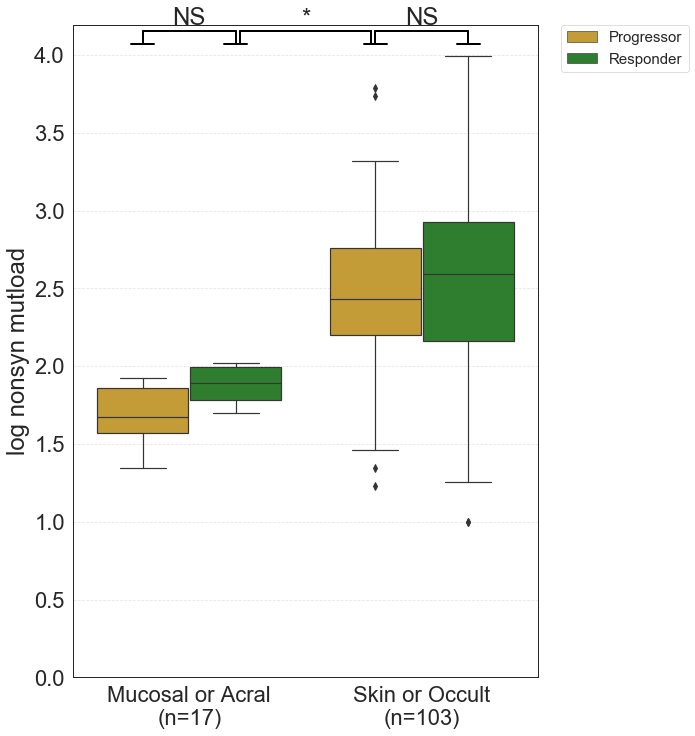

In [40]:
# Fig 1f - combining (skin or occult) and comparing to (acral or mucosal) responders vs. progressors TMB
comparisonGroups = [
    'PD vs Responder',
    'PD vs nonPD',
]

group = "PD vs Responder"
cohort = ~tumorDF[group].isnull()
comparators = [
            'log nonsyn mutload',
                ]

ncols = len(comparators) + 1
nrows = 1
gs = gs = gridspec.GridSpec(nrows,ncols, #height_ratios = [1, ], width_ratios = [1,1,1], 
                       wspace=0.4, hspace = 0.4)

fig = plt.figure(figsize=(10*ncols,12))
sns.set_context("paper",font_scale=2.5)
print group

i = 0
for comparator in comparators:
    ax = plt.subplot(gs[i])
    if tumorDF.loc[cohort, comparator].dtype == object: # not numeric
        graphDF = tumorDF[cohort][~(tumorDF.loc[cohort][comparator] == "unknown")][[group,comparator, "Primary_Type_Categ"]]
        print "WARNING: not all values are numeric; ignoring and proceeding"
    else:
        graphDF = tumorDF.loc[cohort, [group,comparator, "Primary_Type_Categ"]]
    graphDF[comparator] = [float(x) for x in graphDF[comparator]]

    # Generate response (x-axis)
    skinR = (graphDF[group]=="Responder") &  (graphDF['Primary_Type_Categ'] == "Skin or Occult")
    skinNR = (graphDF[group]=="Progressor") & (graphDF['Primary_Type_Categ'] == "Skin or Occult")
    mucosalR = (graphDF[group]=="Responder") & (graphDF['Primary_Type_Categ'] == "Mucosal or Acral")
    mucosalNR = (graphDF[group]=="Progressor") & (graphDF['Primary_Type_Categ'] == "Mucosal or Acral")
    
    categories = ['Skin or Occult\nProgressors\n(n=' + str(sum(skinNR)) + ')',
                  'Skin or Occult\nResponders\n(n=' + str(sum(skinR)) + ')',
                  'Mucosal or Acral\nProgressors\n(n=' + str(sum(mucosalNR)) + ')',
                  'Mucosal or Acral\nResponders\n(n=' + str(sum(mucosalR)) + ')']
    categoryLabels = {}
    graphDF.loc[skinNR,"Response"] = categories[0]
    graphDF.loc[mucosalR,"Response"] = categories[3]
    graphDF.loc[skinR,"Response"] = categories[1]
    graphDF.loc[mucosalNR,"Response"] = categories[2]
    graphDF = graphDF[~graphDF['Response'].isnull()] 
    for x in graphDF['Primary_Type_Categ'].unique():
        tumors = graphDF['Primary_Type_Categ']==x
        graphDF.loc[tumors,'Melanoma Type']=x + "\n(n=" + str(sum(tumors))+")"
        categoryLabels[x] = x + "\n(n=" + str(sum(tumors))+")"
    ax = sns.boxplot(x = 'Melanoma Type', y = comparator, hue = group, data=graphDF, 
                    hue_order = ['Progressor', 'Responder'], 
                    order = [categoryLabels['Mucosal or Acral'], categoryLabels['Skin or Occult']],
                    palette=[NRESPONDER_COL, RESPONDER_COL])
    # set legend
    if i == len(comparators)-1: # last
        ax.legend(prop={'size':15}, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.ylim(0,max(graphDF[comparator])*1.05)
    plt.xlabel("")
    # statistically compare values

    print comparator
    print "Responder vs. Nonresponder:"
    pval = TestMedian(graphDF.loc[skinNR,comparator], graphDF.loc[mucosalR,comparator], VERBOSE=True)[0]
    
    print "Skin or Occult R vs. Progressor:"
    skinRvP = TestMedian(graphDF.loc[skinNR,comparator], graphDF.loc[skinR,comparator], VERBOSE=True)[0]

    print "Mucosoal/Acral R vs. Progressor:"
    mucosalRvP = TestMedian(graphDF.loc[mucosalNR,comparator], graphDF.loc[mucosalR,comparator], VERBOSE=True)[0]
 
    # plot the significance comparison
    sig = "NS"
    if pval <= 0.05:
        sig = "*"
    if pval <= 0.01:
        sig = "**"
    if pval <= 0.001:
        sig = "***"

    skinRvPsig = "NS"
    if skinRvP <= 0.05:
        skinRvPsig = "*"
    if skinRvP <= 0.01:
        skinRvPsig = "**"
    if skinRvP <= 0.001:
        skinRvPsig = "***"

    mucosalRvPsig = "NS"
    if mucosalRvP <= 0.05:
        mucosalRvPsig = "*"
    if mucosalRvP <= 0.01:
        mucosalRvPsig = "**"
    if mucosalRvP <= 0.001:
        mucosalRvPsig = "***"
    
        
    yMax = graphDF[comparator].max()
   
    # plot significance marker
    plt.plot([-0.25,-0.15],[yMax * 1.02,yMax * 1.02], lw=2, color="black")
    plt.plot([0.15,0.25],[yMax * 1.02,yMax * 1.02], lw=2, color="black")
    plt.plot([-0.20,-0.20],[yMax * 1.02,yMax * 1.04], lw=2, color="black")
    plt.plot([0.20,0.2],[yMax * 1.02,yMax * 1.04], lw=2, color="black")
    plt.plot([-0.20,0.2],[yMax * 1.04,yMax * 1.04], lw=2, color="black")
    
    plt.plot([0.75,0.85],[yMax * 1.02,yMax * 1.02], lw=2, color="black")
    plt.plot([1.15,1.25],[yMax * 1.02,yMax * 1.02], lw=2, color="black")
    plt.plot([0.80,0.80],[yMax * 1.02,yMax * 1.04], lw=2, color="black")
    plt.plot([1.20,1.2],[yMax * 1.02,yMax * 1.04], lw=2, color="black")
    plt.plot([0.80,1.2],[yMax * 1.04,yMax * 1.04], lw=2, color="black")

    plt.plot([0.22,0.22],[yMax * 1.02,yMax * 1.04], lw=2, color="black")
    plt.plot([0.22,0.78],[yMax * 1.04,yMax * 1.04], lw=2, color="black")
    plt.plot([0.78,0.78],[yMax * 1.02,yMax * 1.04], lw=2, color="black")
    
    plt.text(0.5,yMax * 1.05,sig, ha='center')
    plt.text(0,yMax * 1.05,skinRvPsig, ha='center')
    plt.text(1,yMax * 1.05,mucosalRvPsig, ha='center')

    i+=1

## Figure 2

PD vs Responder
heterogeneity
Responder vs. Progressor:
Group 1: median = 0.148936170213 mean =  0.165089463549
Group 2: median = 0.194444444444 mean =  0.220125265704
Mann Whitney rank test p-value is 0.0243457418152 T-test p-value =  0.0119133841732
purity
Responder vs. Progressor:
Group 1: median = 0.64 mean =  0.598727272727
Group 2: median = 0.77 mean =  0.681230769231
Mann Whitney rank test p-value is 0.0409287660238 T-test p-value =  0.0532069205036
ploidy
Responder vs. Progressor:
Group 1: median = 2.22 mean =  2.72072727273
Group 2: median = 2.12 mean =  2.41707692308
Mann Whitney rank test p-value is 0.0433530437906 T-test p-value =  0.0391743397223


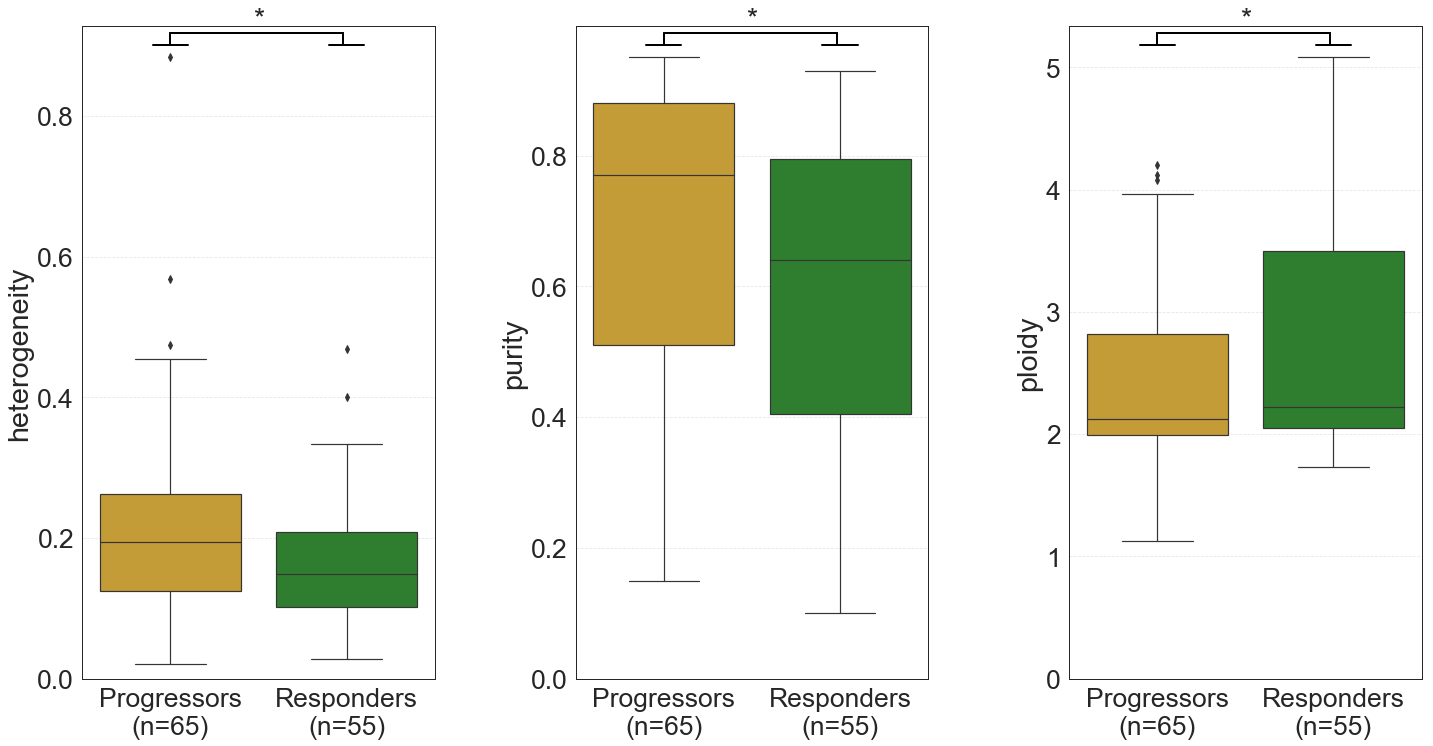

In [41]:
# Fig 2a-c -- Difference in genomic characteristics between responders and progressors 
comparisonGroups = [
    'PD vs Responder',
    'PD vs nonPD',
]

group = "PD vs Responder"
df = tumorDF
cohort = df.index
comparators = [
            'heterogeneity',
             'purity',
                'ploidy',
                ]

ncols = len(comparators)
nrows = 1
gs = gs = gridspec.GridSpec(nrows,ncols, #height_ratios = [1, ], width_ratios = [1,1,1], 
                       wspace=0.4, hspace = 0.4)

fig = plt.figure(figsize=(8*ncols,12))
sns.set_context("paper",font_scale=3)
print group

i = 0
for comparator in comparators:
    ax = plt.subplot(gs[i])
    valid = pd.to_numeric(df.loc[cohort, comparator], errors='coerce')
    if sum(valid.isnull())>0:
        print "WARNING: not all values are numeric; ignoring", sum(valid.isnull()),"values and proceeding"
    graphDF = df.loc[cohort].loc[~(valid.isnull())][[group, comparator]]
    graphDF[comparator] = [float(x) for x in graphDF[comparator]]

    # Generate response
    if group == "PD vs Responder":
        responder = graphDF[group]=="Responder"
        nonresponder = graphDF[group] == "Progressor"
        SDorMR = ~(responder | nonresponder)
        categories = ['Progressors\n(n='+str(sum(nonresponder))+')', 
                      'Responders\n(n='+str(sum(responder))+")"
                     ]
        graphDF.loc[responder,'Response'] = categories[1]
        graphDF.loc[nonresponder,'Response'] = categories[0]
        graphDF = graphDF.loc[~graphDF['Response'].isnull()]
    elif group == "PD vs nonPD":
        responder = graphDF[group]=="nonPD"
        nonresponder = graphDF[group] == "PD"
        graphDF.loc[responder,'Response'] = 'nonPD'
        graphDF.loc[nonresponder,'Response'] = 'PD'
        categories = ['PD', 'nonPD']

    sns.boxplot(x="Response", y=comparator, data=graphDF, order=[categories[0], categories[1]], 
                palette=[NRESPONDER_COL,RESPONDER_COL])
    plt.ylim(0,max(graphDF[comparator])*1.05)
    plt.xlabel("")
    # statistically compare values

    print comparator
    print "Responder vs. Progressor:"
    pval = TestMedian(graphDF.loc[responder,comparator], graphDF.loc[nonresponder,comparator], VERBOSE=True)[0]


    # plot the significance comparison
    sig = "NS"
    if pval <= 0.15:
        sig = 'p=' + "{:.2f}".format(pval)
    if pval <= 0.05:
        sig = "*"
    if pval <= 0.01:
        sig = "**"
    if pval <= 0.001:
        sig = "***"    
    
    yMax = graphDF[comparator].max()
    plt.plot([-0.1,0.1], [yMax * 1.02,yMax * 1.02], lw=2, color="black")
    plt.plot([0,0],[yMax * 1.02, yMax * 1.04], lw=2, color="black")
    plt.plot([0,0.98], [yMax * 1.04,yMax * 1.04], lw=2, color="black")
    plt.plot([0.98,0.98],[yMax * 1.02, yMax * 1.04], lw=2, color="black")
    plt.plot([0.9,1.1], [yMax * 1.02,yMax * 1.02], lw=2, color="black")

  
    plt.text(0.5,yMax * 1.05,sig, ha='center')

    i+=1

             Amp  No Amp
Responders     6      49
Progressors    0      65
[[6, 49], [0, 65]]
MHC-I HLA R vs. PD: p = 0.00793640709911 (Fisher)
MHC-I HLA R vs. PD: OR =  inf


Text(0.5,1.03,'**')

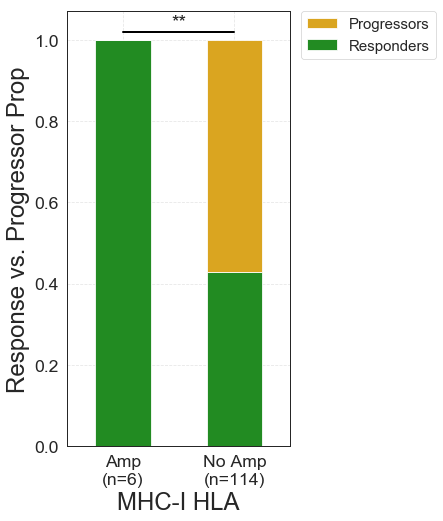

In [42]:
# Fig 2d - Association of MHC-I HLA amplification with response

cohort = ~tumorDF['Responder'].isnull() # either Responder (CR,PR) or (PD)
group = 'MHC-I HLA'

tempDF = tumorDF[cohort][['Responder']]
ampResponders = sum((tempDF['Responder']==1)&(tempDF.index.isin(ampTumors[group])))
ampNonresponders = sum((tempDF['Responder']==0)&(tempDF.index.isin(ampTumors[group])))
wtResponders = sum((tempDF['Responder']==1)&(~tempDF.index.isin(ampTumors[group])))
wtNonresponders = sum((tempDF['Responder']==0)&(~tempDF.index.isin(ampTumors[group])))
graphDF = pd.DataFrame([[ampResponders,
                       ampNonresponders],
                       [wtResponders,
                       wtNonresponders]], 
                       index = ['Amp', 'No Amp'],
                      columns = ['Responders', 'Progressors']).transpose()
print graphDF

ncols = 1
nrows = 1
gs = gridspec.GridSpec(nrows,ncols, #height_ratios = [1, ], width_ratios = [1,1,1], 
                       wspace=0.02, hspace = 0.4)

sns.set_context("paper",font_scale=2)

fig = plt.figure(figsize=(4,8*nrows))

i = 0

groupOrder = graphDF.columns
colorList = [GRAY, RESPONDER_COL, NRESPONDER_COL]
ax = plt.subplot(gs[i])
categories = ['Responders', 'Progressors']
PlotStackedBarPlot(ax, graphDF.loc[categories, groupOrder], xlabel=True, sigOrder = categories, normalize=True, 
                    colorList=colorList,legendSize=15)
plt.xlabel(group, fontsize=24)
xlabels = []
for label in groupOrder:
    total = graphDF[label].sum()
    xlabels += [label + "\n(n=" + str(total)+")"]
ax.set_xticklabels(xlabels,rotation=0)
plt.ylabel("Response vs. Progressor Prop", fontsize=24)
    
# statistically compare values
fishersMatrix = [[graphDF.loc['Responders', 'Amp'], graphDF.loc['Responders', 'No Amp']], 
                        [graphDF.loc['Progressors', 'Amp'], graphDF.loc['Progressors', 'No Amp']]]
print fishersMatrix
oddsratio, pval_fisher = stats.fisher_exact(fishersMatrix)
       
print group, "R vs. PD: p =", pval_fisher, "(Fisher)"
print group, "R vs. PD: OR = ", oddsratio 

# plot the significance comparison
sig = "NS"
if pval_fisher <= 0.15:
    sig = "p=" + "{:.3f}".format(pval_fisher)
if pval_fisher <= 0.05:
    sig = "*"
if pval_fisher <= 0.01:
    sig = "**"
if pval_fisher <= 0.001:
    sig = "***"
    
yMax = 1
plt.plot([0,1],[yMax * 1.02,yMax * 1.02], lw=2, color="black")  
   
plt.text(0.5,yMax * 1.03,sig, ha='center')


             Amp  No Amp
Responders     6      49
Progressors    0      65
[[6, 49], [0, 65]]
TAP2 R vs. PD: p = 0.00793640709911 (Fisher)
TAP2 R vs. PD: OR =  inf


Text(0.5,1.03,'**')

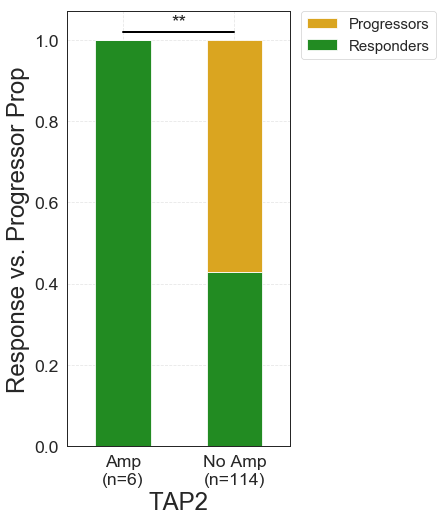

In [43]:
# Fig 2e - Association of TAP2 HLA amplification with response

cohort = ~tumorDF['Responder'].isnull() # either Responder (CR,PR) or (PD)
group = 'TAP2'

tempDF = tumorDF[cohort][['Responder']]
ampResponders = sum((tempDF['Responder']==1)&(tempDF.index.isin(ampTumors[group])))
ampNonresponders = sum((tempDF['Responder']==0)&(tempDF.index.isin(ampTumors[group])))
wtResponders = sum((tempDF['Responder']==1)&(~tempDF.index.isin(ampTumors[group])))
wtNonresponders = sum((tempDF['Responder']==0)&(~tempDF.index.isin(ampTumors[group])))
graphDF = pd.DataFrame([[ampResponders,
                       ampNonresponders],
                       [wtResponders,
                       wtNonresponders]], 
                       index = ['Amp', 'No Amp'],
                      columns = ['Responders', 'Progressors']).transpose()
print graphDF

ncols = 1
nrows = 1
gs = gridspec.GridSpec(nrows,ncols, #height_ratios = [1, ], width_ratios = [1,1,1], 
                       wspace=0.02, hspace = 0.4)

sns.set_context("paper",font_scale=2)

fig = plt.figure(figsize=(4,8*nrows))

i = 0

groupOrder = graphDF.columns
colorList = [GRAY, RESPONDER_COL, NRESPONDER_COL]
ax = plt.subplot(gs[i])
categories = ['Responders', 'Progressors']
PlotStackedBarPlot(ax, graphDF.loc[categories, groupOrder], xlabel=True, sigOrder = categories, normalize=True, 
                    colorList=colorList,legendSize=15)
plt.xlabel(group, fontsize=24)
xlabels = []
for label in groupOrder:
    total = graphDF[label].sum()
    xlabels += [label + "\n(n=" + str(total)+")"]
ax.set_xticklabels(xlabels,rotation=0)
plt.ylabel("Response vs. Progressor Prop", fontsize=24)
    
# statistically compare values
fishersMatrix = [[graphDF.loc['Responders', 'Amp'], graphDF.loc['Responders', 'No Amp']], 
                        [graphDF.loc['Progressors', 'Amp'], graphDF.loc['Progressors', 'No Amp']]]
print fishersMatrix
oddsratio, pval_fisher = stats.fisher_exact(fishersMatrix)
       
print group, "R vs. PD: p =", pval_fisher, "(Fisher)"
print group, "R vs. PD: OR = ", oddsratio 

# plot the significance comparison
sig = "NS"
if pval_fisher <= 0.15:
    sig = "p=" + "{:.3f}".format(pval_fisher)
if pval_fisher <= 0.05:
    sig = "*"
if pval_fisher <= 0.01:
    sig = "**"
if pval_fisher <= 0.001:
    sig = "***"
    
yMax = 1
plt.plot([0,1],[yMax * 1.02,yMax * 1.02], lw=2, color="black")  
   
plt.text(0.5,yMax * 1.03,sig, ha='center')


In [44]:
# Fig 2g - association of response with various transcriptomic features

# calculate pval for difference btween responders and nonresponders for a set of features
response = 'PD vs Responder'
cohorts = [fullDF.index]
cohortLabels = ['overall']
cols = [x + "-Current pval" for x in cohortLabels] + [x + "-Current median diffs" for x in cohortLabels]
#features = genes

features = rnaDF.columns

pvalDF = pd.DataFrame(index = features,
                     columns = cols)

orderedValues = {'PD vs Responder':['Responder', 'Progressor']}

for i,cohort in enumerate(cohorts):
    df = fullDF.loc[cohort]
    # if not all features are in fullDF, add them
    addFeatures = [x for x in features if x not in fullDF.columns]
    graphDF = df.merge(allRNADF[addFeatures], left_index=True, right_index = True)

    values = orderedValues[response]
    # assume there's only 2 values in the response cateogry other than 'nan'
    
    response1 = graphDF[response] == values[0]
    response2 = graphDF[response] == values[1]

    response1 = response1[response1].index # generate the list
    response2 = response2[response2].index # generate the list

    for feature in features:
        group1 = pd.to_numeric(graphDF.loc[response1,feature],errors='coerce')
        group2 = pd.to_numeric(graphDF.loc[response2,feature],errors='coerce')
        
        if sum(group1 == 0) == len(group1):
            continue # skip
        pval,ttPval, diffMedian = TestMedian(group1, 
                            group2, 
                            VERBOSE=False)
        
        pvalDF.loc[feature, cols[i]] = pval
        pvalDF.loc[feature, cols[i+len(cohortLabels)]] = diffMedian

pvalDF[0:5]

,overall-Current pval,overall-Current median diffs
TAP1,0.654929,0.00119642
HSF1,0.580357,0.0341415
ELANE,0.538903,0
TAP2,0.352233,0.0894379
SYNPO,0.149841,-0.300951


/Users/davidliu/anaconda2/envs/combi-d/lib/python2.7/site-packages/pandas/core/indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


Text(0.5,0,'difference in medians (normalized)')

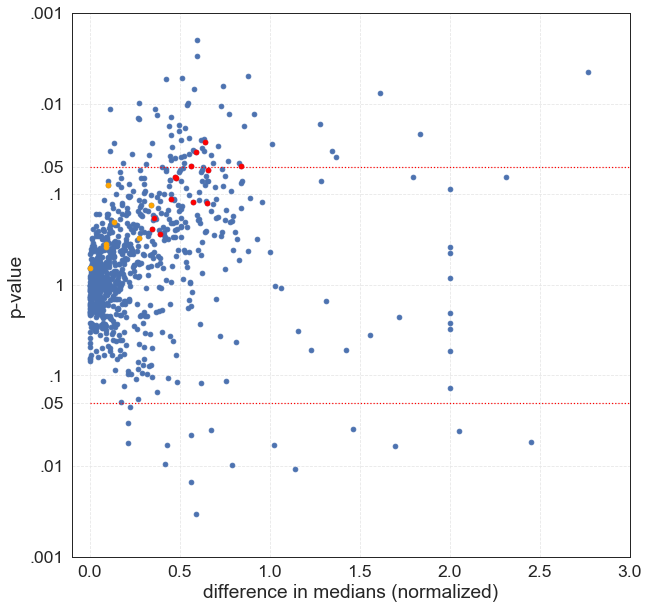

In [45]:
# Fig 2g - association of response with various transcriptomic features, highlighting mhc1 and mhc2 genes
mhc1 = ['HLA-A', 'HLA-B', 'HLA-C', 'HLA-E', 'HLA-F', 'TAP1', 'TAP2', 'B2M']
mhc2 = ['HLA-DMA', 'HLA-DMB', 'HLA-DOA', 'HLA-DOB', 'HLA-DPA1', 'HLA-DPB1', 
        'HLA-DQA1', 'HLA-DQA2', 'HLA-DQB1', 'HLA-DQB2', 'HLA-DRA', 'HLA-DRB1', 
        'HLA-DRB5']

graphDF = pvalDF[['overall-Current pval', 'overall-Current median diffs']]

graphDF.columns = ['pval', 'median diffs']
fig = plt.figure(figsize=(10,10))
ax = plt.subplot()

colorGenes = {'red':mhc2,
             'orange':mhc1}

PlotPValDiffs(graphDF, ax = ax, colorGenes = colorGenes, labelGenes = None)
ax.set_xlim(-0.1,3)
ax.set_ylim(-3,3)
ax.set_xlabel('difference in medians (normalized)')




0

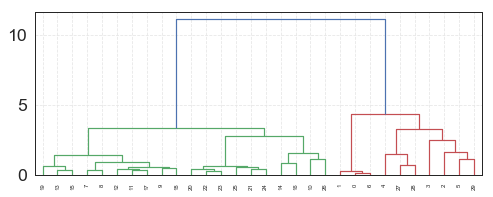

<Figure size 864x864 with 0 Axes>

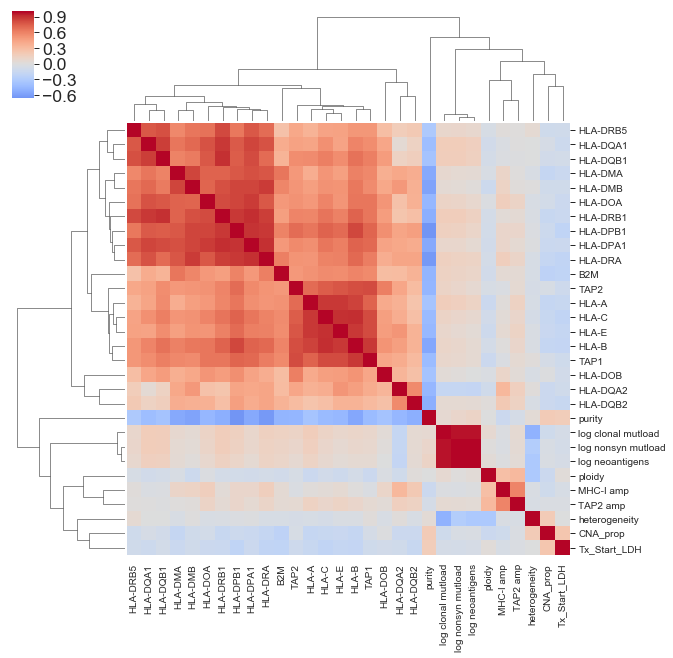

In [46]:
# Fig 2h - hierarchical clustering of genomic and transcriptomic features
from scipy.cluster.hierarchy import dendrogram, linkage

comparators = [
            'log nonsyn mutload',
             'log clonal mutload',
              'heterogeneity',
              'purity',
                'ploidy',
             'CNA_prop',
               'log neoantigens',
    'HLA-DMA', 'HLA-DMB', 'HLA-DOA', 'HLA-DOB', 'HLA-DPA1', 'HLA-DPB1', 
        'HLA-DQA1', 'HLA-DQA2', 'HLA-DQB1', 'HLA-DQB2', 'HLA-DRA', 'HLA-DRB1', 
        'HLA-DRB5',
            'HLA-A', 'HLA-B', 'HLA-C', 'HLA-E', 'TAP1', 'TAP2', 'B2M',
            'MHC-I amp',
            'TAP2 amp',
               'Tx_Start_LDH',
                ]

# Generate the co-correlation matrix and hierarchical clustering based on heat map

features = comparators

# generate the correlations for features in tumorDF first
tumorDFFeatures = [x for x in features if x in tumorDF.columns]

tumorDFCorr = pd.DataFrame(columns = tumorDFFeatures)
for feature in tumorDFFeatures:
    tumorDFCorr[feature] = pd.to_numeric(tumorDF[feature], errors="coerce") # coerce to numerics
    
tumorDFcorrmat = tumorDFCorr.corr()

corrDF = pd.DataFrame(columns = features)
for feature in features:
    corrDF[feature] = pd.to_numeric(fullDF[feature], errors="coerce") # coerce to numerics
corrmat = corrDF.corr() 

for feature in tumorDFFeatures: # replace entries where they exist
    for feature2 in tumorDFFeatures:
        corrmat.loc[feature, feature2] = tumorDFcorrmat.loc[feature, feature2]

#corrmat = batch1fullDF.ix[cbTest+ncbTest, numericFeatures].corr()
Z = linkage(corrmat, 'ward') # generate the linkage/hierarchical clustering
order = [int(s) for s in dendrogram(Z, leaf_rotation=90, leaf_font_size=6)['ivl']]

# Generate the heatmap
plt.figure(figsize = (12,12))
#ax = plt.subplot()
#sns.heatmap(corrmat.ix[order, order], vmax = 1, vmin = -1, square = True, cmap = "RdBu", fontsize=10)
cg = sns.clustermap(corrmat.iloc[order,order], cmap="coolwarm", center=0, 
                    yticklabels=True, xticklabels=True)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=10)
plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), fontsize=10)
0

## Figure 3

          Ipi-naive  Post-Ipi
PD               37        28
PR               21        17
CR               13         4
SD               11         9
MR                2         2
SD or MR         13        11
priorCTLA4 Overall: p = 0.444865319199 (Chi-squared)


0.0    84
1.0    60
Name: priorCTLA4, dtype: int64

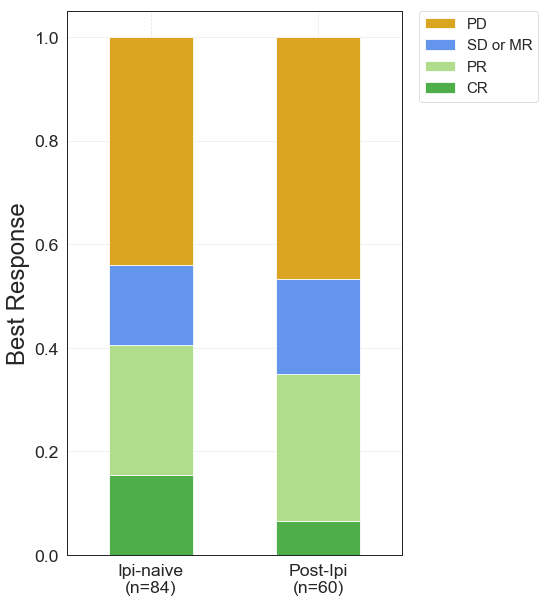

In [47]:
# Fig 3b - response and prior ipilimumab therapy
groups = "BR"
cohort = tumorDF['BR'].isin(['PD', 'PR', 'CR', 'SD', 'MR'])

comparators = [
                'priorCTLA4',
                ]

orderedCategories = { 'priorCTLA4':['Ipi-naive', 'Post-Ipi']}

translateLabels = {'priorCTLA4':{0:"Ipi-naive", 1:"Post-Ipi"}}

ncols = 1
nrows = len(comparators)
gs = gs = gridspec.GridSpec(nrows,ncols, #height_ratios = [1, ], width_ratios = [1,1,1], 
                       wspace=0.02, hspace = 0.4)

sns.set_context("paper",font_scale=2)

fig = plt.figure(figsize=(6,10*nrows))

i = 0

for comparator in comparators:
    values = tumorDF.loc[cohort,comparator].value_counts().index.sort_values()
    responses = []
    for value in values:
        crit = cohort & (tumorDF[comparator] == value)
        responses += [tumorDF.loc[crit, 'BR'].value_counts()]
    graphDF = pd.DataFrame(responses, index = values).transpose()
    graphDF.fillna(0, inplace=True)
    graphDF.loc['SD or MR'] = graphDF.loc['SD'] + graphDF.loc['MR']
    if comparator in translateLabels: # swap values for names for clarity
        graphDF.rename(columns=translateLabels[comparator], inplace=True) 
    print graphDF
    categories = ['CR', 'PR', 'SD or MR', 'PD']
    if comparator in orderedCategories:
        comparatorOrder = orderedCategories[comparator]
    else:
        comparatorOrder = graphDF.columns
    colorList = [GRAY, CR_COL, PR_COL, SD_COL, PD_COL]
    ax = plt.subplot(gs[i])
    PlotStackedBarPlot(ax, graphDF.loc[categories, comparatorOrder], xlabel=True, sigOrder = categories, normalize=True, 
                       colorList=colorList,legendSize=15)
    # set labels
    if comparator == 'Primary_Type':
        plt.xlabel('Melanoma Type', fontsize=24)
    elif comparator == 'priorCTLA4':
        plt.xlabel('')
    else:
        plt.xlabel(comparator, fontsize=24)
    xticklabels = []
    for value in comparatorOrder:
        xticklabels += [value + "\n(n=" + str(int(graphDF.loc[categories,value].sum()))+")"]
    ax.set_xticklabels(xticklabels,rotation=0)
    
    plt.ylabel("Best Response", fontsize=24)
    
    graphDF.loc['Responder'] = graphDF.loc['CR'] + graphDF.loc['PR']
    graphDF.loc['Nonresponder'] = graphDF.loc['PD']
    if comparator == 'Primary_Type':
        graphDF['skin + occult'] = graphDF['skin'] + graphDF['occult']
        graphDF['acral + mucosal'] = graphDF['acral'] + graphDF['mucosal']
    
    all_pval = chi2_contingency(graphDF.loc[categories,comparatorOrder])[1]
    
    print comparator, "Overall: p =", all_pval, "(Chi-squared)"     
    i+=1


tumorDF[comparator].value_counts()



RvsPD :
Group 1: median = 6404.148628 mean =  5704.64710431
Group 2: median = 7290.593457 mean =  6488.94775658
Mann Whitney rank test p-value is 0.0286493655476 T-test p-value =  0.131161753356


/Users/davidliu/anaconda2/envs/combi-d/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/davidliu/anaconda2/envs/combi-d/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


RvsPD-ipi-exp :
Group 1: median = 6612.119361 mean =  6357.55169162
Group 2: median = 7850.168545 mean =  7611.45627973
Mann Whitney rank test p-value is 0.0280981150895 T-test p-value =  0.049729824946
RvsPD-ipi-naive :
Group 1: median = 6393.244206 mean =  5645.23159579
Group 2: median = 7143.484281 mean =  6043.99179724
Mann Whitney rank test p-value is 0.326759848821 T-test p-value =  0.587194258143


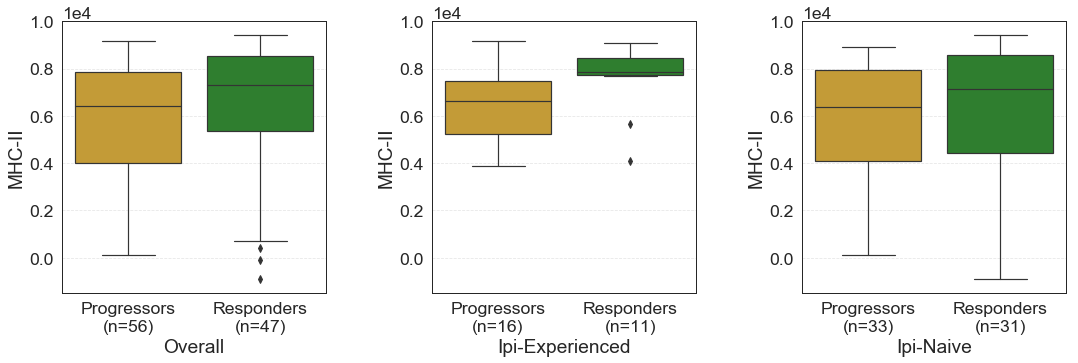

In [48]:
# Fig 3cde - MHC-II ssGSEA in responders vs progressors overall and by prior ipilimumab therapy
# Now visualize differences in signatures
sig='MHC-II'

outcomes = ['RvsPD', 'RvsPD-ipi-exp', 'RvsPD-ipi-naive']

outcomeGroups = {'RvsPD':[progressors, responders],
                'PDvsnPD-ipi-exp':[PDpostIpi, nPDpostIpi],
                'PDvsnPD-ipi-naive':[PDnoIpi, nPDnoIpi],
                'RvsPD-ipi-exp':[PDpostIpi, RpostIpi],
                'RvsPD-ipi-naive':[PDnoIpi, RnoIpi],
                'PD-ipi-exp-vs-naive':[PDpostIpi, PDnoIpi],
                'R-ipi-exp-vs-naive':[RpostIpi, RnoIpi],
                'ipi-exp-vs-naive':[postIpi, noIpi]}
outcomeLabels = {'RvsPD':["Progressors", 'Responders'],
                'PDvsnPD-ipi-exp':['Progressors',
                                   'Non-Progressors'],
                'PDvsnPD-ipi-naive':['Progressors',
                                   'Non-Progressors'],
                'RvsPD-ipi-exp':['Progressors',
                                   'Responders'],
                'RvsPD-ipi-naive':['Progressors',
                                   'Responders'],
                'PD-ipi-exp-vs-naive':['Ipi-Exp', 'Ipi-Naive'],
                'R-ipi-exp-vs-naive':['Ipi-Exp', 'Ipi-Naive'],
                'ipi-exp-vs-naive':['Ipi-Exp', 'Ipi-Naive']}
comparisonGroups = {'PDvsnPD-ipi-exp':'Ipi-Experienced',
                'PDvsnPD-ipi-naive':'Ipi-Naive',
                'RvsPD-ipi-exp':'Ipi-Experienced',
                'RvsPD-ipi-naive':'Ipi-Naive',
                   'RvsPD':'Overall',
                   'PD-ipi-exp-vs-naive':'Progressors',
                   'R-ipi-exp-vs-naive':'Responders',
                   'ipi-exp-vs-naive':''}

ncols = len(outcomes)
nrows = 1
gs = gs = gridspec.GridSpec(nrows,ncols, #height_ratios = [1, ], width_ratios = [1,1,1], 
                       wspace=0.4, hspace = 0.4)

fig = plt.figure(figsize=(6*ncols,5))
sns.set_context("paper",font_scale=2)

i = 0
for outcome in outcomes:
    ax = plt.subplot(gs[i])
    group1 = [x for x in outcomeGroups[outcome][0] if x in fullDF.index]
    group2 = [x for x in outcomeGroups[outcome][1] if x in fullDF.index]
    print outcome,":"
    TestMedian(fullDF.loc[group1, sig],
           fullDF.loc[group2, sig], VERBOSE=True)
    graphDF = fullDF[[sig]]
    group1label = outcomeLabels[outcome][0] + '\n(n=' + str(len(group1))+ ')'
    group2label = outcomeLabels[outcome][1] + '\n(n=' + str(len(group2))+ ')'
    graphDF.loc[group1,outcome] = group1label
    graphDF.loc[group2,outcome] = group2label

    sns.boxplot(x = outcome, y = sig, data=graphDF, order=[group1label, group2label],
            palette = [NRESPONDER_COL, RESPONDER_COL])

    plt.xlabel(comparisonGroups[outcome])

    plt.ylim(-1500,10000)
    i += 1


In [49]:
# read in gsea data
suppTableFile = "data/Supplemental_Tables.xlsx"
gseaTab = "Supplemental Table 5"

gseaDF = pd.read_excel(suppTableFile, sheet_name = gseaTab, header=3)

gseaDF


,DISCOVERY RvsPD Overall NES,DISCOVERY RvsPD Overall NOM p-val,DISCOVERY RvsPD Overall FDR q-val,DISCOVERY RvsPD Overall enriched in,DISCOVERY RvsPD Ipi-Exp NES,DISCOVERY RvsPD Ipi-Exp NOM p-val,DISCOVERY RvsPD Ipi-Exp FDR q-val,DISCOVERY RvsPD Ipi-Exp enriched in,DISCOVERY RvsPD Ipi-Naive NES,DISCOVERY RvsPD Ipi-Naive NOM p-val,...,Riaz RvsPD Overall FDR q-val,Riaz RvsPD Overall enriched in,Riaz RvsPD Ipi-Exp NES,Riaz RvsPD Ipi-Exp NOM p-val,Riaz RvsPD Ipi-Exp FDR q-val,Riaz RvsPD Ipi-Exp enriched in,Riaz RvsPD Ipi-Naive NES,Riaz RvsPD Ipi-Naive NOM p-val,Riaz RvsPD Ipi-Naive FDR q-val,Riaz RvsPD Ipi-Naive enriched in
ALLOGRAFT_REJECTION,2.951445,0.000000,0.000000,Responders,2.671605,0.000000,0.000000,Responders,2.315368,0.000000,...,0.000000,Responders,3.541425,0.000000,0.000000,Responders,1.059423,0.281799,0.401428,Responders
INTERFERON_GAMMA_RESPONSE,2.277866,0.000000,0.000000,Responders,2.479597,0.000000,0.000000,Responders,1.261520,0.044351,...,0.000000,Responders,3.712001,0.000000,0.000000,Responders,-0.949151,0.579086,0.870253,Progressors
IL6_JAK_STAT3_SIGNALING,2.128863,0.000000,0.000105,Responders,1.535250,0.008764,0.018885,Responders,1.800033,0.000268,...,0.000000,Responders,2.955385,0.000000,0.000000,Responders,0.813347,0.854493,0.893651,Responders
MYOGENESIS,2.049868,0.000000,0.000197,Responders,-1.125047,0.197349,0.791786,Progressors,1.154048,0.137887,...,0.027228,Progressors,1.392914,0.005181,0.051000,Responders,-2.093844,0.000000,0.000176,Progressors
COMPLEMENT,2.008698,0.000000,0.000316,Responders,1.673256,0.000217,0.007884,Responders,1.522862,0.000932,...,0.007118,Responders,2.610486,0.000000,0.000000,Responders,-1.169287,0.157501,0.372434,Progressors
INFLAMMATORY_RESPONSE,2.007679,0.000000,0.000263,Responders,1.661174,0.000216,0.007643,Responders,1.391316,0.009233,...,0.000000,Responders,2.824859,0.000000,0.000000,Responders,-0.738642,0.974539,1.000000,Progressors
REACTIVE_OXIGEN_SPECIES_PATHWAY,1.955412,0.000201,0.000361,Responders,0.898883,0.640712,0.900638,Responders,1.790159,0.001727,...,0.161949,Responders,1.151535,0.225718,0.243689,Responders,1.354874,0.067835,0.058459,Responders
MYC_TARGETS_V2,1.917080,0.000198,0.000572,Responders,1.895572,0.000208,0.000834,Responders,1.918802,0.000254,...,0.217032,Responders,-2.398147,0.000000,0.000000,Progressors,3.179519,0.000000,0.000000,Responders
HEME_METABOLISM,1.894643,0.000000,0.000666,Responders,1.325394,0.025097,0.096511,Responders,1.553664,0.000629,...,0.261911,Progressors,0.987716,0.523684,0.559141,Responders,-1.815845,0.000000,0.003395,Progressors
E2F_TARGETS,1.865316,0.000000,0.000884,Responders,1.600200,0.001077,0.011134,Responders,2.346621,0.000000,...,0.000543,Responders,-2.411468,0.000000,0.000000,Progressors,3.651724,0.000000,0.000000,Responders


/Users/davidliu/anaconda2/envs/combi-d/lib/python2.7/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


                    Gene Set   Overall  Ipi-Exp  Ipi-Naive  \
0  INTERFERON_GAMMA_RESPONSE  0.000000  0.00000   0.132705   
1  INTERFERON_ALPHA_RESPONSE  0.016313  0.00004   0.995832   

  Overall enriched in Ipi-Exp enriched in Ipi-Naive enriched in     Cohort  
0          Responders          Responders            Responders  Discovery  
1          Responders          Responders            Responders  Discovery  
                    Gene Set     Cohort   variable     value
0  INTERFERON_GAMMA_RESPONSE  Discovery    Overall  0.000000
1  INTERFERON_ALPHA_RESPONSE  Discovery    Overall  0.016313
2  INTERFERON_GAMMA_RESPONSE  Discovery    Ipi-Exp  0.000000
3  INTERFERON_ALPHA_RESPONSE  Discovery    Ipi-Exp  0.000040
4  INTERFERON_GAMMA_RESPONSE  Discovery  Ipi-Naive  0.132705
5  INTERFERON_ALPHA_RESPONSE  Discovery  Ipi-Naive  0.995832


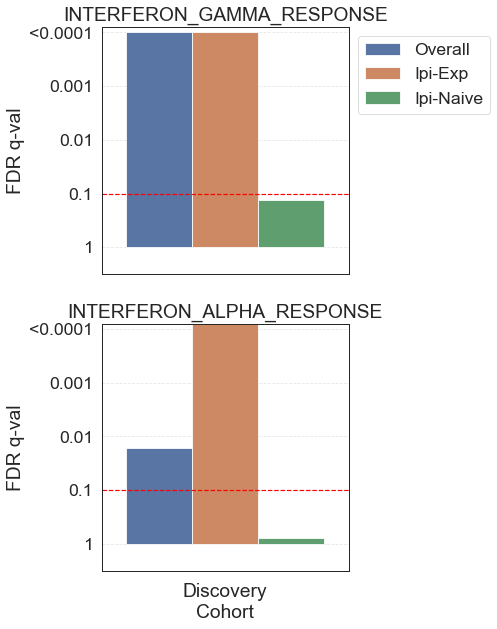

In [50]:
# Fig 3i - GSEA of interferon gamma and alpha genesets in responders vs progressors in the overall,
# ipi-experienced, ipi-naive subsets. 
pathways = [
    'INTERFERON_GAMMA_RESPONSE',
    'INTERFERON_ALPHA_RESPONSE',
]

fig = plt.figure(figsize=(5,5*len(pathways)))
nrows = len(pathways)
ncols = 2
height_ratios = [1] * nrows
width_ratios=[10, 1]
gs = gridspec.GridSpec(nrows,ncols, height_ratios = height_ratios, width_ratios = width_ratios, 
                           wspace=0.05, hspace = 0.2)

# generate the graphDF
tempDF = gseaDF.loc[pathways].reset_index()
columns = ['RvsPD Overall FDR q-val',
            'RvsPD Ipi-Exp FDR q-val',
            'RvsPD Ipi-Naive FDR q-val',
          'RvsPD Overall enriched in',
          'RvsPD Ipi-Exp enriched in',
          'RvsPD Ipi-Naive enriched in']

discCols = ['DISCOVERY ' + x for x in columns]
tempDF.rename(columns={'index':'Gene Set'}, inplace=True)
tempDF1 = tempDF[['Gene Set'] + discCols]
tempDF1.loc[:,'Cohort'] = 'Discovery'

tempDF1.rename(columns={discCols[0]:'Overall',
                      discCols[1]:'Ipi-Exp',
                      discCols[2]:'Ipi-Naive',
                       discCols[3]:'Overall enriched in',
                       discCols[4]:'Ipi-Exp enriched in',
                       discCols[5]:'Ipi-Naive enriched in'}, inplace=True)

# set FDR to 1 if enrichment is in progressors
for group in ['Overall', 'Ipi-Exp', 'Ipi-Naive']:
    enrichedProgressors = tempDF1[group + ' enriched in'] == "Progressors"
    tempDF1.loc[enrichedProgressors,group] = 1 # set FDR q-val to 1

tempDF = tempDF1
print tempDF

graphDF = pd.melt(tempDF, id_vars=['Gene Set', 'Cohort'], value_vars = ['Overall', 'Ipi-Exp', 'Ipi-Naive',
                                                                       ])
print graphDF

# generate the visualization
qval = []
for x in graphDF['value']:
    if x == 0:
        qval += [4] # 10^-4 is the limit for our q-values
    elif x == 1:
        qval += [0.1] # for visualization purposes
    else:
        q = -math.log(x,10)
        if q < 0.1:
            q = 0.1 # for visualization purposes
        qval += [q]
graphDF.loc[:,'FDR q-val'] = qval
graphDF.rename(columns={'variable':'Subgroup'}, inplace=True)

sns.set_context("paper",font_scale=2)
for i, pathway in enumerate(pathways):
    ax = plt.subplot(gs[i,0])

    sns.barplot(ax = ax, x='Cohort', y='FDR q-val', hue='Subgroup', data=graphDF[graphDF['Gene Set']==pathway])
    ax.set_title(pathway)
    ax.legend(loc="upper left", bbox_to_anchor=(1,1))
    if i > 0:
        ax.legend().set_visible(False) # only show the top one
    
    yticks = [0,1,2,3]
    yline = -math.log(0.1,10)
    ax.set_yticks([0,yline, 2,3,4])
    ax.set_yticklabels([1, 0.1,0.01, 0.001, '<0.0001'])
    xlim = 0.5
    ax.plot([-0.5,xlim],[yline,yline],color='red', linestyle='--')
    plt.xlim(-0.5,xlim)
    plt.ylim(-0.5, 4.1)
    if i < len(pathways) - 1: # not the last one
        ax.set_xticklabels([])
        ax.set_xlabel("")
    else: # set labels
        ax.set_xticklabels([])
        ax.set_xlabel("Discovery\nCohort")
        
 

                    Gene Set   Overall  Ipi-Exp  Ipi-Naive  \
0  INTERFERON_GAMMA_RESPONSE  0.000000      0.0        1.0   
1  INTERFERON_ALPHA_RESPONSE  0.003434      0.0        1.0   

  Overall enriched in Ipi-Exp enriched in Ipi-Naive enriched in      Cohort  
0          Responders          Responders           Progressors  Validation  
1          Responders          Responders           Progressors  Validation  


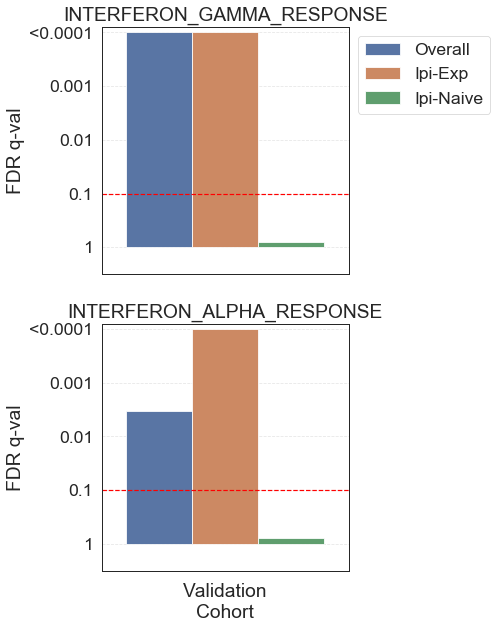

In [51]:
# Fig 3j - GSEA of interferon gamma and alpha genesets in responders vs progressors in the overall,
# ipi-experienced, ipi-naive subsets in a validation set. 
# The validation cohort was from Riaz et al Cell 2017 (https://doi.org/10.1016/j.cell.2017.09.028)
# and data taken from https://github.com/riazn/bms038_analysis

pathways = [
    'INTERFERON_GAMMA_RESPONSE',
    'INTERFERON_ALPHA_RESPONSE',
    
]

fig = plt.figure(figsize=(5,5*len(pathways)))
nrows = len(pathways)
ncols = 2
height_ratios = [1] * nrows
width_ratios=[10, 1]
gs = gridspec.GridSpec(nrows,ncols, height_ratios = height_ratios, width_ratios = width_ratios, 
                           wspace=0.05, hspace = 0.2)


# generate the graphDF
tempDF = gseaDF.loc[pathways].reset_index()
columns = ['RvsPD Overall FDR q-val',
            'RvsPD Ipi-Exp FDR q-val',
            'RvsPD Ipi-Naive FDR q-val',
          'RvsPD Overall enriched in',
          'RvsPD Ipi-Exp enriched in',
          'RvsPD Ipi-Naive enriched in']

riazCols = ['Riaz ' + x for x in columns]
tempDF.rename(columns={'index':'Gene Set'}, inplace=True)
#print tempDF
tempDF2 = tempDF[['Gene Set'] + riazCols]
tempDF2.loc[:,'Cohort'] = 'Validation'

tempDF2.rename(columns={riazCols[0]:'Overall',
                      riazCols[1]:'Ipi-Exp',
                      riazCols[2]:'Ipi-Naive',
                       riazCols[3]:'Overall enriched in',
                       riazCols[4]:'Ipi-Exp enriched in',
                       riazCols[5]:'Ipi-Naive enriched in'}, inplace=True)

# set FDR to 1 if enrichment is in progressors
for group in ['Overall', 'Ipi-Exp', 'Ipi-Naive']:
    enrichedProgressors = tempDF1[group + ' enriched in'] == "Progressors"
    tempDF1.loc[enrichedProgressors,group] = 1 # set FDR q-val to 1
    enrichedProgressors = tempDF2[group + ' enriched in'] == "Progressors"
    tempDF2.loc[enrichedProgressors,group] = 1 # set FDR q-val to 1

tempDF = tempDF2
print tempDF

graphDF = pd.melt(tempDF, id_vars=['Gene Set', 'Cohort'], value_vars = ['Overall', 'Ipi-Exp', 'Ipi-Naive',
                                                                       ])

# generate the visualization
qval = []
for x in graphDF['value']:
    if x == 0:
        qval += [4] # 10^-4 is the limit for our q-values
    elif x == 1:
        qval += [0.1] # for visualization purposes
    else:
        q = -math.log(x,10)
        if q < 0.1:
            q = 0.1 # for visualization purposes
        qval += [q]
graphDF.loc[:,'FDR q-val'] = qval
graphDF.rename(columns={'variable':'Subgroup'}, inplace=True)

sns.set_context("paper",font_scale=2)
for i, pathway in enumerate(pathways):
    ax = plt.subplot(gs[i,0])

    sns.barplot(ax = ax, x='Cohort', y='FDR q-val', hue='Subgroup', data=graphDF[graphDF['Gene Set']==pathway])
    ax.set_title(pathway)
    ax.legend(loc="upper left", bbox_to_anchor=(1,1))
    if i > 0:
        ax.legend().set_visible(False) # only show the top one
    
    yticks = [0,1,2,3]
    yline = -math.log(0.1,10)
    ax.set_yticks([0,yline, 2,3,4])
    ax.set_yticklabels([1, 0.1,0.01, 0.001, '<0.0001'])
    xlim = 0.5
    ax.plot([-0.5,xlim],[yline,yline],color='red', linestyle='--')
    plt.xlim(-0.5,xlim)
    plt.ylim(-0.5, 4.1)
    if i < len(pathways) - 1: # not the last one
        ax.set_xticklabels([])
        ax.set_xlabel("")
    else: # set the x-axis labels
        ax.set_xticklabels([])
        ax.set_xlabel("Validation\nCohort")

    

## Figure 4

In [52]:
# generate MHC-II upper (above median) and MHC-II lower (below median) groups
medianMHCII = fullDF['MHC-II'].median()
upperMHCII = list(fullDF.loc[fullDF['MHC-II']>=medianMHCII].index)
lowerMHCII = list(fullDF.loc[fullDF['MHC-II']<medianMHCII].index)

ipiExpUpperMHCII = [x for x in postIpi if x in upperMHCII]
ipiExpLowerMHCII = [x for x in postIpi if x in lowerMHCII]
ipiNaiveUpperMHCII = [x for x in noIpi if x in upperMHCII]
ipiNaiveLowerMHCII = [x for x in noIpi if x in lowerMHCII]
print "MHCII", medianMHCII, len(upperMHCII), len(lowerMHCII), len(ipiExpUpperMHCII),len(ipiExpLowerMHCII),len(ipiNaiveUpperMHCII),len(ipiNaiveLowerMHCII)

# generate absolute score (estimate of immune infiltrate) upper and lower cohorts (median split)
medianAbsoluteScore = fullDF['Absolute score'].median()
upperAS = list(fullDF.loc[fullDF['Absolute score']>=medianAbsoluteScore].index)
lowerAS = list(fullDF.loc[fullDF['Absolute score']<medianAbsoluteScore].index)

ipiExpUpperAS = [x for x in postIpi if x in upperAS]
ipiExpLowerAS = [x for x in postIpi if x in lowerAS]
ipiNaiveUpperAS = [x for x in noIpi if x in upperAS]
ipiNaiveLowerAS = [x for x in noIpi if x in lowerAS]


print "Absolute score:",medianAbsoluteScore, len(upperAS), len(lowerAS), len(ipiExpUpperAS),\
    len(ipiExpLowerAS),len(ipiNaiveUpperAS),len(ipiNaiveLowerAS)



MHCII 6990.524689 61 60 21 13 37 37
Absolute score: 1.722806734 61 60 21 13 34 40


0
             High  Low
Responders     29   18
Progressors    20   36
[[29, 18], [20, 36]]
MHC-II R vs. PD: p = 0.0104508938307 (Fisher)
MHC-II R vs. PD: OR =  2.9
1
             High  Low
Responders      9    2
Progressors     5   11
[[9, 2], [5, 11]]
Ipi-Exp MHC-II R vs. PD: p = 0.0183066361556 (Fisher)
Ipi-Exp MHC-II R vs. PD: OR =  9.9
2
             High  Low
Responders     18   13
Progressors    14   19
[[18, 13], [14, 19]]
Ipi-Naive MHC-II R vs. PD: p = 0.317145854025 (Fisher)
Ipi-Naive MHC-II R vs. PD: OR =  1.87912087912


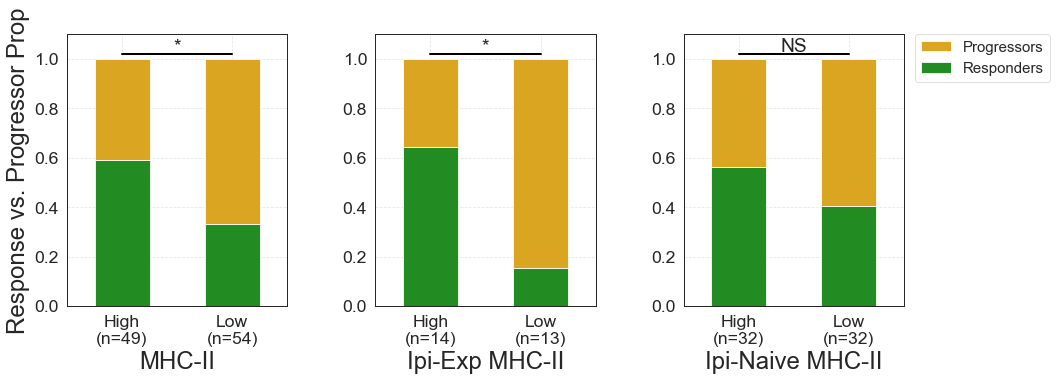

In [53]:
# Fig 4abc - proportion of responders/progressors based on high/low MHC-II expression (median split)
# in the overall, ipi-experienced, and ipi-naive cohort.
cohort = ~fullDF['Responder'].isnull() # either Responder (CR,PR) or (PD)

groups = ['MHC-II', 'Ipi-Exp MHC-II', 'Ipi-Naive MHC-II']

tempDF = fullDF[cohort][['Responder']]
comparisonGroups = {'MHC-II':[upperMHCII, lowerMHCII],
                   'Ipi-Exp MHC-II':[ipiExpUpperMHCII, ipiExpLowerMHCII],
                   'Ipi-Naive MHC-II':[ipiNaiveUpperMHCII, ipiNaiveLowerMHCII],
                   'Absolute score':[upperAS, lowerAS],
                   'Ipi-Naive Absolute score':[ipiNaiveUpperAS, ipiNaiveLowerAS],
                   'Ipi-Exp Absolute score':[ipiExpUpperAS, ipiExpLowerAS]}

ncols = len(groups)
nrows = 1
gs = gridspec.GridSpec(nrows,ncols, #height_ratios = [1, ], width_ratios = [1,1,1], 
                       wspace=0.4, hspace = 0.4)

fig = plt.figure(figsize=(5*ncols,5))
sns.set_context("paper",font_scale=2)

i = 0
for group in groups:
    ax = plt.subplot(gs[i])
    print i
    upper = comparisonGroups[group][0]
    lower = comparisonGroups[group][1]
    upperResponders = sum((tempDF['Responder']==1)&(tempDF.index.isin(upper)))
    upperNonresponders = sum((tempDF['Responder']==0)&(tempDF.index.isin(upper)))
    lowerResponders = sum((tempDF['Responder']==1)&(tempDF.index.isin(lower)))
    lowerNonresponders = sum((tempDF['Responder']==0)&(tempDF.index.isin(lower)))
    graphDF = pd.DataFrame([[upperResponders,
                       upperNonresponders],
                       [lowerResponders,
                       lowerNonresponders]], 
                       index = ['High', 'Low'],
                      columns = ['Responders', 'Progressors']).transpose()
    print graphDF

    orderedCategories = {
                    'MHC-II':['High', 'Low'],
                    'Ipi-Exp MHC-II':['High', 'Low'],
                    'Ipi-Naive MHC-II':['High', 'Low'],
                    'Absolute score':['High','Low'],
                    'Ipi-Exp Absolute score':['High','Low'],
                    'Ipi-Naive Absolute score':['High','Low']}

    if group in orderedCategories:
        groupOrder = orderedCategories[group]
    else:
        groupOrder = graphDF.columns
    colorList = [GRAY, RESPONDER_COL, NRESPONDER_COL]

    categories = ['Responders', 'Progressors']
    if i == len(groups) - 1: # only display if last one
        legendSize = 15
    else:
        legendSize = None # 
        
    PlotStackedBarPlot(ax, graphDF.loc[categories, groupOrder], xlabel=True, sigOrder = categories, normalize=True, 
                    colorList=colorList,legendSize=legendSize)
    plt.xlabel(group, fontsize=24)
    xlabels = []
    for label in groupOrder:
        total = graphDF[label].sum()
        xlabels += [label + "\n(n=" + str(total)+")"]
    ax.set_xticklabels(xlabels,rotation=0)
    if i == 0:
        plt.ylabel("Response vs. Progressor Prop", fontsize=24)
    
    # statistically compare values
    fishersMatrix = [[graphDF.loc['Responders', 'High'], graphDF.loc['Responders', 'Low']], 
                        [graphDF.loc['Progressors', 'High'], graphDF.loc['Progressors', 'Low']]]
    print fishersMatrix
    oddsratio, pval_fisher = stats.fisher_exact(fishersMatrix)
       
    print group, "R vs. PD: p =", pval_fisher, "(Fisher)"
    print group, "R vs. PD: OR = ", oddsratio 

    # plot the significance comparison
    sig = "NS"
    if pval_fisher <= 0.15:
        sig = "p=" + "{:.3f}".format(pval_fisher)
    if pval_fisher <= 0.05:
        sig = "*"
    if pval_fisher <= 0.01:
        sig = "**"
    if pval_fisher <= 0.001:
        sig = "***"
    
    yMax = 1
    plt.plot([0,1],[yMax * 1.02,yMax * 1.02], lw=2, color="black")  
   
    plt.text(0.5,yMax * 1.03,sig, ha='center')
    plt.ylim(0,yMax * 1.1)

    i+=1


0
             High  Low
Responders     27   20
Progressors    24   32
[[27, 20], [24, 32]]
Absolute score R vs. PD: p = 0.168254982619 (Fisher)
Absolute score R vs. PD: OR =  1.8
1
             High  Low
Responders     10    1
Progressors     7    9
[[10, 1], [7, 9]]
Ipi-Exp Absolute score R vs. PD: p = 0.0183183711788 (Fisher)
Ipi-Exp Absolute score R vs. PD: OR =  12.8571428571
2
             High  Low
Responders     14   17
Progressors    15   18
[[14, 17], [15, 18]]
Ipi-Naive Absolute score R vs. PD: p = 1.0 (Fisher)
Ipi-Naive Absolute score R vs. PD: OR =  0.988235294118


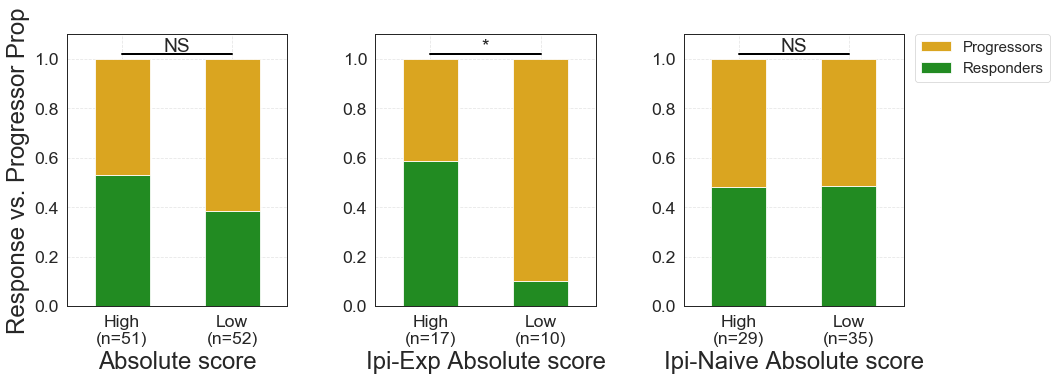

In [54]:
# Fig 4def - proportion of responders/progressors based on high/low immune infiltrate (median split)
# in the overall, ipi-experienced, and ipi-naive cohort.
cohort = ~fullDF['Responder'].isnull() # either Responder (CR,PR) or (PD)

groups = ['Absolute score', 'Ipi-Exp Absolute score', 'Ipi-Naive Absolute score']

tempDF = fullDF[cohort][['Responder']]
comparisonGroups = {'MHC-II':[upperMHCII, lowerMHCII],
                   'Ipi-Exp MHC-II':[ipiExpUpperMHCII, ipiExpLowerMHCII],
                   'Ipi-Naive MHC-II':[ipiNaiveUpperMHCII, ipiNaiveLowerMHCII],
                   'Absolute score':[upperAS, lowerAS],
                   'Ipi-Naive Absolute score':[ipiNaiveUpperAS, ipiNaiveLowerAS],
                   'Ipi-Exp Absolute score':[ipiExpUpperAS, ipiExpLowerAS]}

ncols = len(groups)
nrows = 1
gs = gridspec.GridSpec(nrows,ncols, #height_ratios = [1, ], width_ratios = [1,1,1], 
                       wspace=0.4, hspace = 0.4)

fig = plt.figure(figsize=(5*ncols,5))
sns.set_context("paper",font_scale=2)

i = 0
for group in groups:
    ax = plt.subplot(gs[i])
    print i
    upper = comparisonGroups[group][0]
    lower = comparisonGroups[group][1]
    upperResponders = sum((tempDF['Responder']==1)&(tempDF.index.isin(upper)))
    upperNonresponders = sum((tempDF['Responder']==0)&(tempDF.index.isin(upper)))
    lowerResponders = sum((tempDF['Responder']==1)&(tempDF.index.isin(lower)))
    lowerNonresponders = sum((tempDF['Responder']==0)&(tempDF.index.isin(lower)))
    graphDF = pd.DataFrame([[upperResponders,
                       upperNonresponders],
                       [lowerResponders,
                       lowerNonresponders]], 
                       index = ['High', 'Low'],
                      columns = ['Responders', 'Progressors']).transpose()
    print graphDF

    orderedCategories = {
                    'MHC-II':['High', 'Low'],
                    'Ipi-Exp MHC-II':['High', 'Low'],
                    'Ipi-Naive MHC-II':['High', 'Low'],
                    'Absolute score':['High','Low'],
                    'Ipi-Exp Absolute score':['High','Low'],
                    'Ipi-Naive Absolute score':['High','Low']}

    if group in orderedCategories:
        groupOrder = orderedCategories[group]
    else:
        groupOrder = graphDF.columns
    colorList = [GRAY, RESPONDER_COL, NRESPONDER_COL]

    categories = ['Responders', 'Progressors']
    if i == len(groups) - 1: # only display if last one
        legendSize = 15
    else:
        legendSize = None # 
        
    PlotStackedBarPlot(ax, graphDF.loc[categories, groupOrder], xlabel=True, sigOrder = categories, normalize=True, 
                    colorList=colorList,legendSize=legendSize)
    plt.xlabel(group, fontsize=24)
    xlabels = []
    for label in groupOrder:
        total = graphDF[label].sum()
        xlabels += [label + "\n(n=" + str(total)+")"]
    ax.set_xticklabels(xlabels,rotation=0)
    if i == 0:
        plt.ylabel("Response vs. Progressor Prop", fontsize=24)
    
    # statistically compare values
    fishersMatrix = [[graphDF.loc['Responders', 'High'], graphDF.loc['Responders', 'Low']], 
                        [graphDF.loc['Progressors', 'High'], graphDF.loc['Progressors', 'Low']]]
    print fishersMatrix
    oddsratio, pval_fisher = stats.fisher_exact(fishersMatrix)
       
    print group, "R vs. PD: p =", pval_fisher, "(Fisher)"
    print group, "R vs. PD: OR = ", oddsratio 

    # plot the significance comparison
    sig = "NS"
    if pval_fisher <= 0.15:
        sig = "p=" + "{:.3f}".format(pval_fisher)
    if pval_fisher <= 0.05:
        sig = "*"
    if pval_fisher <= 0.01:
        sig = "**"
    if pval_fisher <= 0.001:
        sig = "***"
    
    yMax = 1
    plt.plot([0,1],[yMax * 1.02,yMax * 1.02], lw=2, color="black")  
   
    plt.text(0.5,yMax * 1.03,sig, ha='center')
    plt.ylim(0,yMax * 1.1)

    i+=1


## Figure 5

In [55]:
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression


In [56]:
# generate regDFs
# define the quant and categorical variables we will include
#quantVars = list(csDF.columns) 

quantVars = [
            'log nonsyn mutload',
              'heterogeneity',
              'purity',
                'ploidy',
               'Tx_Start_LDH',
                ]

categVars = [
                'LN_Met',
            ]


In [57]:
# create a set of regression DFs for each comparison and cohort, e.g. regDFs['Ipi-exp PDvsnPD']
regDFs = {}

# generate regression DF for hallmark signatures
variables = ssGSEADF.columns 
outcomeGroups = {'Ipi-exp PD vs nPD': [PDpostIpi, nPDpostIpi],
                'Ipi-naive PD vs nPD': [PDnoIpi, nPDnoIpi],
                 'PD vs nPD': [progressors, nonprogressors],
                }
for outcome in outcomeGroups:
    group1 = [x for x in outcomeGroups[outcome][0] if x in ssGSEADF.index]
    group0 = [x for x in outcomeGroups[outcome][1] if x in ssGSEADF.index]
    tempDF = ssGSEADF.copy()
    tempDF.loc[group1, 'outcome'] = 1
    tempDF.loc[group0, 'outcome'] = 0
    # remove rows with 'na' as outcome
    tempDF = tempDF[~tempDF['outcome'].isnull()]
    regDFs[outcome] = tempDF
    print outcome,":",len(tempDF.index),'patients and', len(tempDF.columns),'signatures'


Ipi-naive PD vs nPD : 74 patients and 55 signatures
Ipi-exp PD vs nPD : 34 patients and 55 signatures
PD vs nPD : 121 patients and 55 signatures


In [58]:
# GenRegDF
# -----------
# given a dataset, outcome of interest, categorical and continuous variables
# generates a standardized df with each continuous variable scaled
# from 0-1 and also binary variables for Q1, Q4, upper and lower
# halves of quantitative variables.

def GenRegDF (df, categVars, quantVars, outcome = None):
    # grab the patients with valid outcomes
    if outcome is not None:
        regDF = df[df[outcome].apply(np.isreal) & ~df[outcome].isnull()][[outcome] + quantVars] # get ones with outcomes
    else:
        regDF = df[quantVars]
        
    nullQuants = []
    for quantVar in quantVars:
        # clean up quantitative variables for missing values and non-quantitative values
        regDF.loc[regDF.index, quantVar] = pd.to_numeric(regDF[quantVar], errors = 'coerce') # convert to numeric, NaN if not numeric
        if sum(regDF[quantVar].isnull()) > 0:
            print quantVar,"has", sum(regDF[quantVar].isnull()),"null values"
            nullQuants += [quantVar]

        median = regDF[quantVar].median()
        print quantVar, "median:", median
        aboveMedian = regDF[quantVar] > median
        belowMedian = regDF[quantVar] <= median

        regDF.loc[:,quantVar + "_upper"] = 0
        regDF.loc[aboveMedian, quantVar + "_upper"] = 1

        regDF.loc[:,quantVar + "_lower"] = 0
        regDF.loc[belowMedian, quantVar + "_lower"] = 1

    # generate dummy variables for categorical variables
    for categVar in categVars:
        dummyDF = pd.get_dummies(df[categVar], prefix=categVar)
        cols = dummyDF.columns
        regDF = regDF.merge(dummyDF.iloc[:,1:], left_index=True, right_index = True)

    # rescale variables
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0,1))
    goodFeatures = [x for x in regDF.columns if x not in nullQuants]
    tempDF = pd.DataFrame(scaler.fit_transform(regDF[goodFeatures]), index = regDF.index, columns = goodFeatures)
    tempDF[nullQuants] = regDF[nullQuants] # pass through without scaling
    regDF = tempDF

    # generate intercept
    regDF['intercept'] = 1

    print "Total variables in regression DF:", len(regDF.columns) - 1
    return regDF

In [59]:
# generate regDFs
fullRegDFs = {}
outcomeGroups = ['Ipi-exp PD vs nPD',
                 'Ipi-naive PD vs nPD',
                'PD vs nPD',
                ]
for outcome in outcomeGroups:
    regDF = regDFs[outcome]

    print len(regDF.index),"entries in regDF"

    # generate the regDF for DNA and clinical variables
    tempDF = GenRegDF(fullDF[categVars + quantVars], categVars, quantVars)
    print len(tempDF.index),"entries in tempDF"

    # join with our existing DF and the single cell sigantures
    regDF = regDF.merge(tempDF, how='inner', left_index=True, right_index=True)

    # remove variables with variance 0
    regDF = regDF.loc[:,regDF.var() != 0]

    # add intercept
    regDF['intercept'] = 1

    # save off
    fullRegDFs[outcome] = regDF
    print outcome,":",len(regDF.index),"patients and",len(regDF.columns),"features" 


34 entries in regDF
log nonsyn mutload median: 2.38916608436
heterogeneity median: 0.174545454545
purity median: 0.7
ploidy median: 2.13
Tx_Start_LDH has 3 null values
Tx_Start_LDH median: 247.0
Total variables in regression DF: 16
121 entries in tempDF
Ipi-exp PD vs nPD : 34 patients and 72 features
74 entries in regDF
log nonsyn mutload median: 2.38916608436
heterogeneity median: 0.174545454545
purity median: 0.7
ploidy median: 2.13
Tx_Start_LDH has 3 null values
Tx_Start_LDH median: 247.0
Total variables in regression DF: 16
121 entries in tempDF
Ipi-naive PD vs nPD : 74 patients and 72 features
121 entries in regDF
log nonsyn mutload median: 2.38916608436
heterogeneity median: 0.174545454545
purity median: 0.7
ploidy median: 2.13
Tx_Start_LDH has 3 null values
Tx_Start_LDH median: 247.0
Total variables in regression DF: 16
121 entries in tempDF
PD vs nPD : 121 patients and 72 features


[None, None]

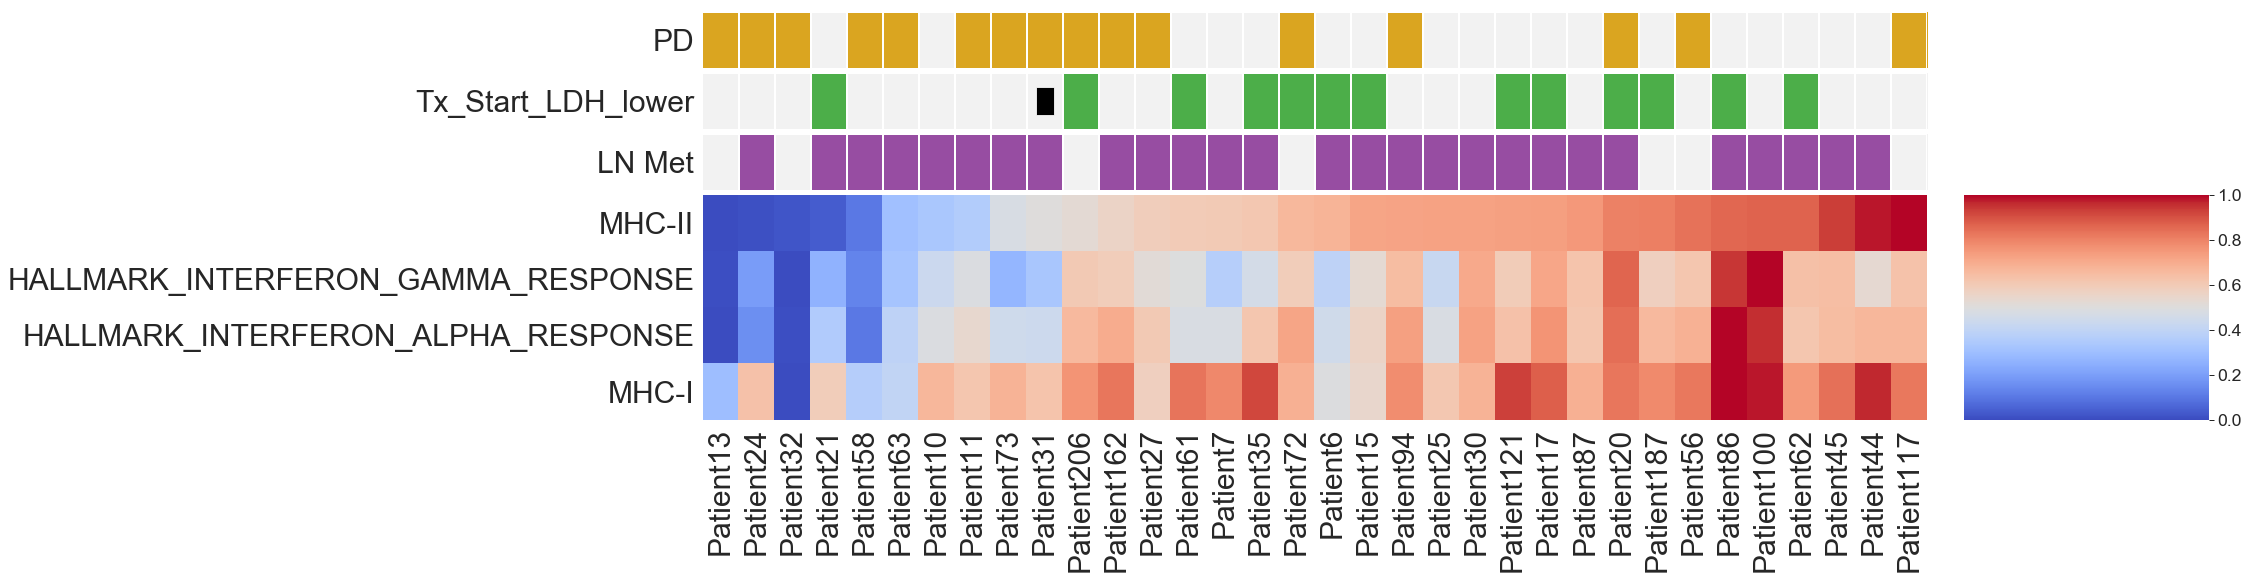

In [60]:
# Fig 5a - features that predict PD in the ipi-experienced cohort
from sklearn.preprocessing import MinMaxScaler

outcome = 'Ipi-exp PD vs nPD'
geneSet = ['MHC-II', 'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_INTERFERON_ALPHA_RESPONSE',
          'MHC-I']
additionalFeatures = ['Tx_Start_LDH_lower', 'LN_Met_1.0']
regDF = fullRegDFs[outcome]
df = regDF[~regDF['outcome'].isnull()][geneSet + ['outcome'] + additionalFeatures]
scaler = MinMaxScaler(feature_range=(0,1))
df = pd.DataFrame(scaler.fit_transform(df), index = df.index, columns = df.columns)

outcomeLabel = 'PD'

#graph order by variable values
orderGenes = ['MHC-II']
sampleOrder = [df.index.get_loc(x) for x in df.sort_values(orderGenes).index]
samples = df.sort_values(orderGenes).index

#Now graph the comut plots

#reorder the geneSet
graphDF = df.iloc[sampleOrder][geneSet].transpose()

groupDF = pd.DataFrame(columns = df.index[sampleOrder])
groupDF.loc[outcomeLabel] = df.iloc[sampleOrder]['outcome']
groupDF.loc['LN Met'] = fullDF.loc[samples]['LN_Met']

groupDF.loc['Tx_Start_LDH_lower'] = df.iloc[sampleOrder]['Tx_Start_LDH_lower']
groupDF.loc['Tx_Start_LDH_lower_null'] = fullDF.loc[samples]['Tx_Start_LDH'].isin(['unknown'])

groupDF.fillna(0, inplace=True)

fig = plt.figure(figsize = (27,2.7+1.2*len(geneSet)))

nrows = 4
height_ratios = [1,1,1,1*len(geneSet)]
ncols = 2
    
gs = gridspec.GridSpec(nrows,ncols, height_ratios = height_ratios, width_ratios = [5,1], 
                           wspace=0.05, hspace = 0.05)
    
heatmapPlot = plt.subplot(gs[3,0])
cbarPlot = plt.subplot(gs[3,1])
sns.heatmap(graphDF, ax=heatmapPlot, cmap="coolwarm", cbar_ax=cbarPlot)

plt.setp(heatmapPlot.get_yticklabels(), size=30) 
plt.setp(heatmapPlot.get_xticklabels(), size=30) 


#generate response plot
groupPlot = plt.subplot(gs[0,0])
CreateCoMutFig(groupPlot, groupDF.loc[[outcomeLabel]].astype(int), [GRAY, PD_COL])
plt.setp(groupPlot.get_xticklabels(), visible = False) # suppress x labels
plt.setp(groupPlot.get_yticklabels(), size=30) 

# generate LDH plot
ldhPlot = plt.subplot(gs[1,0])
CreateCoMutFig(ldhPlot, groupDF.loc[['Tx_Start_LDH_lower']].astype(int), [GRAY, CR_COL])
# set missing values
AddMarkersCoMutFig(ldhPlot, groupDF.loc[['Tx_Start_LDH_lower_null']], [GRAY, 'black'])

plt.setp(ldhPlot.get_xticklabels(), visible = False) # suppress x labels
plt.setp(ldhPlot.get_yticklabels(), size=30) 


#generate lymph node met plot
lnPlot = plt.subplot(gs[2,0])

CreateCoMutFig(lnPlot, groupDF.loc[['LN Met']].astype(int), [GRAY, LN_COL])
plt.setp(lnPlot.get_xticklabels(), visible = False) # suppress x labels
plt.setp(lnPlot.get_yticklabels(), size=30) 


[None, None]

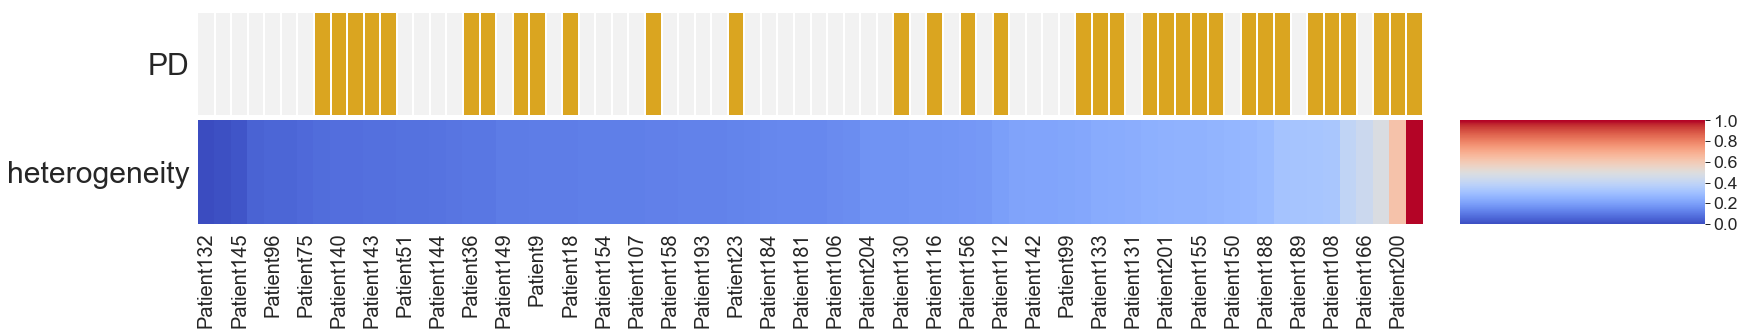

In [61]:
# Fig 5c - features that predict PD in the ipi-naive cohort
from sklearn.preprocessing import MinMaxScaler

outcome = 'Ipi-naive PD vs nPD'
geneSet = ['heterogeneity', 'ploidy', 'purity']
additionalFeatures = []
regDF = fullRegDFs[outcome]
df = regDF[~regDF['outcome'].isnull()][geneSet + ['outcome'] + additionalFeatures]
scaler = MinMaxScaler(feature_range=(0,1))
df = pd.DataFrame(scaler.fit_transform(df), index = df.index, columns = df.columns)

outcomeLabel = 'PD'

#sample order by variable value 
orderGenes = ['heterogeneity']
sampleOrder = [df.index.get_loc(x) for x in df.sort_values(orderGenes).index]
samples = df.sort_values(orderGenes).index

#Now graph the comut plots
#reorder the geneSet
orderFirst = ['heterogeneity']
geneSet = orderFirst 

groupDF = pd.DataFrame(columns = df.index[sampleOrder])
groupDF.loc[outcomeLabel] = df.iloc[sampleOrder]['outcome']

groupDF.fillna(0, inplace=True)

fig = plt.figure(figsize = (27,2.7+1.2*len(geneSet)))

nrows = 2
height_ratios = [1,1*len(geneSet)]
ncols = 2
    
gs = gridspec.GridSpec(nrows,ncols, height_ratios = height_ratios, width_ratios = [5,1], 
                           wspace=0.05, hspace = 0.05)
    
heatmapPlot = plt.subplot(gs[1,0])
cbarPlot = plt.subplot(gs[1,1])
sns.heatmap(df.loc[samples,geneSet].transpose(), ax=heatmapPlot, cmap="coolwarm", cbar_ax=cbarPlot)

plt.setp(heatmapPlot.get_yticklabels(), size=30, rotation=0) 
plt.setp(heatmapPlot.get_xticklabels(), size=20) 


#generate response plot
groupPlot = plt.subplot(gs[0,0])
CreateCoMutFig(groupPlot, groupDF.loc[[outcomeLabel]].astype(int), [GRAY, PD_COL])
plt.setp(groupPlot.get_xticklabels(), visible = False) # suppress x labels
plt.setp(groupPlot.get_yticklabels(), size=30) 

[None, None]

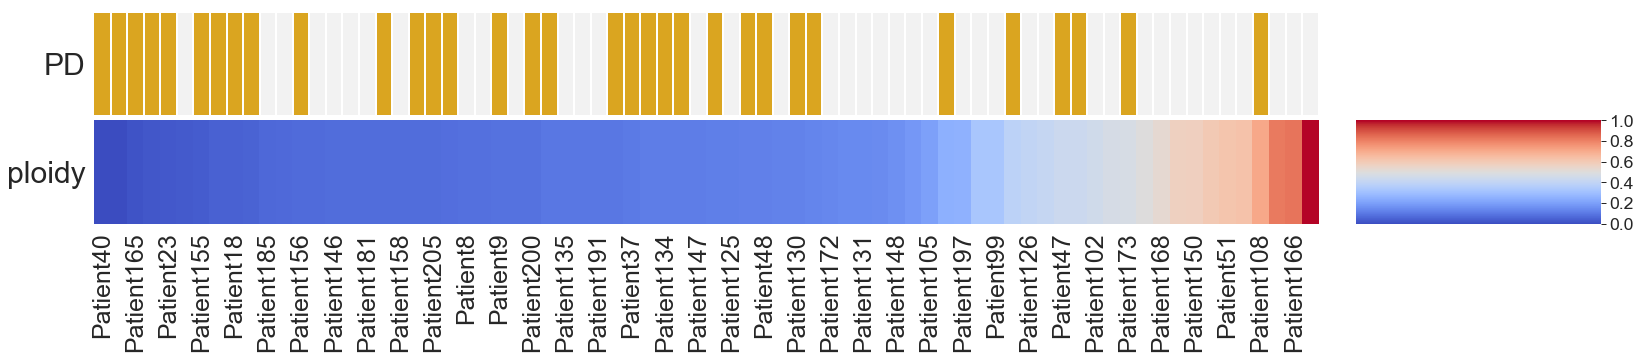

In [62]:
# Fig 5c - features that predict PD in the ipi-naive cohort
from sklearn.preprocessing import MinMaxScaler

outcome = 'Ipi-naive PD vs nPD'
geneSet = ['heterogeneity', 'ploidy', 'purity']
additionalFeatures = []
regDF = fullRegDFs[outcome]
df = regDF[~regDF['outcome'].isnull()][geneSet + ['outcome'] + additionalFeatures]
scaler = MinMaxScaler(feature_range=(0,1))
df = pd.DataFrame(scaler.fit_transform(df), index = df.index, columns = df.columns)

outcomeLabel = 'PD'

#alternately, graph order by other variable values
orderGenes = ['ploidy']
sampleOrder = [df.index.get_loc(x) for x in df.sort_values(orderGenes).index]
samples = df.sort_values(orderGenes).index

#Now graph the comut plots
#reorder the geneSet
orderFirst = ['ploidy']
geneSet = orderFirst 

groupDF = pd.DataFrame(columns = df.index[sampleOrder])
groupDF.loc[outcomeLabel] = df.iloc[sampleOrder]['outcome']

groupDF.fillna(0, inplace=True)

fig = plt.figure(figsize = (27,2.7+1.2*len(geneSet)))

nrows = 2
height_ratios = [1,1*len(geneSet)]
ncols = 2
    
gs = gridspec.GridSpec(nrows,ncols, height_ratios = height_ratios, width_ratios = [5,1], 
                           wspace=0.05, hspace = 0.05)
    
heatmapPlot = plt.subplot(gs[1,0])
cbarPlot = plt.subplot(gs[1,1])
sns.heatmap(df.loc[samples,geneSet].transpose(), ax=heatmapPlot, cmap="coolwarm", cbar_ax=cbarPlot)

plt.setp(heatmapPlot.get_yticklabels(), size=30, rotation=0) 
plt.setp(heatmapPlot.get_xticklabels(), size=25) 


#generate response plot
groupPlot = plt.subplot(gs[0,0])
CreateCoMutFig(groupPlot, groupDF.loc[[outcomeLabel]].astype(int), [GRAY, PD_COL])
plt.setp(groupPlot.get_xticklabels(), visible = False) # suppress x labels
plt.setp(groupPlot.get_yticklabels(), size=30) 

[None, None]

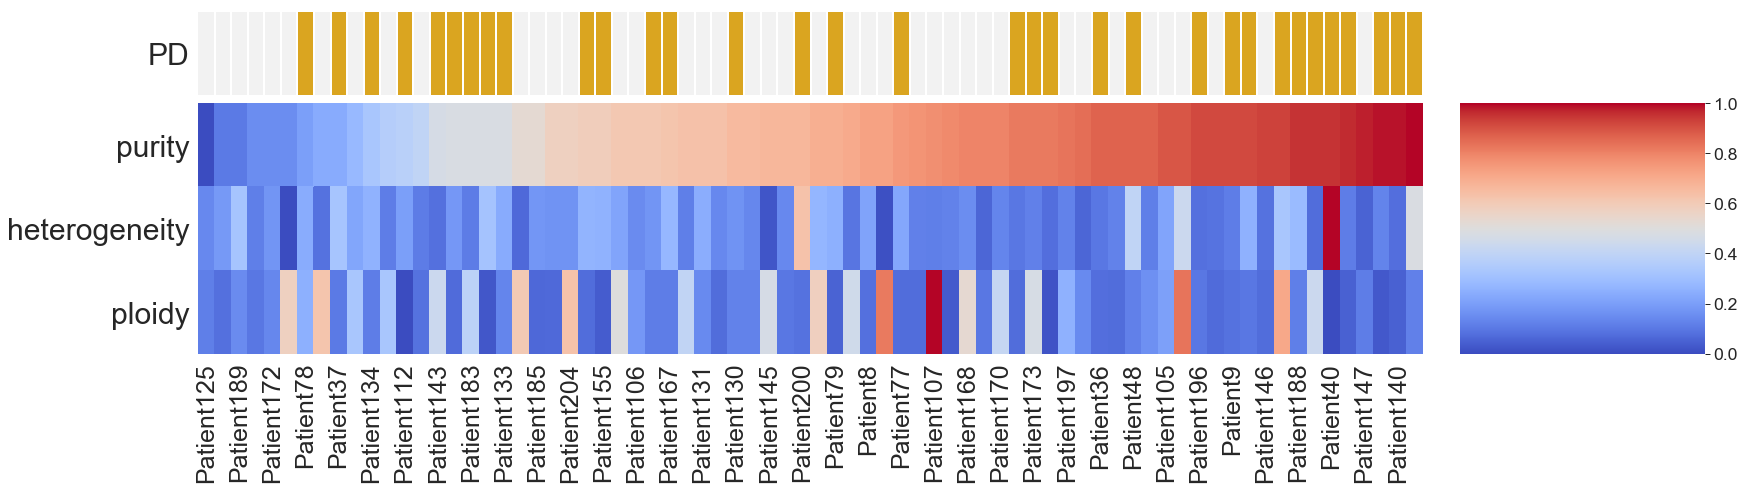

In [63]:
# Fig 5c - features that predict PD in the ipi-naive cohort
from sklearn.preprocessing import MinMaxScaler

outcome = 'Ipi-naive PD vs nPD'
geneSet = ['heterogeneity', 'ploidy', 'purity']
additionalFeatures = []
regDF = fullRegDFs[outcome]
df = regDF[~regDF['outcome'].isnull()][geneSet + ['outcome'] + additionalFeatures]
scaler = MinMaxScaler(feature_range=(0,1))
df = pd.DataFrame(scaler.fit_transform(df), index = df.index, columns = df.columns)

outcomeLabel = 'PD'

#sample order by variable value 
orderGenes = ['purity']
sampleOrder = [df.index.get_loc(x) for x in df.sort_values(orderGenes).index]
samples = df.sort_values(orderGenes).index

#Now graph the comut plots
#reorder the geneSet
orderFirst = ['purity', 'heterogeneity', 'ploidy']
geneSet = orderFirst 

groupDF = pd.DataFrame(columns = df.index[sampleOrder])
groupDF.loc[outcomeLabel] = df.iloc[sampleOrder]['outcome']

groupDF.fillna(0, inplace=True)

fig = plt.figure(figsize = (27,2.7+1.2*len(geneSet)))

nrows = 2
height_ratios = [1,1*len(geneSet)]
ncols = 2
    
gs = gridspec.GridSpec(nrows,ncols, height_ratios = height_ratios, width_ratios = [5,1], 
                           wspace=0.05, hspace = 0.05)
    
heatmapPlot = plt.subplot(gs[1,0])
cbarPlot = plt.subplot(gs[1,1])
sns.heatmap(df.loc[samples,geneSet].transpose(), ax=heatmapPlot, cmap="coolwarm", cbar_ax=cbarPlot)

plt.setp(heatmapPlot.get_yticklabels(), size=30, rotation=0) 
plt.setp(heatmapPlot.get_xticklabels(), size=25) 


#generate response plot
groupPlot = plt.subplot(gs[0,0])
CreateCoMutFig(groupPlot, groupDF.loc[[outcomeLabel]].astype(int), [GRAY, PD_COL])
plt.setp(groupPlot.get_xticklabels(), visible = False) # suppress x labels
plt.setp(groupPlot.get_yticklabels(), size=30) 

Optimization terminated successfully.
         Current function value: 0.415459
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                   34
Model:                          Logit   Df Residuals:                       30
Method:                           MLE   Df Model:                            3
Date:                Mon, 23 Dec 2019   Pseudo R-squ.:                  0.3991
Time:                        01:00:44   Log-Likelihood:                -14.126
converged:                       True   LL-Null:                       -23.508
                                        LLR p-value:                 0.0003057
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
MHC-II                -0.0008      0.000     -2.133      0.033      -0.002   -6.82e-05
LN_Me

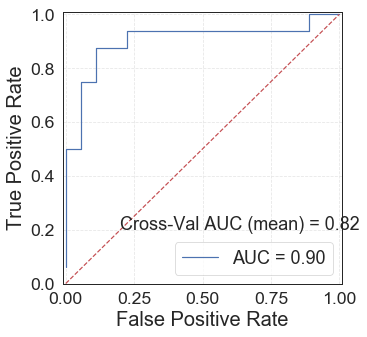

In [64]:
# Fig 5b - ROC and AUC for ipi-experienced model
outcomes = ['Ipi-exp PD vs nPD']
features = [
             'MHC-II',
                'LN_Met_1.0',
            'Tx_Start_LDH_lower',
           ]

figure = plt.figure(figsize = (5,5*len(outcomes)))
nrows = len(outcomes)
ncols = 1
gs = gridspec.GridSpec(nrows,ncols, height_ratios = [1]*len(outcomes), width_ratios = [1], 
                       wspace=0.05, hspace = 0.3)

for i, outcome in enumerate(outcomes):
    regDF = fullRegDFs[outcome]
    df = regDF[~regDF['outcome'].isnull()]
    for feature in features:
        if sum(df[feature].isnull()) > 0:
            print "removing", sum(df[feature].isnull()), "samples for null", feature,"value"
        df = df[~df[feature].isnull()]
        
    # add intercept
    df['intercept'] = 1
    logitModel = sm.Logit(df['outcome'], df[features + ['intercept']])
    result = logitModel.fit()
    print result.summary()
    auc = roc_auc_score(df['outcome'], result.predict(df[features + ['intercept']]))
    print "AUC:", auc
    fpr, tpr, threshold = roc_curve(df['outcome'], result.predict(df[features + ['intercept']]))
    crossval_scores = cross_val_score(LogisticRegression(), df[features + ['intercept']], 
                                      df['outcome'], scoring='roc_auc', cv=5)
    print crossval_scores, crossval_scores.mean()

    ax = plt.subplot(gs[i])
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right', prop={'size':18})
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([0, 1.01])
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.text(0.2,0.2,"\nCross-Val AUC (mean) = %0.2f" % crossval_scores.mean(),size=18)
    




Optimization terminated successfully.
         Current function value: 0.581509
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                   84
Model:                          Logit   Df Residuals:                       80
Method:                           MLE   Df Model:                            3
Date:                Mon, 23 Dec 2019   Pseudo R-squ.:                  0.1524
Time:                        01:00:45   Log-Likelihood:                -48.847
converged:                       True   LL-Null:                       -57.628
                                        LLR p-value:                 0.0005415
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
purity            2.2168      1.128      1.965      0.049       0.005       4.428
ploidy           -0.

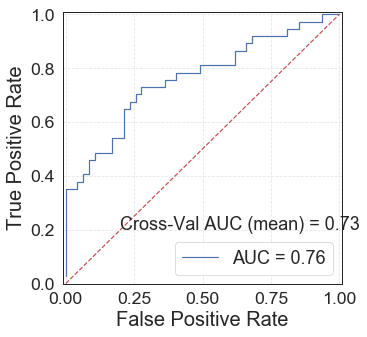

In [65]:
# Fig 5d - ROC and AUC for ipi-naive model
outcomes = ['Ipi-naive PD vs nPD']
features = [
             'purity',
                'ploidy',
            'heterogeneity',
           ]

figure = plt.figure(figsize = (5,5*len(outcomes)))
nrows = len(outcomes)
ncols = 1
gs = gridspec.GridSpec(nrows,ncols, height_ratios = [1]*len(outcomes), width_ratios = [1], 
                       wspace=0.05, hspace = 0.3)

tempRegDF = tumorDF.copy()
tempRegDF['outcome'] = 0
tempRegDF.loc[progressors,'outcome'] = 1
# limit to ipinaive only
tempRegDF = tempRegDF.loc[noIpi]

for i, outcome in enumerate(outcomes):
#    regDF = fullRegDFs[outcome]
    regDF = tempRegDF
    df = regDF[~regDF['outcome'].isnull()]
    for feature in features:
        if sum(df[feature].isnull()) > 0:
            print "removing", sum(df[feature].isnull()), "samples for null", feature,"value"
        df = df[~df[feature].isnull()]
        
    # add intercept
    df['intercept'] = 1
    logitModel = sm.Logit(df['outcome'], df[features + ['intercept']])
    result = logitModel.fit()
    print result.summary()
    auc = roc_auc_score(df['outcome'], result.predict(df[features + ['intercept']]))
    print "AUC:", auc
    fpr, tpr, threshold = roc_curve(df['outcome'], result.predict(df[features + ['intercept']]))
    crossval_mean = 0.73
    
    ax = plt.subplot(gs[i])
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right', prop={'size':18})
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([0, 1.01])
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.text(0.2,0.2,"\nCross-Val AUC (mean) = %0.2f" % crossval_mean,size=18)
    
    # cross validation auc
    crossval_scores = cross_val_score(LogisticRegression(), df[features + ['intercept']], 
                                      df['outcome'], scoring='roc_auc', cv=10)
    print crossval_scores, crossval_scores.mean()



In [66]:
# Generate model scores for each outcome and model
modelScores = {}
# models applied across all tumors, split out by outcome which indicates the specific model
allTumorScores = {}

Optimization terminated successfully.
         Current function value: 0.415459
         Iterations 7
AUC: 0.902777777778
Optimization terminated successfully.
         Current function value: 0.581509
         Iterations 6
AUC: 0.763082231167


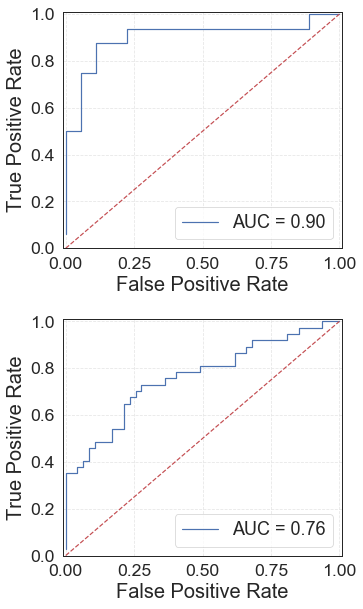

In [67]:
# Generate the models and AUCs for our current cohort 
outcomes = ['Ipi-exp PD vs nPD', 
            'Ipi-naive PD vs nPD']
features = {'Ipi-exp PD vs nPD': ['MHC-II', 'LN_Met_1.0', 'Tx_Start_LDH_lower'],
            'Ipi-naive PD vs nPD': ['heterogeneity', 'ploidy', 'purity']}

# since the ipi-naive model uses only genomic features, use all available tumors
tempRegDF = tumorDF.copy()
tempRegDF['outcome'] = 0
tempRegDF.loc[progressors,'outcome'] = 1
# limit to ipinaive only
tempRegDF = tempRegDF.loc[noIpi]
genomicRegDF={'Ipi-naive PD vs nPD':tempRegDF}

cohorts = {'Ipi-exp PD vs nPD': fullRegDFs,
          'Ipi-naive PD vs nPD': genomicRegDF}


figure = plt.figure(figsize = (5,5*len(outcomes)))
nrows = len(outcomes)
ncols = 1
gs = gridspec.GridSpec(nrows,ncols, height_ratios = [1]*len(outcomes), width_ratios = [1], 
                       wspace=0.05, hspace = 0.3)

for i, outcome in enumerate(outcomes):
    regDF = cohorts[outcome][outcome] 
    df = regDF[~regDF['outcome'].isnull()]
    for feature in features[outcome]:
        if sum(df[feature].isnull()) > 0:
            print "removing", sum(df[feature].isnull()), "samples for null", feature,"value"
        df = df[~df[feature].isnull()]
        
    # add intercept
    df['intercept'] = 1
    logitModel = sm.Logit(df['outcome'], df[features[outcome] + ['intercept']])
    result = logitModel.fit()
    auc = roc_auc_score(df['outcome'], result.predict(df[features[outcome] + ['intercept']]))
    print "AUC:", auc
    fpr, tpr, threshold = roc_curve(df['outcome'], result.predict(df[features[outcome] + ['intercept']]))

    ax = plt.subplot(gs[i])
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right', prop={'size':18})
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([0, 1.01])
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.xlabel('False Positive Rate', fontsize=20)
    
    # save scores off
    modelScores[outcome] = result.predict(df[features[outcome] + ['intercept']])
    allTumorScores[outcome] = result.predict(fullRegDFs['PD vs nPD'][features[outcome] + ['intercept']])

In [68]:
outcomes = ['Ipi-naive PD vs nPD',
           'Ipi-exp PD vs nPD']
ipiNaive = modelScores['Ipi-naive PD vs nPD']
ipiNaiveUpper = ipiNaive[ipiNaive>=ipiNaive.median()].index
ipiNaiveLower = ipiNaive[ipiNaive<ipiNaive.median()].index

print len(ipiNaiveUpper), len(ipiNaiveLower)

ipiExp = modelScores['Ipi-exp PD vs nPD']
ipiExpUpper = ipiExp[ipiExp>=ipiExp.median()].index
ipiExpLower = ipiExp[ipiExp<ipiExp.median()].index
print len(ipiExpUpper), len(ipiExpLower)



42 42
17 17


Low Model Score : 17
PFS median 38.0666666667
High Model Score : 17
PFS median 2.83333333333
[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0]
['Low Model Score   17\nHigh Model Score   17', '10\n1', '10\n1', '9\n0', '3\n0', '1\n0', '0\n0']
<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  log(p)     
         15.47 <0.005   -9.39  ***
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0.05 ' ' 1


/Users/davidliu/anaconda2/envs/combi-d/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs [u'c', u'color'] which are all aliases for u'color'.  Kept value from u'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/davidliu/anaconda2/envs/combi-d/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs [u'c', u'color'] which are all aliases for u'color'.  Kept value from u'color'
  seen=seen, canon=canonical, used=seen[-1]))


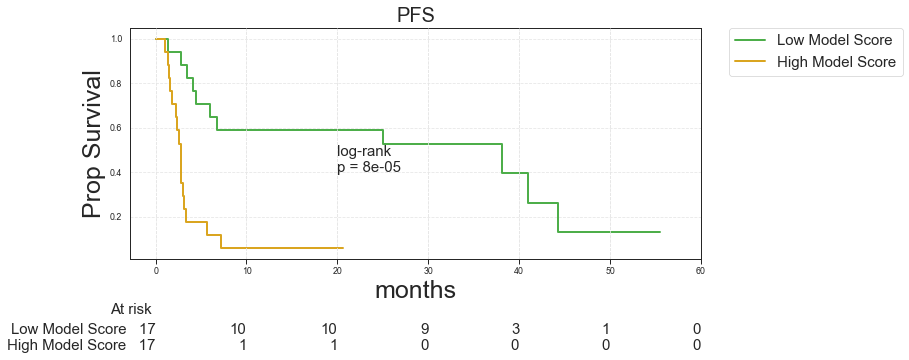

In [69]:
# Fig 5e - survival of model score-high and model score-low ipi-experienced tumors

#survival = 'OS'
survival = 'PFS'
#event = 'dead'
event = 'progressed'

sns.set_context("paper",font_scale=1)

groups = [ipiExpLower,ipiExpUpper]
#groups = [ipiNaiveLower,ipiNaiveUpper]
labels = ['Low Model Score','High Model Score']

groupColors = [CR_COL, PD_COL]

fig = plt.figure(figsize=(10,5))
kmfs = [] 
ax = plt.subplot()

i=0
ind = []
indLabels = []
for group in groups:
    kmf = KaplanMeierFitter()
    kmf.fit(tumorDF.loc[group,survival]/30., tumorDF.loc[group,event], label = labels[i])
    kmf.plot(ax=ax, ci_show = False, linewidth=2.0, color=groupColors[i])
    indLabels += [labels[i]] * len(group) # create labels for each individual
    ind += list(group)
    print labels[i], ":", len(group)
    print survival,"median", kmf.median_
    i+=1
    kmfs += [kmf]
    
# add at risk numbers below
# set xticks to start at 0
newxticks = []
for x in ax.get_xticks():
    if x >= 0:
        newxticks += [x]
print newxticks
ax.set_xticks(newxticks)

add_at_risk_counts_CUSTOM(kmfs[0], kmfs[1], ax=ax, fontsize=20, labels=labels)

    
ax.set_xlabel("months", fontsize = 25)

ax.set_ylabel("Prop Survival", fontsize = 25)
ax.legend(prop={'size':15}, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title(survival, fontsize=20)

results = multivariate_logrank_test(tumorDF.loc[ind,survival], 
                                    indLabels, 
                                    tumorDF.loc[ind,event])
plt.text(20, 0.4, "log-rank\np = %0.1g" % results.summary['p'], fontsize=15)

results.print_summary()


Low Model Score : 17
OS median inf
High Model Score : 17
OS median 8.96666666667
[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0]
['Low Model Score   17\nHigh Model Score   17', '13\n7', '13\n3', '11\n1', '4\n0', '1\n0', '0\n0']
<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  log(p)   
         10.71 <0.005   -6.84  *
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0.05 ' ' 1


/Users/davidliu/anaconda2/envs/combi-d/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs [u'c', u'color'] which are all aliases for u'color'.  Kept value from u'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/davidliu/anaconda2/envs/combi-d/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs [u'c', u'color'] which are all aliases for u'color'.  Kept value from u'color'
  seen=seen, canon=canonical, used=seen[-1]))


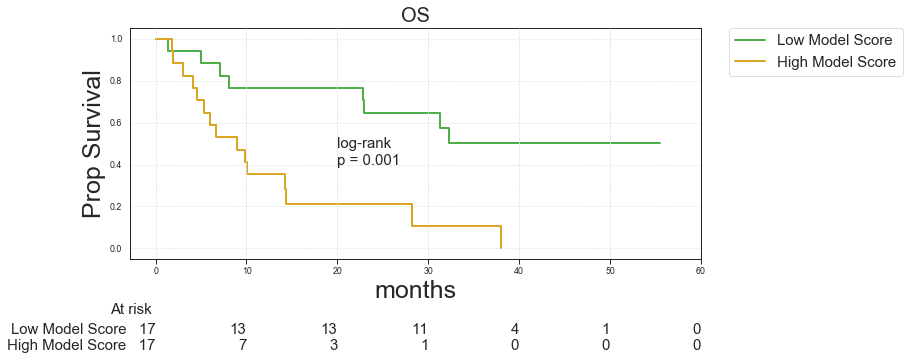

In [70]:
# Fig 5e - survival of model score-high and model score-low ipi-experienced tumors

survival = 'OS'
#survival = 'PFS'
event = 'dead'
#event = 'progressed'

sns.set_context("paper",font_scale=1)

groups = [ipiExpLower,ipiExpUpper]
#groups = [ipiNaiveLower,ipiNaiveUpper]
labels = ['Low Model Score','High Model Score']

groupColors = [CR_COL, PD_COL]

fig = plt.figure(figsize=(10,5))
kmfs = [] 
ax = plt.subplot()

i=0
ind = []
indLabels = []
for group in groups:
    kmf = KaplanMeierFitter()
    kmf.fit(tumorDF.loc[group,survival]/30., tumorDF.loc[group,event], label = labels[i])
    kmf.plot(ax=ax, ci_show = False, linewidth=2.0, color=groupColors[i])
    indLabels += [labels[i]] * len(group) # create labels for each individual
    ind += list(group)
    print labels[i], ":", len(group)
    print survival,"median", kmf.median_
    i+=1
    kmfs += [kmf]
    
# add at risk numbers below
# set xticks to start at 0
newxticks = []
for x in ax.get_xticks():
    if x >= 0:
        newxticks += [x]
print newxticks
ax.set_xticks(newxticks)

add_at_risk_counts_CUSTOM(kmfs[0], kmfs[1], ax=ax, fontsize=20, labels=labels)

    
ax.set_xlabel("months", fontsize = 25)

ax.set_ylabel("Prop Survival", fontsize = 25)
ax.legend(prop={'size':15}, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title(survival, fontsize=20)

results = multivariate_logrank_test(tumorDF.loc[ind,survival], 
                                    indLabels, 
                                    tumorDF.loc[ind,event])
plt.text(20, 0.4, "log-rank\np = %0.1g" % results.summary['p'], fontsize=15)

results.print_summary()


Low Model Score : 42
PFS median 24.7333333333
High Model Score : 42
PFS median 3.03333333333
[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0]
['Low Model Score   42\nHigh Model Score   42', '26\n12', '19\n6', '5\n2', '0\n1', '0\n1', '0\n0']
<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  log(p)   
          8.54 <0.005   -5.66  *
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0.05 ' ' 1


/Users/davidliu/anaconda2/envs/combi-d/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs [u'c', u'color'] which are all aliases for u'color'.  Kept value from u'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/davidliu/anaconda2/envs/combi-d/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs [u'c', u'color'] which are all aliases for u'color'.  Kept value from u'color'
  seen=seen, canon=canonical, used=seen[-1]))


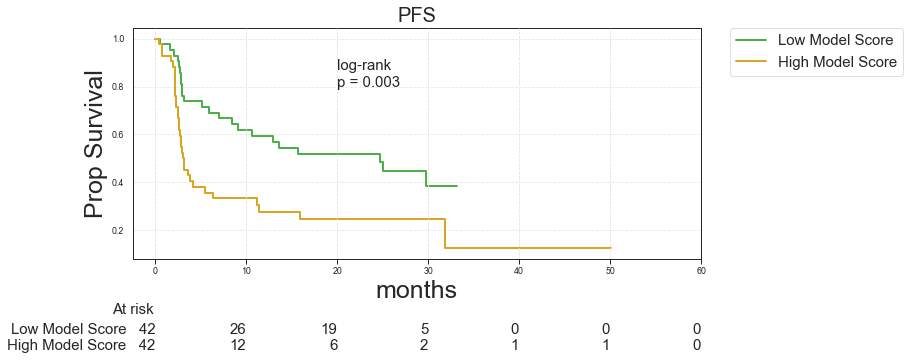

In [71]:
# Fig 5f - survival of model score-high and model score-low ipi-naive tumors

#survival = 'OS'
survival = 'PFS'
#event = 'dead'
event = 'progressed'

sns.set_context("paper",font_scale=1)

#groups = [ipiExpLower,ipiExpUpper]
groups = [ipiNaiveLower,ipiNaiveUpper]
labels = ['Low Model Score','High Model Score']

groupColors = [CR_COL, PD_COL]

fig = plt.figure(figsize=(10,5))
kmfs = [] 
ax = plt.subplot()

i=0
ind = []
indLabels = []
for group in groups:
    kmf = KaplanMeierFitter()
    kmf.fit(tumorDF.loc[group,survival]/30., tumorDF.loc[group,event], label = labels[i])
    kmf.plot(ax=ax, ci_show = False, linewidth=2.0, color=groupColors[i])
    indLabels += [labels[i]] * len(group) # create labels for each individual
    ind += list(group)
    print labels[i], ":", len(group)
    print survival,"median", kmf.median_
    i+=1
    kmfs += [kmf]
    
# add at risk numbers below
# set xticks to start at 0
newxticks = []
for x in ax.get_xticks():
    if x >= 0:
        newxticks += [x]
print newxticks
ax.set_xticks(newxticks)

add_at_risk_counts_CUSTOM(kmfs[0], kmfs[1], ax=ax, fontsize=20, labels=labels)

    
ax.set_xlabel("months", fontsize = 25)

ax.set_ylabel("Prop Survival", fontsize = 25)
ax.legend(prop={'size':15}, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title(survival, fontsize=20)

results = multivariate_logrank_test(tumorDF.loc[ind,survival], 
                                    indLabels, 
                                    tumorDF.loc[ind,event])
plt.text(20, 0.8, "log-rank\np = %0.1g" % results.summary['p'], fontsize=15)

results.print_summary()


Low Model Score : 42
OS median inf
High Model Score : 42
OS median 17.0666666667
[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0]
['Low Model Score   42\nHigh Model Score   42', '37\n26', '31\n12', '11\n4', '1\n1', '1\n1', '0\n0']
<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  log(p)     
         16.01 <0.005   -9.67  ***
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0.05 ' ' 1


/Users/davidliu/anaconda2/envs/combi-d/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs [u'c', u'color'] which are all aliases for u'color'.  Kept value from u'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/davidliu/anaconda2/envs/combi-d/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs [u'c', u'color'] which are all aliases for u'color'.  Kept value from u'color'
  seen=seen, canon=canonical, used=seen[-1]))


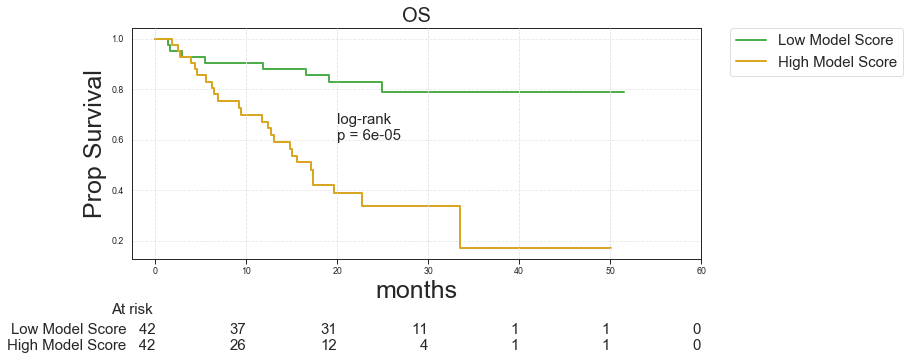

In [72]:
# Fig 5f - survival of model score-high and model score-low ipi-naive tumors

survival = 'OS'
#survival = 'PFS'
event = 'dead'
#event = 'progressed'

sns.set_context("paper",font_scale=1)

#groups = [ipiExpLower,ipiExpUpper]
groups = [ipiNaiveLower,ipiNaiveUpper]
labels = ['Low Model Score','High Model Score']

groupColors = [CR_COL, PD_COL]

fig = plt.figure(figsize=(10,5))
kmfs = [] 
ax = plt.subplot()

i=0
ind = []
indLabels = []
for group in groups:
    kmf = KaplanMeierFitter()
    kmf.fit(tumorDF.loc[group,survival]/30., tumorDF.loc[group,event], label = labels[i])
    kmf.plot(ax=ax, ci_show = False, linewidth=2.0, color=groupColors[i])
    indLabels += [labels[i]] * len(group) # create labels for each individual
    ind += list(group)
    print labels[i], ":", len(group)
    print survival,"median", kmf.median_
    i+=1
    kmfs += [kmf]
    
# add at risk numbers below
# set xticks to start at 0
newxticks = []
for x in ax.get_xticks():
    if x >= 0:
        newxticks += [x]
print newxticks
ax.set_xticks(newxticks)

add_at_risk_counts_CUSTOM(kmfs[0], kmfs[1], ax=ax, fontsize=20, labels=labels)

    
ax.set_xlabel("months", fontsize = 25)

ax.set_ylabel("Prop Survival", fontsize = 25)
ax.legend(prop={'size':15}, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title(survival, fontsize=20)

results = multivariate_logrank_test(tumorDF.loc[ind,survival], 
                                    indLabels, 
                                    tumorDF.loc[ind,event])
plt.text(20, 0.6, "log-rank\np = %0.1g" % results.summary['p'], fontsize=15)

results.print_summary()
